# Project Assignment 4: Image Classification System for Indian Bird Species

**Name/Group ID:** Berke Yusuf Uğurlu - Yusuf İpek (Group 6)

**Date:** April 26, 2025

**Course:** BBM 409 - Machine Learning Laboratory

## Introduction

Classification is a fundamental task in machine learning and human cognition. Historically, the ability to classify objects, for instance, as threats or non-threats, was crucial for survival. Modern classification tasks have become more complex and detailed, such as identifying species of animals or plants. As tasks become more detailed, their difficulty increases. To manage these complexities efficiently, we leverage computing machines. Image classification is a significant subfield of this domain. This project focuses on classifying bird species using neural networks and other machine learning techniques.

The aim of this project is to explore various machine learning approaches for classifying bird species from a given dataset. We will start with traditional feature extraction methods coupled with classical machine learning algorithms. Then, we will investigate dimensionality reduction techniques like PCA and other feature selection methods. Subsequently, we will delve into deep learning by fine-tuning pre-trained Convolutional Neural Network (CNN) models and training CNN models from scratch (both with random weights and custom architectures). A key aspect of this project will be extensive experimentation, robust evaluation using multiple metrics (Accuracy, Precision, Recall, F1-Score), and detailed interpretation of the results.

## 1. Dataset Setup

The dataset for this project contains twenty-five species of birds in India, with 1,500 samples for each species. The original samples are separated as 1,200 for training and 300 for validation per species. In total, there are 37,500 images, each approximately 1 MP.

For this assignment, we need to achieve an 80% training, 10% testing, and 10% validation split. We will do this by:
* Using all 1,200 images per species from the original `train` directory as our **training set (80%)**.
* Splitting the 300 images per species from the original `valid` directory randomly in half:
    * 150 images per species for our **new validation set (10%)**.
    * The remaining 150 images per species for our **test set (10%)**.

We will **not** be physically copying these files. Instead, we will generate lists of file paths for each set and use these lists to load data on-the-fly. This approach aligns with the project's allowance to "work with a subset of the dataset" or use it as desired if computational power is a concern, by avoiding unnecessary duplication.

**Dataset Source:** [Kaggle Indian Birds Species Image Classification Dataset](https://www.kaggle.com/datasets/ichhadhari/indian-birds/data)

**Important Considerations from the Assignment:**
* You are free to downscale images if computational resources are a constraint.
* The primary focus is on your interpretations and implementations.

In [2]:
# General Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import cv2 # OpenCV for image processing
from PIL import Image # Pillow for image processing
import random
import time

# Deep Learning Libraries (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow Version:", tf.__version__)
print("NumPy Version:", np.__version__)
print("OpenCV Version:", cv2.__version__)

TensorFlow Version: 2.10.1
NumPy Version: 1.26.4
OpenCV Version: 4.11.0


In [3]:
# --- Dataset Path ---
BASE_DATA_DIR = "Birds_25"

# Check if the dataset path exists
original_train_data_path = os.path.join(BASE_DATA_DIR, "train")
original_valid_data_path = os.path.join(BASE_DATA_DIR, "valid")

print(f"Dataset base directory found at: {BASE_DATA_DIR}")
print(f"Original training data path: {original_train_data_path}")
print(f"Original validation data path: {original_valid_data_path}")

Dataset base directory found at: Birds_25
Original training data path: Birds_25\train
Original validation data path: Birds_25\valid


In [4]:
# --- Function to Prepare File Lists and Labels (80-10-10 split) ---
def prepare_dataset_file_lists():
    train_image_paths = []
    train_labels_str = []
    val_image_paths = []
    val_labels_str = []
    test_image_paths = []
    test_labels_str = []

    species_list = sorted([d for d in os.listdir(original_train_data_path)])
    if not species_list:
        print("No species found in the training directory.")
        return None, None, None, None, None

    print(f"Found {len(species_list)} species: {species_list[:5]}...")
    
    label_encoder = LabelEncoder()
    label_encoder.fit(species_list) # fit on all species names
    class_names = list(label_encoder.classes_)

    for species_name in species_list:
        # training set (80%)
        species_train_dir = os.path.join(original_train_data_path, species_name)
        if os.path.isdir(species_train_dir):
            for img_name in os.listdir(species_train_dir):
                img_path = os.path.join(species_train_dir, img_name)
                if os.path.isfile(img_path):
                    train_image_paths.append(img_path)
                    train_labels_str.append(species_name)
        
        # validation and Test sets (from original 'valid' directory)
        species_original_valid_dir = os.path.join(original_valid_data_path, species_name)
        if os.path.isdir(species_original_valid_dir):
            current_species_original_valid_files = []
            for img_name in os.listdir(species_original_valid_dir):
                img_path = os.path.join(species_original_valid_dir, img_name)
                if os.path.isfile(img_path):
                    current_species_original_valid_files.append(img_path)
            
            random.shuffle(current_species_original_valid_files)
            
            num_original_valid = len(current_species_original_valid_files)
            
            # split each validation set (originally 300) into half (150 val, 150 test)
            split_point = 150 
            if num_original_valid < 300 and num_original_valid > 0:
                print(f"Warning: Species {species_name} has {num_original_valid} images in original validation set (expected 300). Adjusting val/test split point to {num_original_valid // 2}.")
                split_point = num_original_valid // 2
            elif num_original_valid == 0:
                print(f"Warning: Species {species_name} has 0 images in original validation set.")
                continue # no files to split

            val_set_for_species = current_species_original_valid_files[:split_point]
            test_set_for_species = current_species_original_valid_files[split_point : split_point * 2] # haandles cases with <300 
            
            if len(val_set_for_species) == 0 and len(test_set_for_species) == 0 and num_original_valid > 0:
                # fallback - split_point became 0 due to very few images
                if num_original_valid == 1:
                    val_set_for_species = current_species_original_valid_files
                # else leave test empty if only 1 file
            
            val_image_paths.extend(val_set_for_species)
            val_labels_str.extend([species_name] * len(val_set_for_species))
            
            test_image_paths.extend(test_set_for_species)
            test_labels_str.extend([species_name] * len(test_set_for_species))

    # create df
    train_df = pd.DataFrame({'filepath': train_image_paths, 'label': train_labels_str})
    val_df = pd.DataFrame({'filepath': val_image_paths, 'label': val_labels_str})
    test_df = pd.DataFrame({'filepath': test_image_paths, 'label': test_labels_str})
    
    # add numeric labels
    train_df['id'] = label_encoder.transform(train_df['label'])
    val_df['id'] = label_encoder.transform(val_df['label'])
    test_df['id'] = label_encoder.transform(test_df['label'])

    return train_df, val_df, test_df, label_encoder, class_names

In [5]:
# set dataset file lists
train_df, val_df, test_df, label_encoder, class_names = prepare_dataset_file_lists()

print(f"\nDataset prepared:")
print(f"  Training samples: {len(train_df)} (Expected ~{len(class_names)*1200 if class_names else 'N/A'})")
print(f"  Validation samples: {len(val_df)} (Expected ~{len(class_names)*150 if class_names else 'N/A'})")
print(f"  Test samples: {len(test_df)} (Expected ~{len(class_names)*150 if class_names else 'N/A'})")
print(f"  Number of classes: {len(class_names) if class_names else 'N/A'}")
if class_names: print(f"  Example class names: {class_names[:5]}")

# save label encoder classes for later use
np.save('label_encoder_classes.npy', label_encoder.classes_) 

# display first few rows of the df
print("\nTraining DataFrame head:")
print(train_df.head())

print("\nValidation DataFrame head:")
print(val_df.head())

print("\nTest DataFrame head:")
print(test_df.head())

Found 25 species: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']...

Dataset prepared:
  Training samples: 30000 (Expected ~30000)
  Validation samples: 3750 (Expected ~3750)
  Test samples: 3750 (Expected ~3750)
  Number of classes: 25
  Example class names: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']

Training DataFrame head:
                                            filepath                  label  \
0  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
1  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
2  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
3  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
4  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   

   id  
0   0  
1   0  
2   0  
3   0  
4   0  

Validation DataFrame head:
        

### 1.1. Image Preprocessing Utilities and Data Subsetting
We define a target image size. Images will be loaded and resized on-the-fly.
The assignment allows downscaling images if needed.

In [6]:
# Constants and Setup
IMG_WIDTH = 128 
IMG_HEIGHT = 128
IMG_CHANNELS = 3 # color images
TARGET_IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH) # Pillow - (width, height), OpenCV - (height, width)

# list and dicts
part1_results_list = [] # results for comparison table
# all extracted features here for Part 1 & 2
all_extracted_features = {} # example: {'train': {feature_name: (X,y)}, 'val': {} 'test': {}}

In [7]:
# --- Pillow Preprocess for Sindgle Image ---
# Pillow - (width, height)
def preprocess_image_pil(image_path, target_size=TARGET_IMG_SIZE, normalize=True):
    try:
        img = Image.open(image_path).convert('RGB') # 3 channels
        img = img.resize((target_size[1], target_size[0])) # PIL resize is (width, height)
        img_array = np.array(img)
        if normalize: # normalization 
            img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path} with PIL: {e}")
        return None

In [8]:
# --- OpenCV PreProcess for Single Image ---
# OpenCV - (height, width)
def preprocess_image_cv2(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH), normalize_for_nn=False, for_feature_extraction=False):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: OpenCV could not read image {image_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR
        img = cv2.resize(img, (target_size[1], target_size[0])) # cv2 resize is (width, height)
        
        if normalize_for_nn: # normalization
            img_array = img.astype(np.float32) / 255.0
            return img_array
        elif for_feature_extraction: # return as uint8
            return img.astype(np.uint8)
        return img # default return (uint8, RGB)
    except Exception as e:
        print(f"Error processing image {image_path} with CV2: {e}")
        return None

In [9]:
# --- Use a Subset of the DF
# for quick tests
def get_subset_df(df, subset_fraction=0.1, random_state=42):
    if df is None or df.empty or subset_fraction >= 1.0:
        return df
    # Stratified sampling to maintain class proportions in the subset
    # Requires 'id' (numeric label) or 'label' (string label) column for stratification
    group_col = 'id' if 'id' in df.columns else 'label'
    
    # Ensure frac is not too small to result in zero samples for some groups if not replacing
    # A simple way is to ensure at least 1 sample per group if frac is very small, but pandas sample handles this.
    return df.groupby(group_col, group_keys=False).apply(lambda x: x.sample(frac=subset_fraction, random_state=random_state, replace=False))

In [10]:
# GET SUBSET

USE_SUBSET = True
SUBSET_FRACTION = 0.25

train_df_processed = train_df
val_df_processed = val_df
test_df_processed = test_df

if USE_SUBSET:
    print(f"\nUsing a {SUBSET_FRACTION*100:.0f}% subset of the data for development...")
    train_df_processed = get_subset_df(train_df, SUBSET_FRACTION)
    val_df_processed = get_subset_df(val_df, SUBSET_FRACTION)
    test_df_processed = get_subset_df(test_df, SUBSET_FRACTION) 
    
    print(f"  New Training samples: {len(train_df_processed)}")
    print(f"  New Validation samples: {len(val_df_processed)}")
    print(f"  New Test samples: {len(test_df_processed)}")
else:
    print("\nUsing full prepared dataset splits.")


Using a 25% subset of the data for development...
  New Training samples: 7500
  New Validation samples: 950
  New Test samples: 950


C:\Users\berke\AppData\Local\Temp\ipykernel_28316\3108335365.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(lambda x: x.sample(frac=subset_fraction, random_state=random_state, replace=False))
C:\Users\berke\AppData\Local\Temp\ipykernel_28316\3108335365.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False

### 1.2. Data Visualization
Visualize some sample images and the distribution of classes from our prepared DataFrames.
"Import and visualize the data in any aspects that you think it is beneficial for the reader's better understanding of the data."

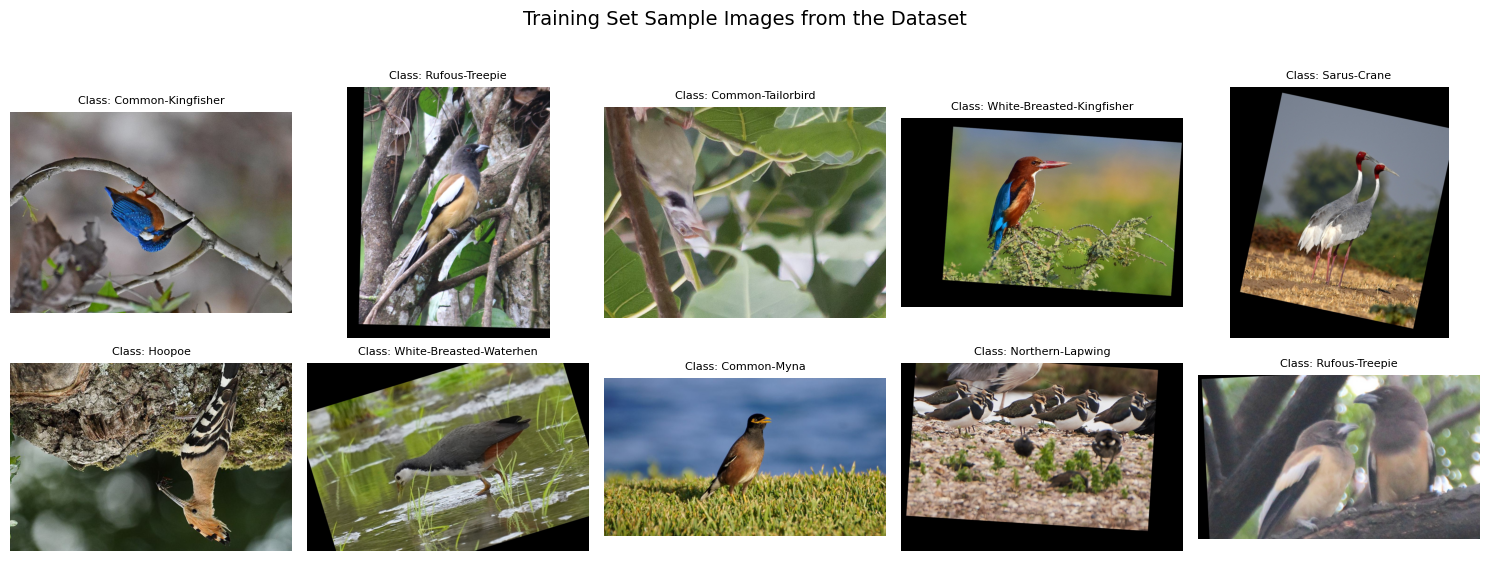

In [11]:
# --- Visualize Sample Images with Pillow from DF ---
def visualize_sample_images_from_df(df, num_samples=10, title_prefix=""):
    if df is None or df.empty:
        print(f"{title_prefix} DataFrame is empty. Cannot visualize samples.")
        return
    
    # Ensure we don't try to sample more than available unique images
    actual_num_samples = min(num_samples, len(df))
    if actual_num_samples == 0: 
        print(f"{title_prefix} DataFrame has no samples to visualize.")
        return
        
    sample_df = df.sample(actual_num_samples)
    
    plt.figure(figsize=(15, max(5, (actual_num_samples//5)*3) ))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = row.filepath
        label_str = row.label
        try:
            img = Image.open(img_path) # Use PIL for consistency with one of the preprocessors
            plt.subplot( (actual_num_samples + 4) // 5 , 5, i + 1)
            plt.imshow(img)
            plt.title(f"Class: {label_str}", fontsize=8)
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image {img_path} for visualization: {e}")
    plt.suptitle(f"{title_prefix} Sample Images from the Dataset", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


visualize_sample_images_from_df(train_df_processed, title_prefix="Training Set")

In [12]:
def plot_class_distribution_from_df(df, title="Class Distribution"):
    if df is None or df.empty:
        print(f"DataFrame for '{title}' is empty. Cannot plot class distribution.")
        return
    
    plt.figure(figsize=(10, 8))
    sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')
    plt.title(title, fontsize=15)
    plt.xlabel("Number of Samples", fontsize=12)
    plt.ylabel("Bird Species", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

C:\Users\berke\AppData\Local\Temp\ipykernel_28316\3086890726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')


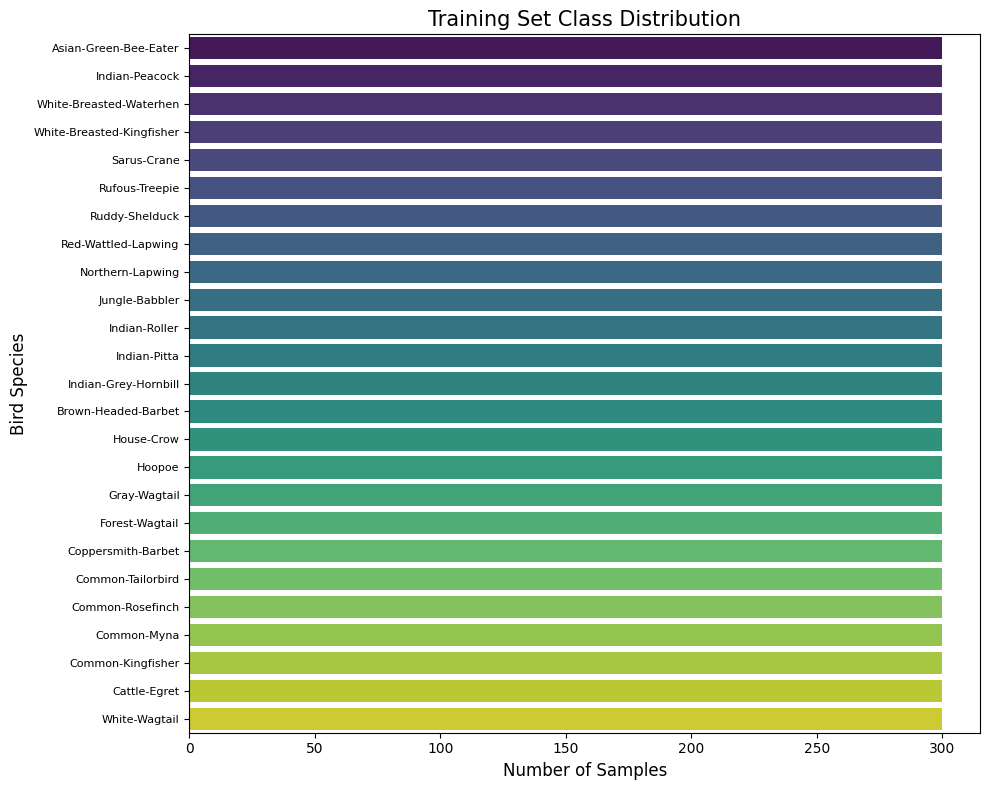

C:\Users\berke\AppData\Local\Temp\ipykernel_28316\3086890726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')


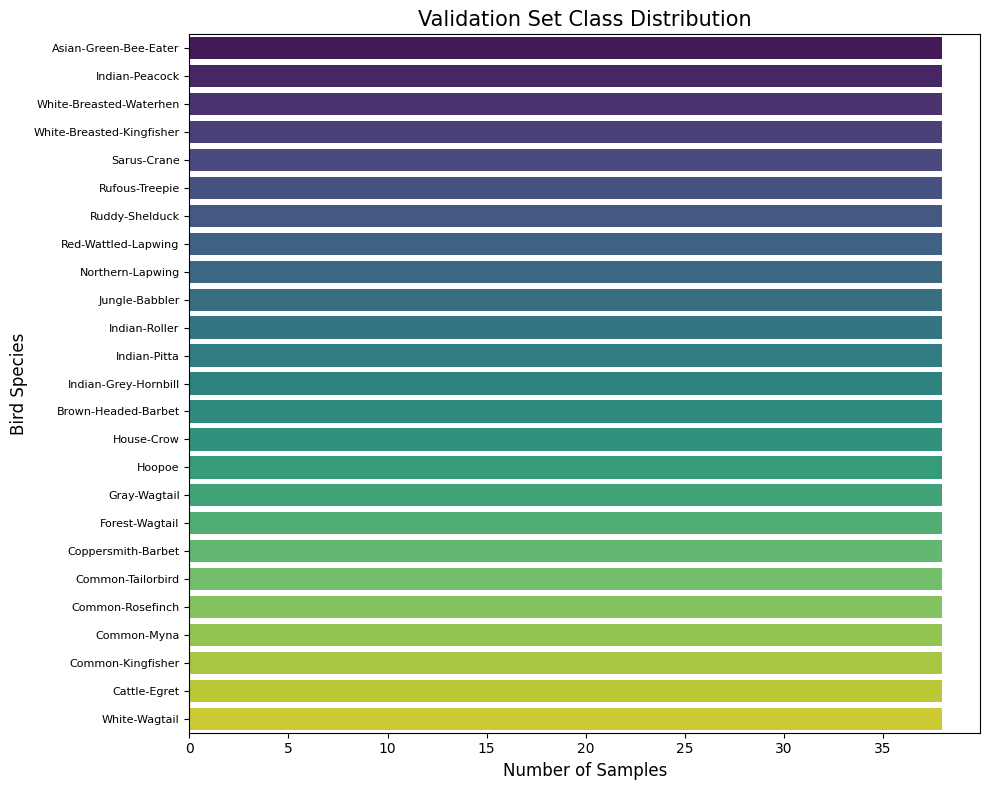

C:\Users\berke\AppData\Local\Temp\ipykernel_28316\3086890726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')


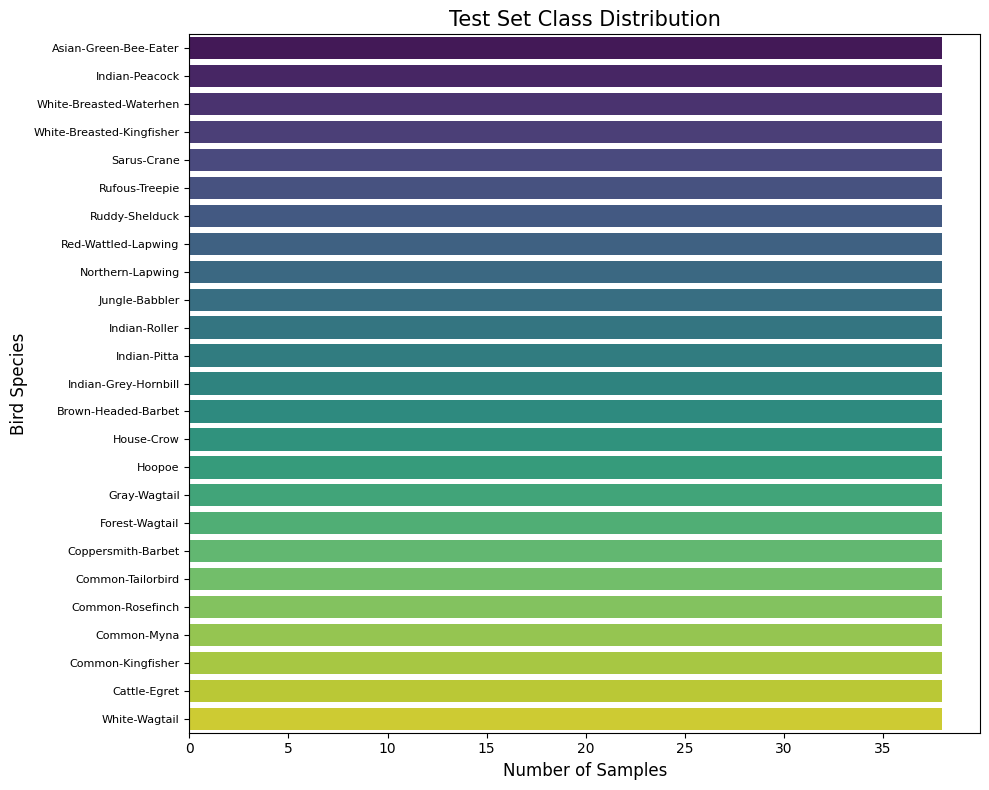

In [13]:
# train
plot_class_distribution_from_df(train_df_processed, title="Training Set Class Distribution")
# value
plot_class_distribution_from_df(val_df_processed, title="Validation Set Class Distribution")
# test
plot_class_distribution_from_df(test_df_processed, title="Test Set Class Distribution")

## Part 1: Classification According to Feature Extraction

In this part, we will extract features from the images and then apply basic Machine Learning (ML) algorithms. We need to try at least three feature extraction methodologies and at least three ML algorithms. Each extracted feature set will be tested with each model separately. Results and comments are required.

**Chosen Feature Extraction Methods:**
1.  **Color Histogram:** Captures color distribution.
2.  **Histogram of Oriented Gradients (HOG):** Captures shape information by edge orientation.
3.  **SIFT (Scale-Invariant Feature Transform) derived features (Aggregated):** Captures local keypoints, aggregated by averaging. (A full Bag of Visual Words would be more robust but is more complex to implement for this scope).

**Chosen ML Algorithms:**
1.  **Support Vector Machines (SVM)**
2.  **Random Forest**
3.  **Multilayer Perceptron (MLP)** (a simple neural network)

Images will be loaded from the file paths in our DataFrames and preprocessed.

In [14]:
# --- Evaluate Model ---
def evaluate_and_log_model(model_name, feature_name, y_true, y_pred, class_names_list, results_accumulator):
    accuracy = accuracy_score(y_true, y_pred)
    # weighted average for precision, recall, F1
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"Results for {model_name} with {feature_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    results_accumulator.append({
        'FeatureSet': feature_name,
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    # Confusion Matrix
    # cm_labels = sorted(np.unique(np.concatenate((y_true, y_pred)))) 
    cm_numeric_labels = np.arange(len(class_names_list)) 

    try:
        cm = confusion_matrix(y_true, y_pred, labels=cm_numeric_labels)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt='d', 
                    xticklabels=class_names_list, yticklabels=class_names_list)
        plt.title(f"Confusion Matrix: {model_name} with {feature_name}", fontsize=14)
        plt.xlabel("Predicted Label", fontsize=12)
        plt.ylabel("True Label", fontsize=12)
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()
    except ValueError as ve_cm:
        print(f"Could not plot confusion matrix for {model_name} with {feature_name}: {ve_cm}")
        print("This might happen if y_true or y_pred contain labels not in class_names_list or if subsetting is extreme.")

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

In [15]:
# --- Load and Extract Features DF ---

def load_and_extract_features_from_df(df, feature_extraction_func, image_processor, limit=None):
    """Loads images from filepaths in a DataFrame, extracts features, and returns features and labels."""
    features_list = []
    labels_list = []
    
    paths_to_process = df['filepath'].tolist()
    corresponding_labels = df['id'].tolist() # numeric 'id' for labels

    if limit is not None:
        paths_to_process = paths_to_process[:limit]
        corresponding_labels = corresponding_labels[:limit]
        
    processed_count = 0
    for i, img_path in enumerate(paths_to_process):
        if (i+1) % 200 == 0:
            print(f"  Processing image {i+1}/{len(paths_to_process)} for {feature_extraction_func.__name__}...")
        
        # HOG, SIFT often work on uint8 grayscale. Color Hist on uint8 RGB.
        image = image_processor(img_path, target_size=TARGET_IMG_SIZE, for_feature_extraction=True)
        if image is not None:
            feature_vector = feature_extraction_func(image)
            if feature_vector is not None:
                features_list.append(feature_vector)
                labels_list.append(corresponding_labels[i])
                processed_count += 1
            else: print(f"    Feature extraction failed for {img_path}")
        else: print(f"    Image loading failed for {img_path}")
            
    print(f"  Successfully processed and extracted features for {processed_count}/{len(paths_to_process)} images.")
    if not features_list: # If no features were extracted
        return np.array([]), np.array([])
        
    return np.array(features_list), np.array(labels_list)

#### 1.1. Feature Extraction: Color Histogram
A color histogram represents the distribution of colors in an image. We compute a histogram for each channel (R, G, B) and concatenate them.
<br/>
To get the RGB colors from the image, the **cv2** module provides `calchist` method that accepts the image object, channel to get a specific color, mask, histogram size, and range.



In [16]:
# --- Extract Color Histogram for RGB uint8 Image ---
def extract_color_histogram(image, bins=32):
    if image is None: return None
    hist_features = []
    for i in range(image.shape[2]): # iterate over channels (R, G, B)
        channel_hist = cv2.calcHist([image], [i], None, [bins], [0, 256])
        cv2.normalize(channel_hist, channel_hist) # normalize histogram
        hist_features.extend(channel_hist.flatten())
    return np.array(hist_features)

In [17]:
feature_name_ch = 'ColorHistogram'
all_extracted_features['train'] = {}
all_extracted_features['val'] = {}
all_extracted_features['test'] = {}

#  one consistent preprocessor for feature extraction images
image_preprocessor_for_features = preprocess_image_cv2

# training
print(f"Extracting {feature_name_ch} for Training set...")
X_train_ch, y_train_ch = load_and_extract_features_from_df(train_df_processed, extract_color_histogram, image_preprocessor_for_features)
if X_train_ch.size > 0: 
    all_extracted_features['train'][feature_name_ch] = (X_train_ch, y_train_ch)
else: 
    print(f"  No {feature_name_ch} features extracted for training set.")

# validation
print(f"\nExtracting {feature_name_ch} for Validation set...")
X_val_ch, y_val_ch = load_and_extract_features_from_df(val_df_processed, extract_color_histogram, image_preprocessor_for_features)
if X_val_ch.size > 0: 
    all_extracted_features['val'][feature_name_ch] = (X_val_ch, y_val_ch)
else:
    print(f"  No {feature_name_ch} features extracted for validation set.")

# test
print(f"\nExtracting {feature_name_ch} for Test set...")
X_test_ch, y_test_ch = load_and_extract_features_from_df(test_df_processed, extract_color_histogram, image_preprocessor_for_features)
if X_test_ch.size > 0: 
    all_extracted_features['test'][feature_name_ch] = (X_test_ch, y_test_ch)
else:
    print(f"  No {feature_name_ch} features extracted for test set.")

if X_train_ch.size > 0 : 
    print(f"\n{feature_name_ch} feature shapes: Train: {X_train_ch.shape}, Val: {X_val_ch.shape if X_val_ch.size>0 else 'N/A'}, Test: {X_test_ch.shape if X_test_ch.size>0 else 'N/A'}")
else:
    print("Skipping Color Histogram extraction as initial dataframes are not available.")

Extracting ColorHistogram for Training set...
  Processing image 200/7500 for extract_color_histogram...
  Processing image 400/7500 for extract_color_histogram...
  Processing image 600/7500 for extract_color_histogram...
  Processing image 800/7500 for extract_color_histogram...
  Processing image 1000/7500 for extract_color_histogram...
  Processing image 1200/7500 for extract_color_histogram...
  Processing image 1400/7500 for extract_color_histogram...
  Processing image 1600/7500 for extract_color_histogram...
  Processing image 1800/7500 for extract_color_histogram...
  Processing image 2000/7500 for extract_color_histogram...
  Processing image 2200/7500 for extract_color_histogram...
  Processing image 2400/7500 for extract_color_histogram...
  Processing image 2600/7500 for extract_color_histogram...
  Processing image 2800/7500 for extract_color_histogram...
  Processing image 3000/7500 for extract_color_histogram...
  Processing image 3200/7500 for extract_color_histogram..

#### 1.2. Feature Extraction: Histogram of Oriented Gradients (HOG)
The core idea behind HOG is to capture the distribution of gradient orientations in an image, which can be used to describe the shape and appearance of objects. HOG features are computed by dividing an image into small cells, calculating the gradient orientations within each cell, and then aggregating these orientations into a histogram. This histogram represents the distribution of gradient orientations, which can be used as a feature vector for object detection. We use `scikit-image`.

Example Histogram of Gradients
<br/><br/>
<img src='https://miro.medium.com/v2/resize:fit:640/format:webp/1*FNxLHK16nXAQLP4WweXf7Q.png' width=500 height=400>

In [18]:
from skimage.feature import hog
from skimage import color # exposure not used here directly

# --- Extract HOG Features from RGB Uint8 Image---
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=8):
    if image is None: return None
    gray_image = color.rgb2gray(image) # skimage converts to float [0,1]
    hog_features_vector = hog(
        gray_image, orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=False,
        transform_sqrt=True)
    return hog_features_vector

In [19]:
feature_name_hog = 'HOG'

# train
print(f"Extracting {feature_name_hog} for Training set...")
X_train_hog, y_train_hog = load_and_extract_features_from_df(train_df_processed, extract_hog_features, image_preprocessor_for_features)
if X_train_hog.size > 0: 
    all_extracted_features['train'][feature_name_hog] = (X_train_hog, y_train_hog)
else: 
    print(f"  No {feature_name_hog} features extracted for training set.")

# validation
print(f"\nExtracting {feature_name_hog} for Validation set...")
X_val_hog, y_val_hog = load_and_extract_features_from_df(val_df_processed, extract_hog_features, image_preprocessor_for_features)
if X_val_hog.size > 0: 
    all_extracted_features['val'][feature_name_hog] = (X_val_hog, y_val_hog)
else: 
    print(f"  No {feature_name_hog} features extracted for validation set.")

# test
print(f"\nExtracting {feature_name_hog} for Test set...")
X_test_hog, y_test_hog = load_and_extract_features_from_df(test_df_processed, extract_hog_features, image_preprocessor_for_features)
if X_test_hog.size > 0:
    all_extracted_features['test'][feature_name_hog] = (X_test_hog, y_test_hog)
else:
    print(f"  No {feature_name_hog} features extracted for test set.")

if X_train_hog.size > 0 : 
    print(f"\n{feature_name_hog} feature shapes: Train: {X_train_hog.shape}, Val: {X_val_hog.shape if X_val_hog.size>0 else 'N/A'}, Test: {X_test_hog.shape if X_test_hog.size>0 else 'N/A'}")
else:
    print("Skipping HOG extraction as initial dataframes are not available.")

Extracting HOG for Training set...
  Processing image 200/7500 for extract_hog_features...
  Processing image 400/7500 for extract_hog_features...
  Processing image 600/7500 for extract_hog_features...
  Processing image 800/7500 for extract_hog_features...
  Processing image 1000/7500 for extract_hog_features...
  Processing image 1200/7500 for extract_hog_features...
  Processing image 1400/7500 for extract_hog_features...
  Processing image 1600/7500 for extract_hog_features...
  Processing image 1800/7500 for extract_hog_features...
  Processing image 2000/7500 for extract_hog_features...
  Processing image 2200/7500 for extract_hog_features...
  Processing image 2400/7500 for extract_hog_features...
  Processing image 2600/7500 for extract_hog_features...
  Processing image 2800/7500 for extract_hog_features...
  Processing image 3000/7500 for extract_hog_features...
  Processing image 3200/7500 for extract_hog_features...
  Processing image 3400/7500 for extract_hog_features...


#### 1.3. Feature Extraction: SIFT (Aggregated)
SIFT (Scale Invariant Feature Transform) detects interest points of an image. It allows the identication of local features. We'll aggregate descriptors (by gray scaling and averaging) for a fixed-size vector.
We are using `cv2 SHIFT` and `detectAndCompute` function.

In [20]:
# init SIFT detector
sift_detector = None

try:
    sift_detector = cv2.SIFT_create()
except AttributeError:
    print("cv2.SIFT_create() not found. Ensure 'opencv-contrib-python' is installed.")

if sift_detector is not None:
    print("SIFT detector initialized successfully.")

SIFT detector initialized successfully.


In [21]:
MAX_KEYPOINTS_SIFT = 100 # limit keypoints per image if using aggregation
SIFT_DESCRIPTOR_SIZE = 128

# --- Extract SIFT descriptors and Aggregates by averaging with Uint8 RGB Image ---
def extract_sift_features_aggregated(image):
    if image is None or sift_detector is None: return np.zeros(SIFT_DESCRIPTOR_SIZE) # Return zero vector if no image/detector
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # SIFT works on grayscale
    
    keypoints, descriptors = sift_detector.detectAndCompute(gray_image, None)
    
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(SIFT_DESCRIPTOR_SIZE) # Return zero vector if no descriptors found

    # aggregate descriptors: simple averaging
    aggregated_descriptor = np.mean(descriptors, axis=0)
    return aggregated_descriptor.flatten()

In [22]:
feature_name_sift = 'SIFT_Aggregated'

# training
print(f"Extracting {feature_name_sift} for Training set...")
X_train_sift, y_train_sift = load_and_extract_features_from_df(train_df_processed, extract_sift_features_aggregated, image_preprocessor_for_features)
if X_train_sift.size > 0: 
    all_extracted_features['train'][feature_name_sift] = (X_train_sift, y_train_sift)
else: 
    print(f"  No {feature_name_sift} features extracted for training set.")

# validation
print(f"\nExtracting {feature_name_sift} for Validation set...")
X_val_sift, y_val_sift = load_and_extract_features_from_df(val_df_processed, extract_sift_features_aggregated, image_preprocessor_for_features)
if X_val_sift.size > 0:
    all_extracted_features['val'][feature_name_sift] = (X_val_sift, y_val_sift)
else: 
    print(f"  No {feature_name_sift} features extracted for validation set.")

# test
print(f"\nExtracting {feature_name_sift} for Test set...")
X_test_sift, y_test_sift = load_and_extract_features_from_df(test_df_processed, extract_sift_features_aggregated, image_preprocessor_for_features)
if X_test_sift.size > 0:
    all_extracted_features['test'][feature_name_sift] = (X_test_sift, y_test_sift)
else:
    print(f"  No {feature_name_sift} features extracted for test set.")

if X_train_sift.size > 0 : 
    print(f"\n{feature_name_sift} feature shapes: Train: {X_train_sift.shape}, Val: {X_val_sift.shape if X_val_sift.size>0 else 'N/A'}, Test: {X_test_sift.shape if X_test_sift.size>0 else 'N/A'}")
else:
    print("Skipping SIFT Aggregated extraction as SIFT detector is not available or initial dataframes are not available.")

Extracting SIFT_Aggregated for Training set...
  Processing image 200/7500 for extract_sift_features_aggregated...
  Processing image 400/7500 for extract_sift_features_aggregated...
  Processing image 600/7500 for extract_sift_features_aggregated...
  Processing image 800/7500 for extract_sift_features_aggregated...
  Processing image 1000/7500 for extract_sift_features_aggregated...
  Processing image 1200/7500 for extract_sift_features_aggregated...
  Processing image 1400/7500 for extract_sift_features_aggregated...
  Processing image 1600/7500 for extract_sift_features_aggregated...
  Processing image 1800/7500 for extract_sift_features_aggregated...
  Processing image 2000/7500 for extract_sift_features_aggregated...
  Processing image 2200/7500 for extract_sift_features_aggregated...
  Processing image 2400/7500 for extract_sift_features_aggregated...
  Processing image 2600/7500 for extract_sift_features_aggregated...
  Processing image 2800/7500 for extract_sift_features_aggre

#### 1.4. Training Machine Learning Models
We train SVM (Support Vector Machine), Random Forest, and MLP (Multi-Layer Perceptron) on each extracted feature set. Features are scaled for SVM and MLP using a pipeline.

##### Model Descriptions

- **SVM (Support Vector Machine):**  
  A supervised learning model that finds the optimal hyperplane to classify data points. It is sensitive to feature scaling, so features are standardized before training.

- **Random Forest:**  
  A learning method that builds multiple decision trees and merges their outputs for more accurate and stable predictions. It is robust to overfitting and does not require feature scaling.

- **MLP (Multi-Layer Perceptron):**  
  A type of feedforward artificial neural network with one or more hidden layers. It uses backpropagation for training and requires scaled features for better performance.


Model Visualizations (Example)

<table>
  <tr>
    <td align="center"><b>MLP</b></td>
    <td align="center"><b>SVM</b></td>
    <td align="center"><b>Random Forest</b></td>
  </tr>
  <tr>
    <td><img src="https://media.geeksforgeeks.org/wp-content/uploads/nodeNeural.jpg" alt="MLP" width="200"/></td>
    <td><img src="https://media.geeksforgeeks.org/wp-content/uploads/20240321211805/Untitled.png" alt="SVM" width="200"/></td>
    <td><img src="https://miro.medium.com/v2/resize:fit:600/format:webp/0*41GThI3k1--f8PrV" alt="Random Forest" width="200"/></td>
  </tr>
</table>


In [23]:
# Model Imports
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import time

In [24]:
# Define the original set of models (for features like Color Histogram, SIFT Aggregated)
models_to_try_part1_standard = {
    "SVM_RBF": Pipeline([
        ('scaler', StandardScaler()),
        # lower-dim features first.
        ('svc', SVC(kernel='rbf', C=1.0, probability=True, random_state=42, class_weight='balanced')) 
    ]),
    "RandomForest_Std": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    "MLP_Std": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(256, 128), max_iter=500, alpha=0.001, 
            solver='adam', learning_rate_init=0.001, learning_rate='adaptive',
            random_state=42, early_stopping=True, n_iter_no_change=20, verbose=False))
    ])
}

# Define a simplified/faster set of models specifically for HOG features
models_to_try_part1_for_hog = {
    # Linear svc is faster for high-dimensional data like HOG
    "LinearSVC": Pipeline([ 
        ('scaler', StandardScaler()),
        ('svc', LinearSVC(random_state=42, C=0.1, max_iter=2000, dual=True, class_weight='balanced')) 
    ]),
    "RandomForest_Simple": RandomForestClassifier(
        n_estimators=50, max_depth=10, # reduced complexity for HOG
        random_state=42, n_jobs=-1, class_weight='balanced'),
    "MLP_Simple": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(64,), max_iter=200,
            alpha=0.001, solver='adam', learning_rate_init=0.001,
            random_state=42, early_stopping=True, n_iter_no_change=10, verbose=False))
    ])
}


--- Training models on Feature Set: ColorHistogram ---
Training data shape: X: (7500, 96), y: (7500,)
Test data shape: X: (950, 96), y: (950,)
  Training SVM_RBF (using config: SVM_RBF) with ColorHistogram...
    Training SVM_RBF took 12.76 seconds.
    Test Set Evaluation for SVM_RBF with ColorHistogram:
Results for SVM_RBF with ColorHistogram:
  Accuracy:  0.2505
  Precision: 0.2582
  Recall:    0.2505
  F1-Score:  0.2440


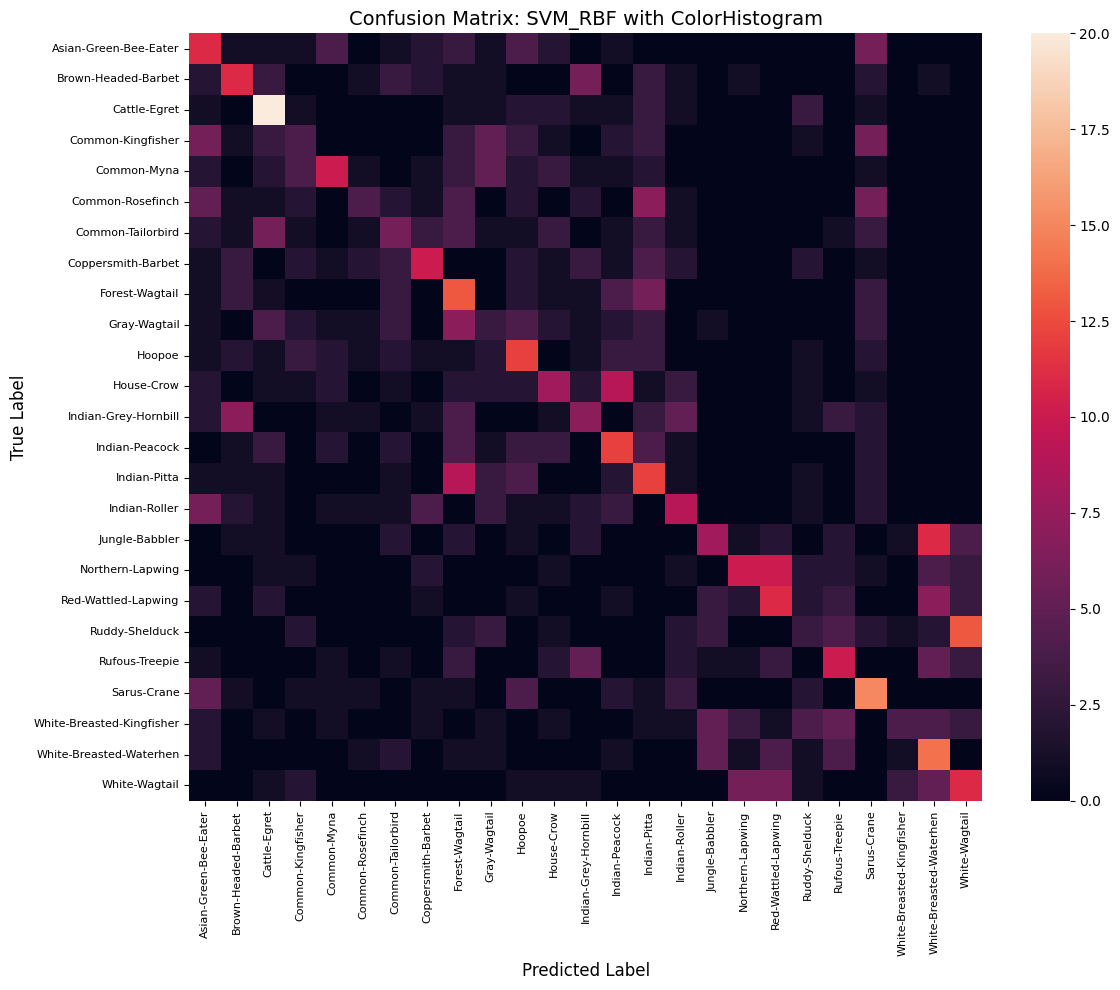

  Training RandomForest (using config: RandomForest_Std) with ColorHistogram...
    Training RandomForest took 0.84 seconds.
    Test Set Evaluation for RandomForest with ColorHistogram:
Results for RandomForest with ColorHistogram:
  Accuracy:  0.4463
  Precision: 0.4521
  Recall:    0.4463
  F1-Score:  0.4432


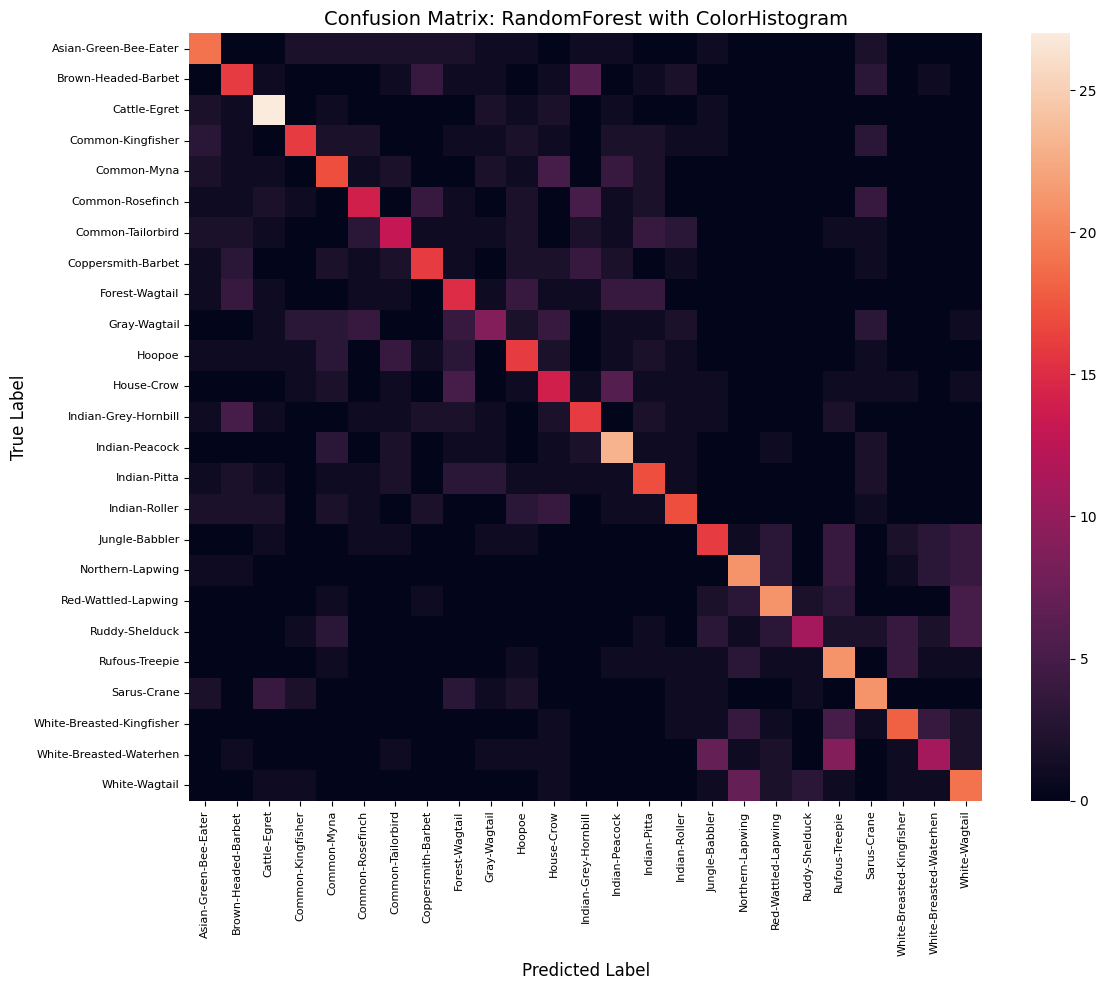

  Training MLP (using config: MLP_Std) with ColorHistogram...
    Training MLP took 7.18 seconds.
    Test Set Evaluation for MLP with ColorHistogram:
Results for MLP with ColorHistogram:
  Accuracy:  0.3442
  Precision: 0.3438
  Recall:    0.3442
  F1-Score:  0.3402


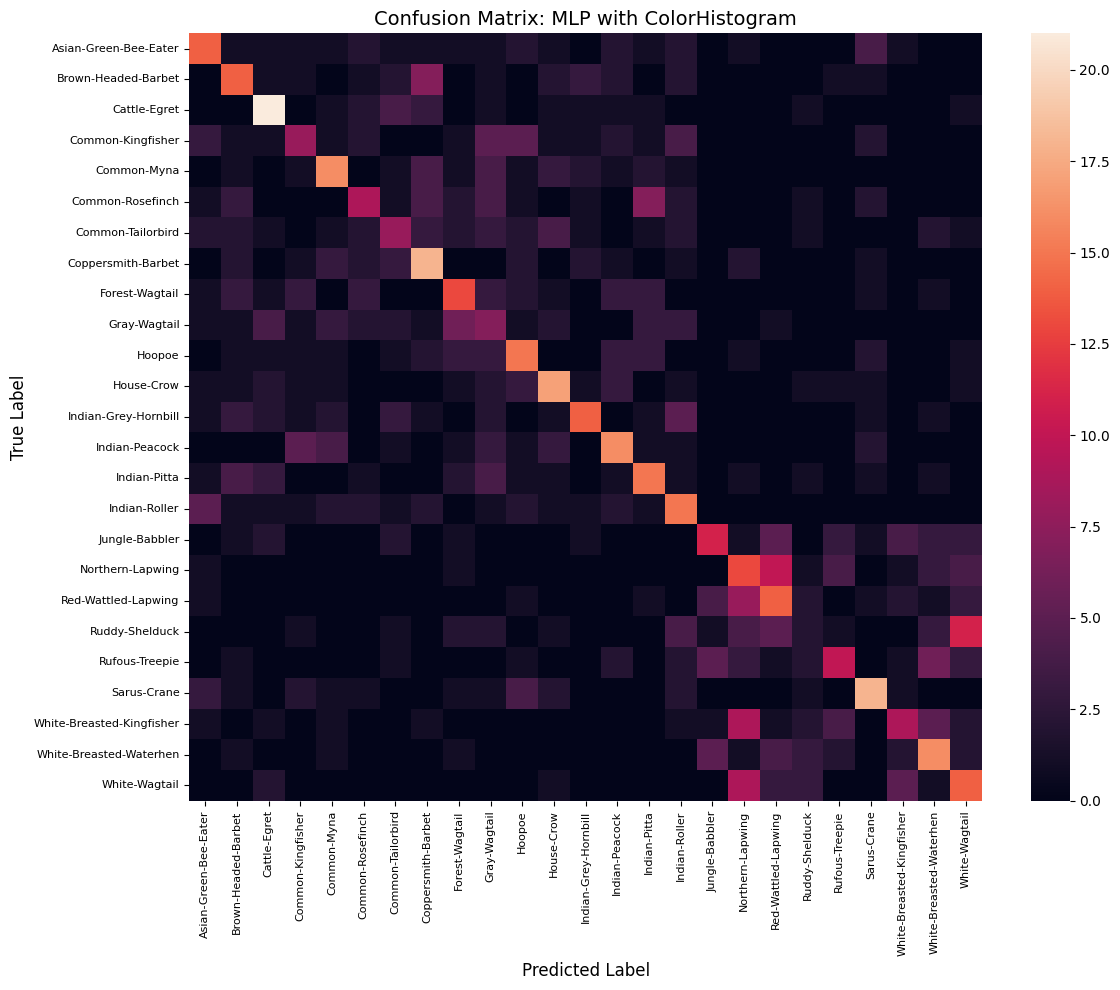


--- Training models on Feature Set: HOG ---
Training data shape: X: (7500, 512), y: (7500,)
Test data shape: X: (950, 512), y: (950,)
  Using SIMPLIFIED models for HOG features to manage training time.
  Training LinearSVC (using config: LinearSVC) with HOG...


c:\Users\berke\miniconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    Training LinearSVC took 85.22 seconds.
    Test Set Evaluation for LinearSVC with HOG:
Results for LinearSVC with HOG:
  Accuracy:  0.1242
  Precision: 0.1210
  Recall:    0.1242
  F1-Score:  0.1199


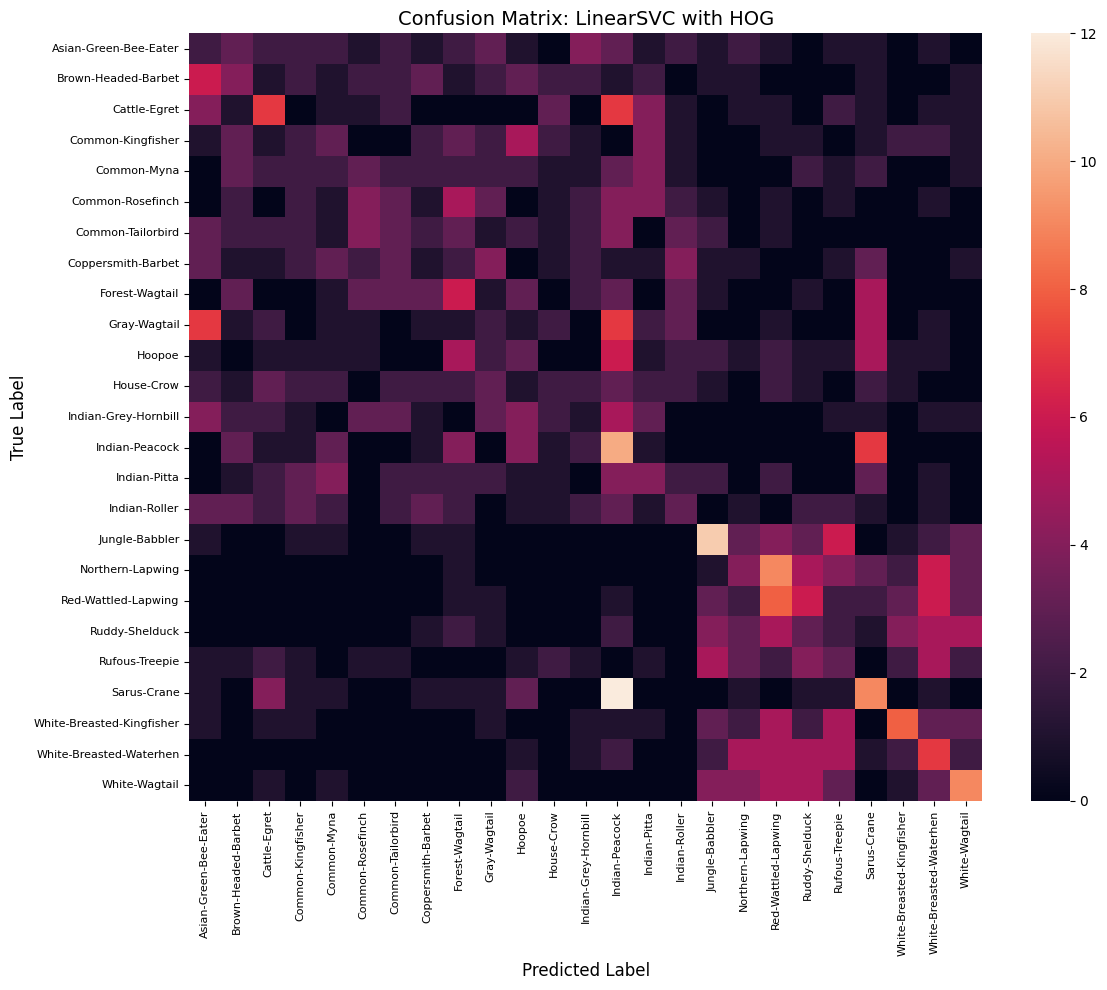

  Training RandomForest_Simple (using config: RandomForest_Simple) with HOG...
    Training RandomForest_Simple took 0.70 seconds.
    Test Set Evaluation for RandomForest_Simple with HOG:
Results for RandomForest_Simple with HOG:
  Accuracy:  0.1484
  Precision: 0.1318
  Recall:    0.1484
  F1-Score:  0.1345


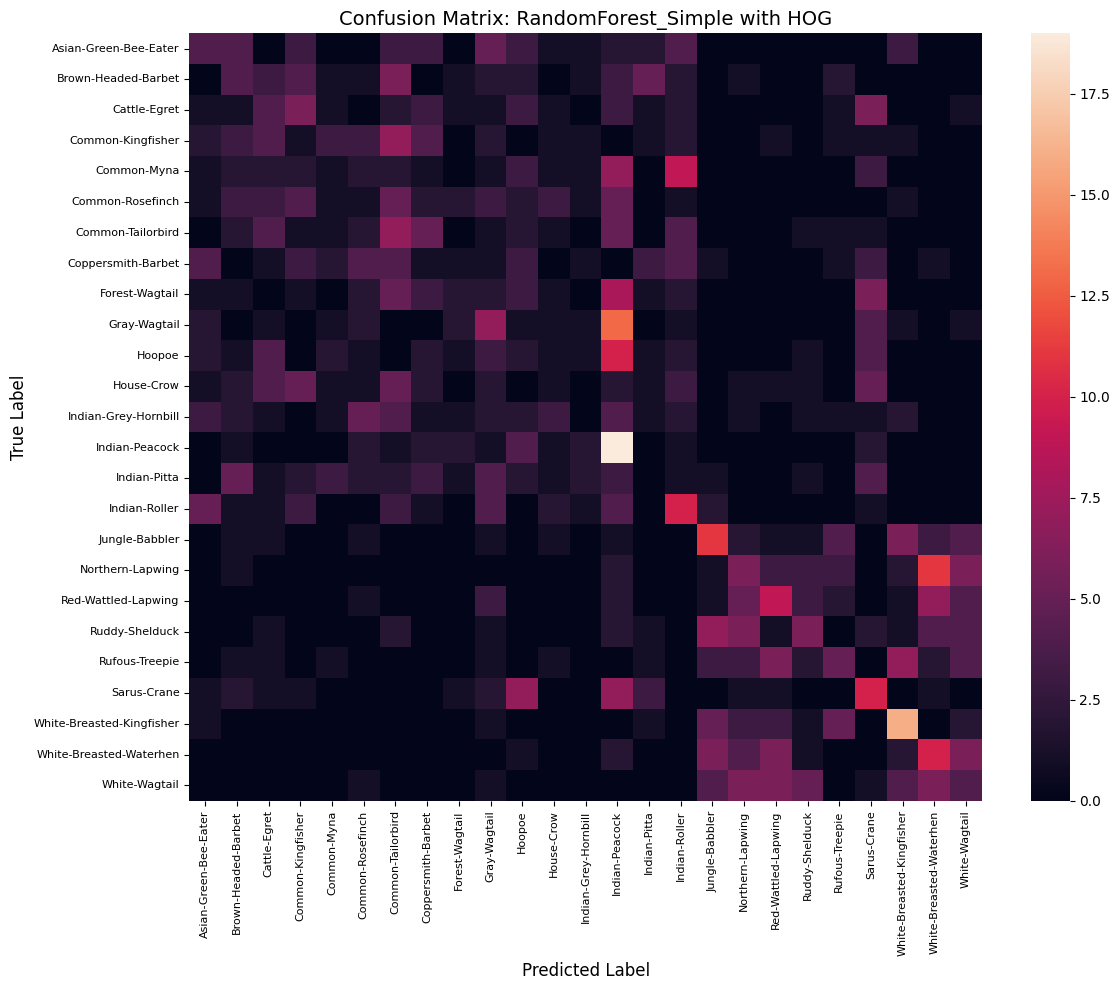

  Training MLP_Simple (using config: MLP_Simple) with HOG...
    Training MLP_Simple took 0.89 seconds.
    Test Set Evaluation for MLP_Simple with HOG:
Results for MLP_Simple with HOG:
  Accuracy:  0.1337
  Precision: 0.1297
  Recall:    0.1337
  F1-Score:  0.1277


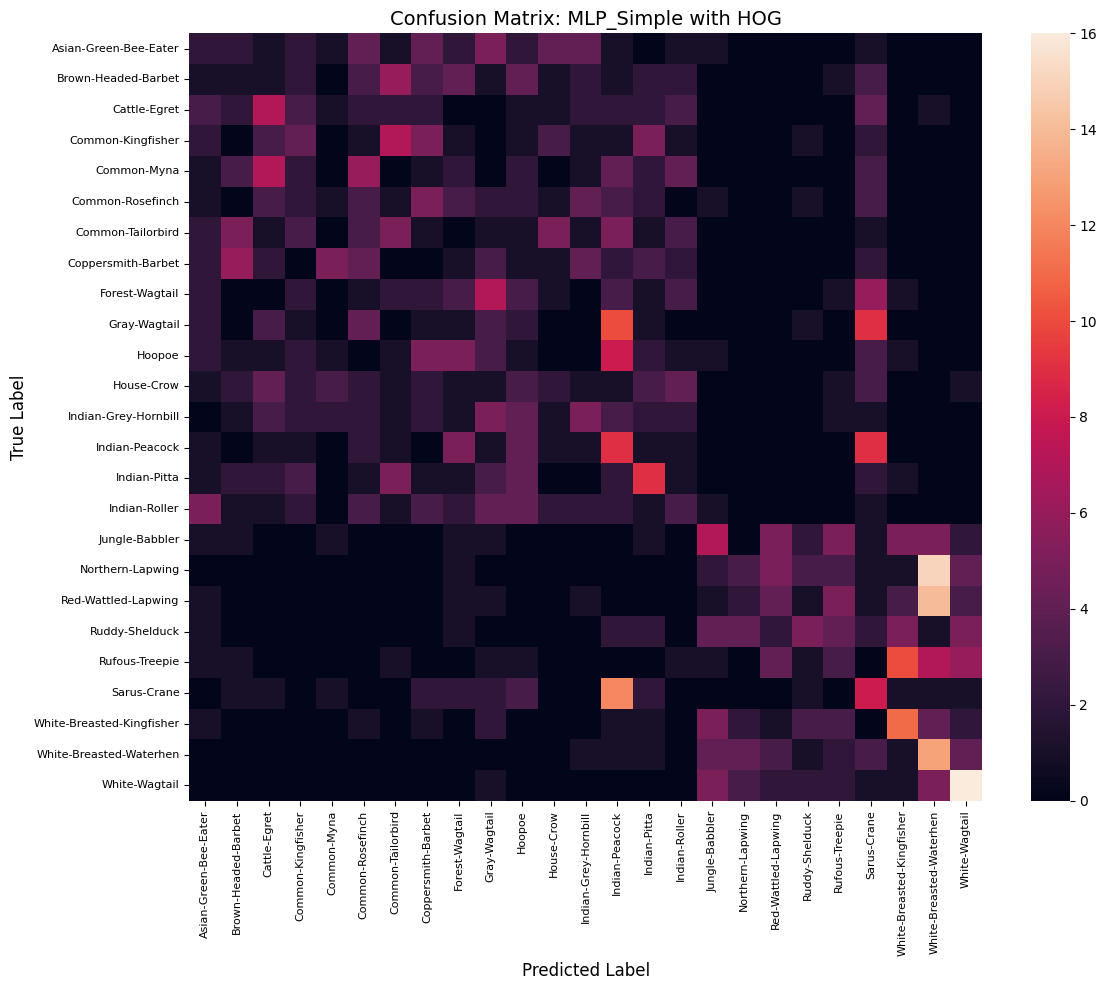


--- Training models on Feature Set: SIFT_Aggregated ---
Training data shape: X: (7500, 128), y: (7500,)
Test data shape: X: (950, 128), y: (950,)
  Training SVM_RBF (using config: SVM_RBF) with SIFT_Aggregated...
    Training SVM_RBF took 14.87 seconds.
    Test Set Evaluation for SVM_RBF with SIFT_Aggregated:
Results for SVM_RBF with SIFT_Aggregated:
  Accuracy:  0.2526
  Precision: 0.2478
  Recall:    0.2526
  F1-Score:  0.2432


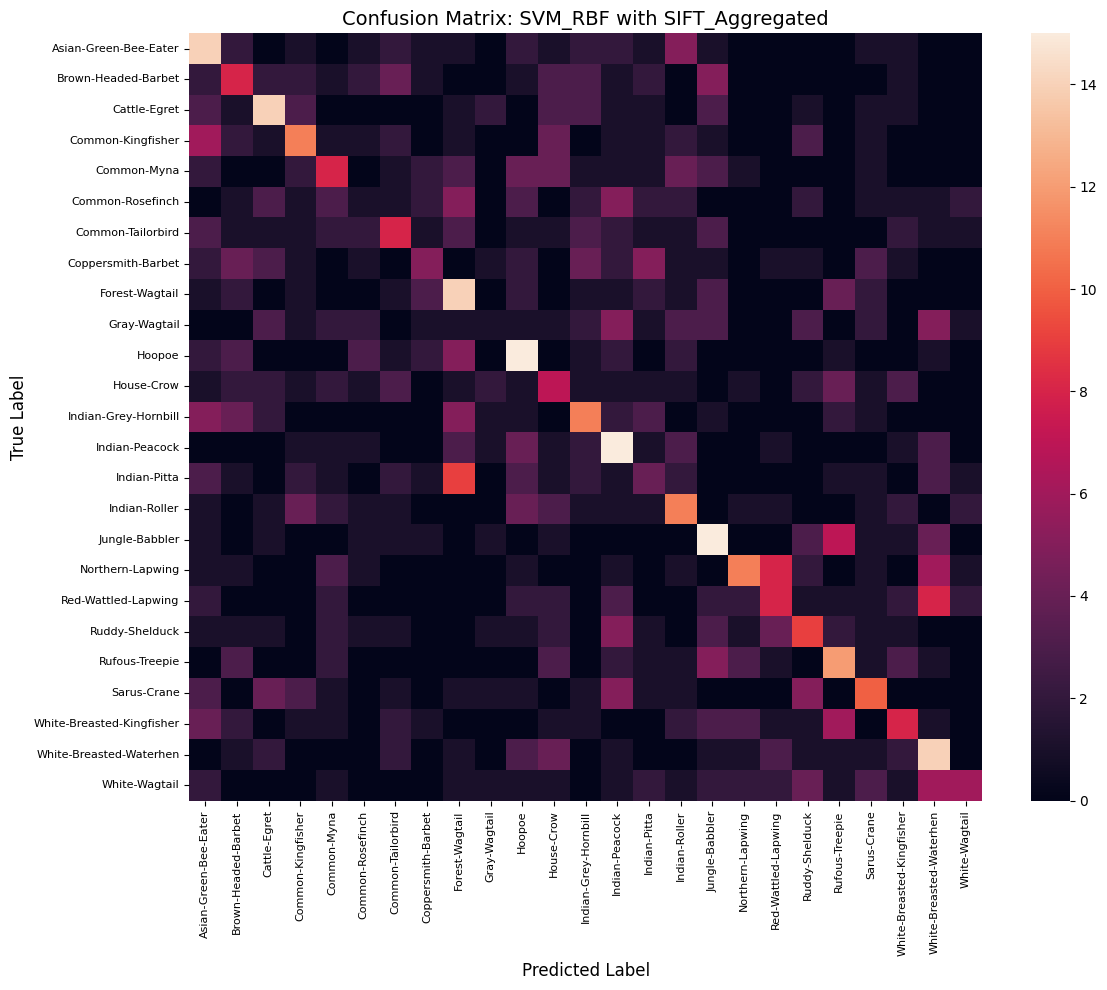

  Training RandomForest (using config: RandomForest_Std) with SIFT_Aggregated...
    Training RandomForest took 1.13 seconds.
    Test Set Evaluation for RandomForest with SIFT_Aggregated:
Results for RandomForest with SIFT_Aggregated:
  Accuracy:  0.1905
  Precision: 0.1791
  Recall:    0.1905
  F1-Score:  0.1783


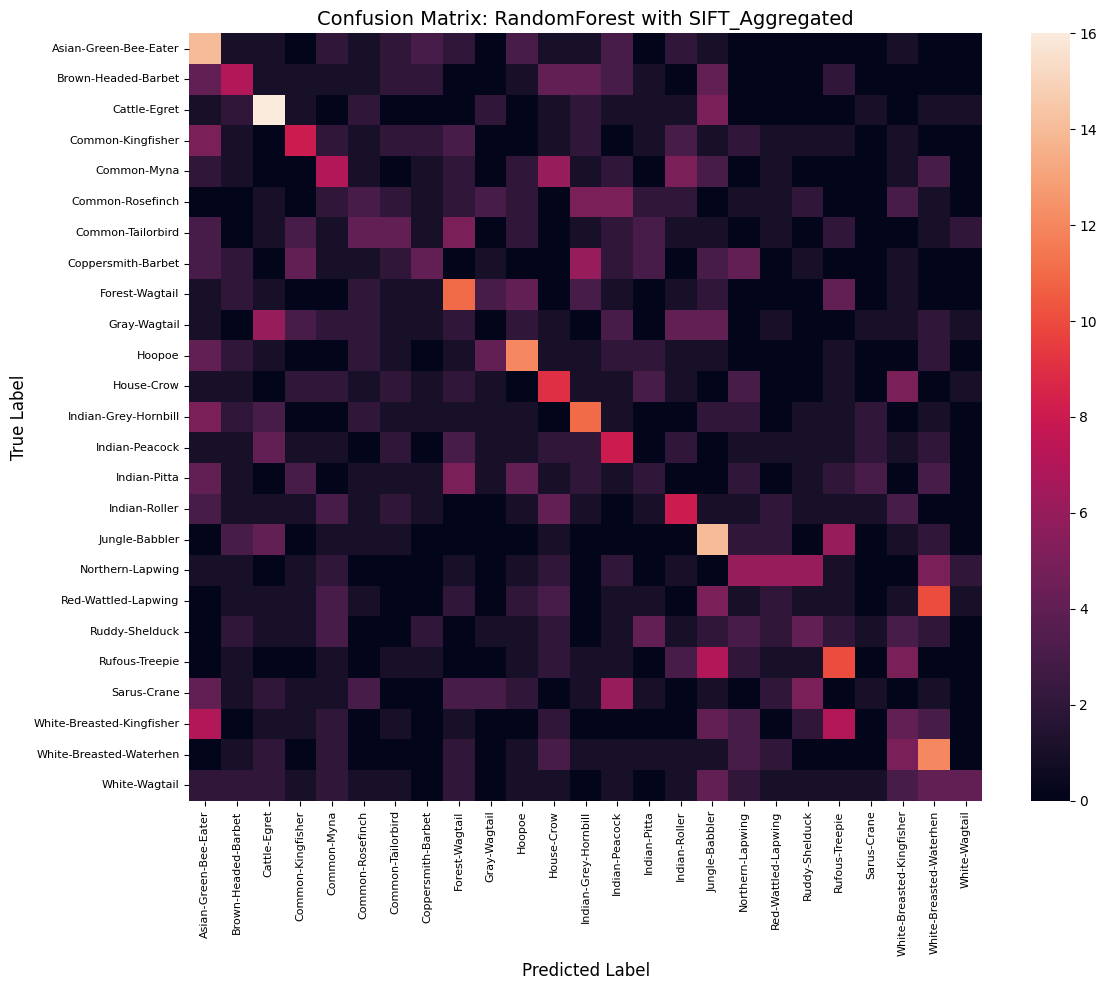

  Training MLP (using config: MLP_Std) with SIFT_Aggregated...
    Training MLP took 3.84 seconds.
    Test Set Evaluation for MLP with SIFT_Aggregated:
Results for MLP with SIFT_Aggregated:
  Accuracy:  0.2274
  Precision: 0.2219
  Recall:    0.2274
  F1-Score:  0.2171


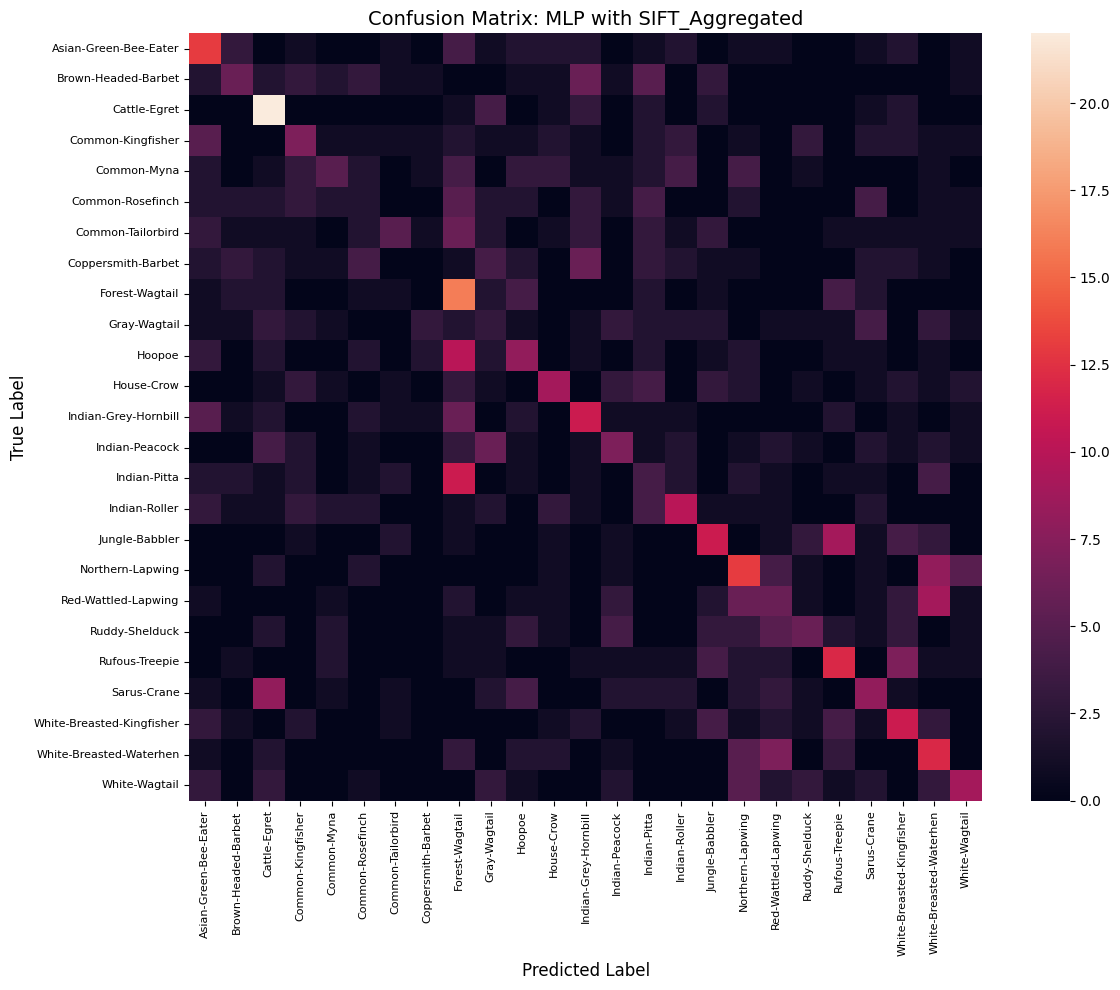

In [25]:
for feature_name_iter, (X_train_feat, y_train_target) in all_extracted_features['train'].items():
    print(f"\n--- Training models on Feature Set: {feature_name_iter} ---")

    if X_train_feat.size == 0 or y_train_target.size == 0:
        print(f"  Skipping {feature_name_iter} as training features or labels are empty.")
        continue

    print(f"Training data shape: X: {X_train_feat.shape}, y: {y_train_target.shape}")

    # test set
    if feature_name_iter not in all_extracted_features.get('test', {}) or all_extracted_features['test'][feature_name_iter][0].size == 0:
        print(f"  Test features for {feature_name_iter} not found or empty. Skipping.")
        continue

    X_test_feat, y_test_target = all_extracted_features['test'][feature_name_iter]
    if X_test_feat.size == 0 or y_test_target.size == 0:
        print(f"  Skipping {feature_name_iter} as test features or labels are empty.")
        continue

    print(f"Test data shape: X: {X_test_feat.shape}, y: {y_test_target.shape}")

    # features are 2D
    if X_train_feat.ndim == 1: 
        X_train_feat = X_train_feat.reshape(-1, 1)
    if X_test_feat.ndim == 1: 
        X_test_feat = X_test_feat.reshape(-1, 1)
        
    # select models
    models_to_run_now = {}
    if feature_name_iter == feature_name_hog: # Use the simplified models for HOG
        print(f"  Using SIMPLIFIED models for HOG features to manage training time.")
        models_to_run_now = models_to_try_part1_for_hog
    else:
        models_to_run_now = models_to_try_part1_standard
    
    for model_name_from_dict, model_pipeline in models_to_run_now.items():
        log_model_name = model_name_from_dict.split('_HOG')[0] if '_HOG' in model_name_from_dict else model_name_from_dict.split('_Std')[0]
        
        print(f"  Training {log_model_name} (using config: {model_name_from_dict}) with {feature_name_iter}...")
        
        start_time = time.time()
        try:
            model_pipeline.fit(X_train_feat, y_train_target)
            end_time = time.time()
            print(f"    Training {log_model_name} took {end_time - start_time:.2f} seconds.")
            
            y_pred_test = model_pipeline.predict(X_test_feat)
            
            print(f"    Test Set Evaluation for {log_model_name} with {feature_name_iter}:")
            # Use the base model name (e.g., "LinearSVC", "SVM") for the results_accumulator
            evaluate_and_log_model(log_model_name, feature_name_iter, y_test_target, y_pred_test, class_names, part1_results_list)
                
        except Exception as e:
            print(f"    ERROR training/evaluating {log_model_name} (config: {model_name_from_dict}) with {feature_name_iter}: {e}")
            import traceback
            traceback.print_exc() # full traceback for debugging



In [26]:
# summary of part 1 results
if part1_results_list:
    part1_results_df = pd.DataFrame(part1_results_list)
    print("\n\n--- Summary of Part 1 Results (Test Set) ---")
    # all columns are displayed
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(part1_results_df)
else:
    print("No models were trained in Part 1, or no results were collected.")



--- Summary of Part 1 Results (Test Set) ---
        FeatureSet                Model  Accuracy  Precision    Recall  F1-Score
0   ColorHistogram              SVM_RBF  0.250526   0.258155  0.250526  0.243973
1   ColorHistogram         RandomForest  0.446316   0.452104  0.446316  0.443244
2   ColorHistogram                  MLP  0.344211   0.343839  0.344211  0.340249
3              HOG            LinearSVC  0.124211   0.120996  0.124211  0.119875
4              HOG  RandomForest_Simple  0.148421   0.131791  0.148421  0.134486
5              HOG           MLP_Simple  0.133684   0.129697  0.133684  0.127685
6  SIFT_Aggregated              SVM_RBF  0.252632   0.247826  0.252632  0.243216
7  SIFT_Aggregated         RandomForest  0.190526   0.179114  0.190526  0.178253
8  SIFT_Aggregated                  MLP  0.227368   0.221941  0.227368  0.217109


#### **Comments on Part 1 Results**
In this initial part of the assignment, we explored traditional machine learning approaches by extracting three distinct types of features from the bird images: Color Histograms, Histogram of Oriented Gradients (HOG), and aggregated Scale-Invariant Feature Transform (SIFT) descriptors. These features were then used to train different classifiers: Support Vector Machine (SVM) with RBF kernel (or LinearSVC for HOG), Random Forest (standard or simplified for HOG), and Multilayer Perceptron (MLP, standard or simplified for HOG). The performance metrics on the test set are summarized in the table above and discussed below.

* **Color Histogram:**
    * The **Random Forest** classifier achieved the best performance with Color Histogram features, yielding an **Accuracy of 44.63%** and an F1-Score of 44.32%.
    * The **MLP** followed with **34.42%** accuracy, while the **SVM (RBF)** performed the lowest with **25.05%** accuracy.
    * **Discussion:** Color Histograms capture global color distributions. The significantly better performance of Random Forest suggests it was more adept at finding patterns within these color distributions compared to SVM or MLP for this feature type. However, an accuracy of ~45% for a 25-class problem indicates that color alone, while providing some signal, is not sufficient for robust bird species identification, likely due to many species sharing similar color palettes and the feature's lack of spatial or textural information.

* **HOG Features:**
    * With HOG features, the performance was notably lower across all simplified models used (LinearSVC, RandomForest\_Simple, MLP\_Simple). The **RandomForest\_Simple** model performed best among these, but only achieved an **Accuracy of 14.84%** and an **F1-Score of 13.45%**.
    * **LinearSVC** and **MLP\_Simple** yielded accuracies of **12.42%** and **13.37%**, respectively.
    * **Discussion:** HOG features are designed to capture shape and texture by encoding gradient orientations. The unexpectedly low performance here, even with simplified models, is surprising given HOG's usual effectiveness. Several factors could contribute:
        * The HOG parameters used might not have been optimal for capturing the distinguishing features of the bird species at the chosen image resolution.
        * The simplification of the models specifically for HOG might have been too aggressive, preventing them from learning effectively even from potentially good features.
        * The high dimensionality of HOG features (if not sufficiently reduced by parameter choices) can still be challenging, even for linear models or simpler MLPs, if the signal-to-noise ratio is poor or if the chosen subset of data didn't capture the feature space well.
        * It's also possible that for bird species, global shape captured by these HOG parameters is less discriminative than fine-grained textures or very specific local patterns that the chosen HOG configuration did not emphasize. The results here are significantly worse than with Color Histograms, suggesting a potential issue in either the feature representation itself for this specific task or the models' ability to utilize these specific HOG features.

* **SIFT (Aggregated) Features:**
    * For aggregated SIFT features, the **SVM (RBF)** performed best with an **Accuracy of 25.26%** and an **F1-Score of 24.32%**.
    * The **MLP** achieved **22.74%** accuracy, and **Random Forest** performed the poorest at **19.05%**.
    * **Discussion:** Aggregated SIFT features aim to capture local invariant keypoints. The performance, while modest, was slightly better than HOG in this instance (when comparing best models for each). The simple averaging of SIFT descriptors likely leads to a significant loss of discriminative information. A Bag of Visual Words (BoVW) approach would generally be expected to perform better by creating a more structured representation (a visual vocabulary). The fixed 128-dimension vector from averaging was computationally manageable, but its representational power seems limited for this complex task, similar to the Color Histogram.


##### **Overall Comparison for Part 1:**
* Across all traditional feature sets and classifiers explored in Part 1, the **Color Histogram feature combined with the Random Forest classifier** yielded the highest accuracy, reaching **44.63%**.
* This result is somewhat counter-intuitive, as HOG or SIFT features are often expected to outperform simple color histograms in image classification tasks due to their ability to capture more complex structural or local information. The poor performance of HOG, in particular, warrants further investigation, potentially revisiting HOG parameter settings or the complexity of the models applied to it.
* The SIFT (Aggregated) features performed similarly to the Color Histogram with an SVM, but Random Forest did not generalize well with SIFT.
* The overall modest accuracies (with the **maximum at 44.63%** for a 25-class problem) highlight the significant challenges of this fine-grained visual categorization task using these traditional, hand-crafted feature extraction methods. They struggle to capture the nuanced differences between species and handle variations in pose, lighting, and scale effectively. These results serve as an important baseline and motivate the exploration of more powerful deep learning techniques in subsequent parts of the assignment.


## Part 2: Principal Component Analysis and Feature Selection

To improve model performance and reduce overfitting, two techniques were applied to the extracted features:

- **PCA (Principal Component Analysis):**  
  A dimensionality reduction technique that transforms the original features into a new set of uncorrelated components ranked by the amount of variance they capture from the data. PCA helps reduce noise and redundancy without using class labels.

- **Feature Selection (Elimination):**  
  **SelectKBest with `f_classif`:**  
  A univariate feature selection method that selects the top `k` features based on the ANOVA F-value, which measures the linear dependency between the feature and the class label. This method eliminates less informative features, improving learning efficiency and potentially model accuracy.

After applying both techniques separately, the same machine learning models (SVM, Random Forest, and MLP) were retrained and evaluated. Results were compared with the original models from Part 1 and between the PCA and feature selection approaches in Part 2.


In [27]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

part2_results_list = []
N_COMPONENTS_PCA = 0.95 # Keep components explaining 95% of variance, or set an integer

In [28]:
# --- Principal Component Analysis ---
def pca(X_train_orig, X_val_orig, X_test_orig):        
    # scale data before PCA
    scaler_pca = StandardScaler()
    X_train_scaled_pca = scaler_pca.fit_transform(X_train_orig)
    X_val_scaled_pca = scaler_pca.transform(X_val_orig) # train's scaler
    X_test_scaled_pca = scaler_pca.transform(X_test_orig)  # train's scaler

    # Determine n_components for PCA if it's a float (variance explained)
    # Ensure n_components is less than min(n_samples, n_features)
    current_n_components_pca = N_COMPONENTS_PCA
    if isinstance(N_COMPONENTS_PCA, float) and N_COMPONENTS_PCA < 1.0:
        # If it's a float, it's variance. It will pick components.
        pass 
    elif isinstance(N_COMPONENTS_PCA, int):
        current_n_components_pca = min(N_COMPONENTS_PCA, X_train_scaled_pca.shape[0], X_train_scaled_pca.shape[1])
    else: # Default to a safe number if not float or int
        current_n_components_pca = min(100, X_train_scaled_pca.shape[0], X_train_scaled_pca.shape[1])
    
    if current_n_components_pca <=0: 
        current_n_components_pca = 1 # must be at least 1

    if X_train_scaled_pca.shape[1] < 2: # Not enough features for PCA reduction in some cases
        print(f"    Skipping PCA for {feature_name_iter} as it has < 2 features ({X_train_scaled_pca.shape[1]}). Using scaled original.")
        X_train_pca, X_val_pca, X_test_pca = X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca
    else:
        # If current_n_components_pca (int) is > features, PCA will use n_features
        if isinstance(current_n_components_pca, int) and current_n_components_pca > X_train_scaled_pca.shape[1]:
            current_n_components_pca = X_train_scaled_pca.shape[1]
        
        pca = PCA(n_components=current_n_components_pca, random_state=42)
        try:
            X_train_pca = pca.fit_transform(X_train_scaled_pca)
            X_val_pca = pca.transform(X_val_scaled_pca)
            X_test_pca = pca.transform(X_test_scaled_pca)
            print(f"    PCA applied. Original dim: {X_train_scaled_pca.shape[1]}, Reduced dim: {X_train_pca.shape[1]}")
        except ValueError as e_pca:
            print(f"    Error applying PCA for {feature_name_iter}: {e_pca}. Using scaled original features.")
            X_train_pca, X_val_pca, X_test_pca = X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca
    return X_train_pca, X_val_pca, X_test_pca

In [29]:
# --- Feature Selection with SelectKBest ---
def select_feature_attribute(X_train_orig, X_val_orig, X_test_orig, y_train_orig):
    num_original_features = X_train_orig.shape[1]
    if num_original_features < 2:
        print(f"    Skipping SelectKBest for {feature_name_iter} as it has < 2 features ({num_original_features}). Using original.")
        X_train_skb, X_val_skb, X_test_skb = X_train_orig, X_val_orig, X_test_orig
    else:
        k_features = max(1, min(num_original_features // 2, 100)) # e.g., 50% of features, capped at 100, at least 1
        if num_original_features <= k_features: # if already few features, use all
            print(f"    Number of features ({num_original_features}) is less than or equal to k={k_features}. Using all original features for SKB step.")
            X_train_skb, X_val_skb, X_test_skb = X_train_orig, X_val_orig, X_test_orig 
        else:
            selector_skb = SelectKBest(score_func=f_classif, k=k_features)
            try:
                X_train_skb = selector_skb.fit_transform(X_train_orig, y_train_orig)
                X_val_skb = selector_skb.transform(X_val_orig)
                X_test_skb = selector_skb.transform(X_test_orig)
                print(f"    SelectKBest applied. Original dim: {num_original_features}, Reduced dim: {X_train_skb.shape[1]}")
            except ValueError as e_skb:
                print(f"    Error applying SelectKBest for {feature_name_iter}: {e_skb}. Using original features.")
                X_train_skb, X_val_skb, X_test_skb = X_train_orig, X_val_orig, X_test_orig
    return X_train_skb, X_val_skb, X_test_skb

In [30]:
def train_models(data_processor_str, X_train, X_test, y_train_orig, y_test_orig):
    for model_name_iter, model_pipeline in models_to_try_part1_standard.items():
        print(f"    Training {model_name_iter} with {feature_name_iter}_{data_processor_str}...")
        start_time = time.time()
        try:
            model_pipeline.fit(X_train, y_train_orig)
            end_time = time.time()
            print(f"      Training {model_name_iter} took {end_time - start_time:.2f} seconds.")
            y_pred = model_pipeline.predict(X_test)
            evaluate_and_log_model(model_name_iter, f"{feature_name_iter}_{data_processor_str}", y_test_orig, y_pred, class_names, part2_results_list)
        except Exception as e:
            print(f"      ERROR training/evaluating {model_name_iter} with {feature_name_iter}_{data_processor_str}: {e}")


--- Processing Part 2 for Feature Set: ColorHistogram ---
  Applying PCA to ColorHistogram...
    PCA applied. Original dim: 96, Reduced dim: 55
    Training SVM_RBF with ColorHistogram_PCA...
      Training SVM_RBF took 13.44 seconds.
Results for SVM_RBF with ColorHistogram_PCA:
  Accuracy:  0.2737
  Precision: 0.2965
  Recall:    0.2737
  F1-Score:  0.2689


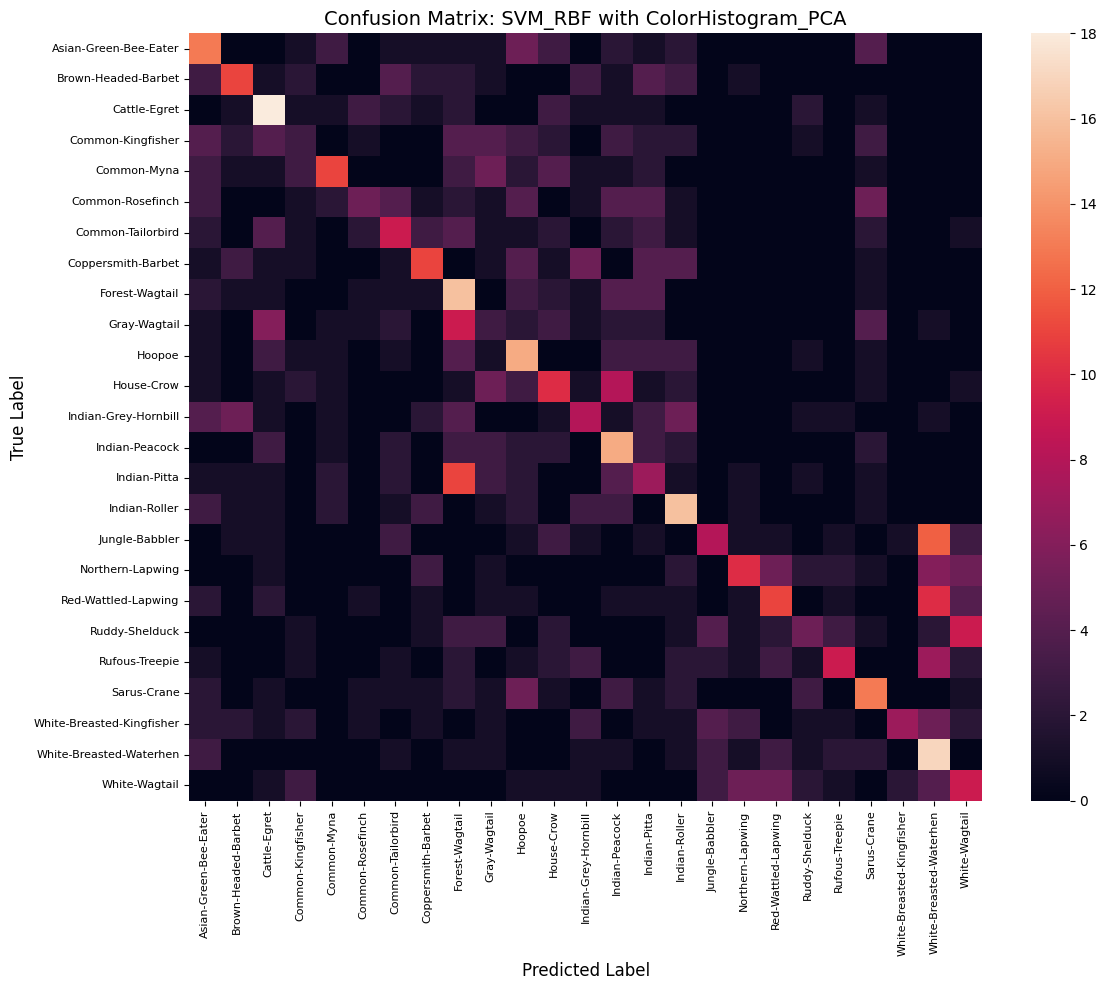

    Training RandomForest_Std with ColorHistogram_PCA...
      Training RandomForest_Std took 0.76 seconds.
Results for RandomForest_Std with ColorHistogram_PCA:
  Accuracy:  0.3695
  Precision: 0.3799
  Recall:    0.3695
  F1-Score:  0.3672


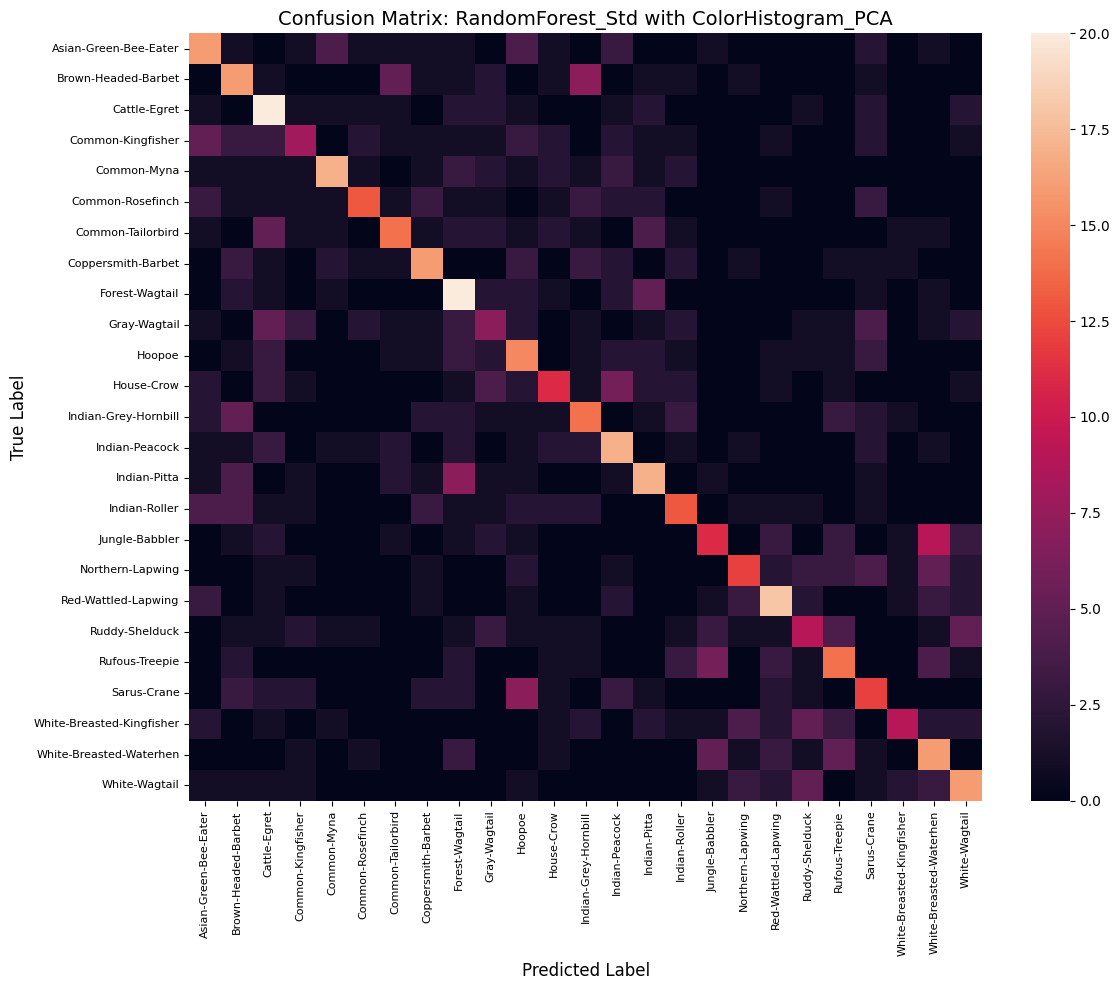

    Training MLP_Std with ColorHistogram_PCA...
      Training MLP_Std took 3.61 seconds.
Results for MLP_Std with ColorHistogram_PCA:
  Accuracy:  0.3147
  Precision: 0.3167
  Recall:    0.3147
  F1-Score:  0.3095


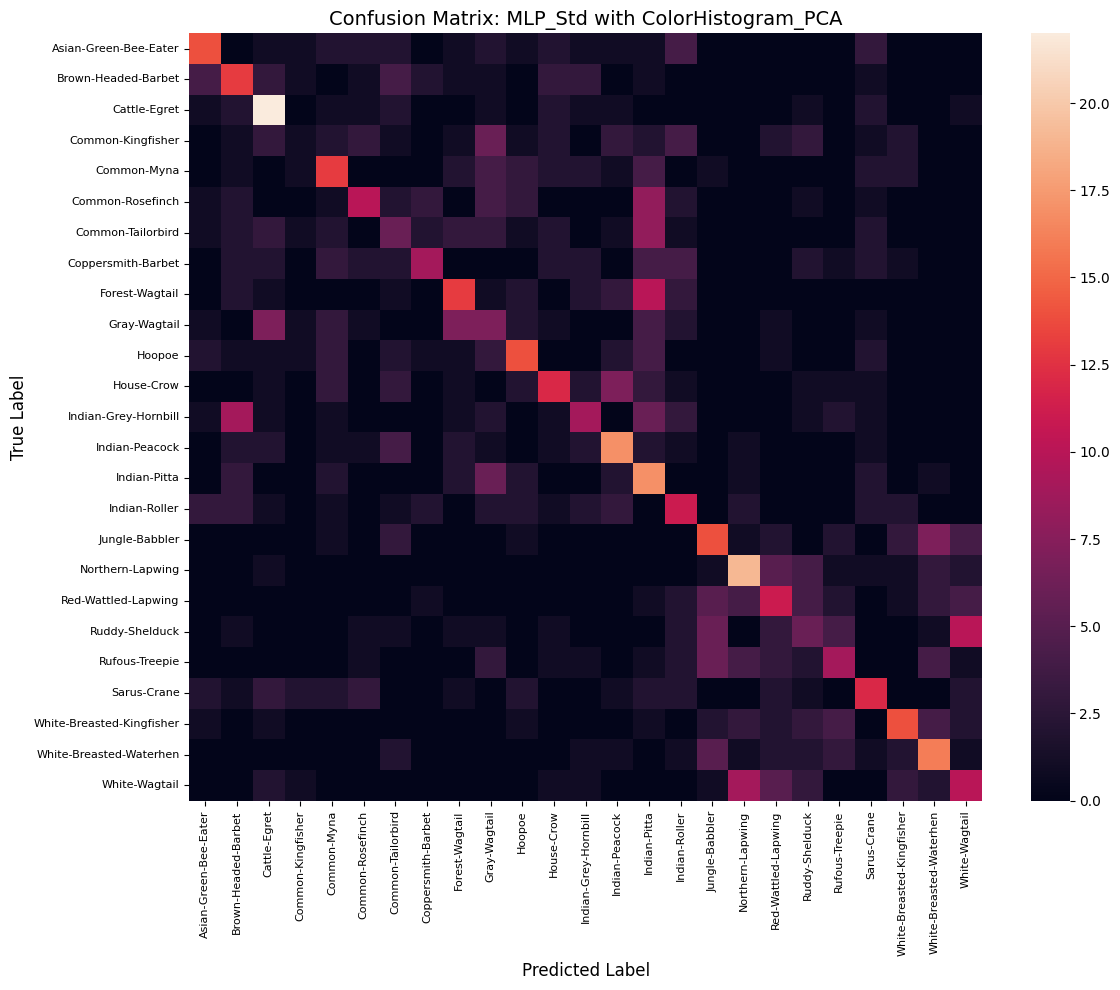


  Applying SelectKBest to ColorHistogram...
    SelectKBest applied. Original dim: 96, Reduced dim: 48
    Training SVM_RBF with ColorHistogram_SelectKBest...
      Training SVM_RBF took 9.87 seconds.
Results for SVM_RBF with ColorHistogram_SelectKBest:
  Accuracy:  0.2358
  Precision: 0.2443
  Recall:    0.2358
  F1-Score:  0.2243


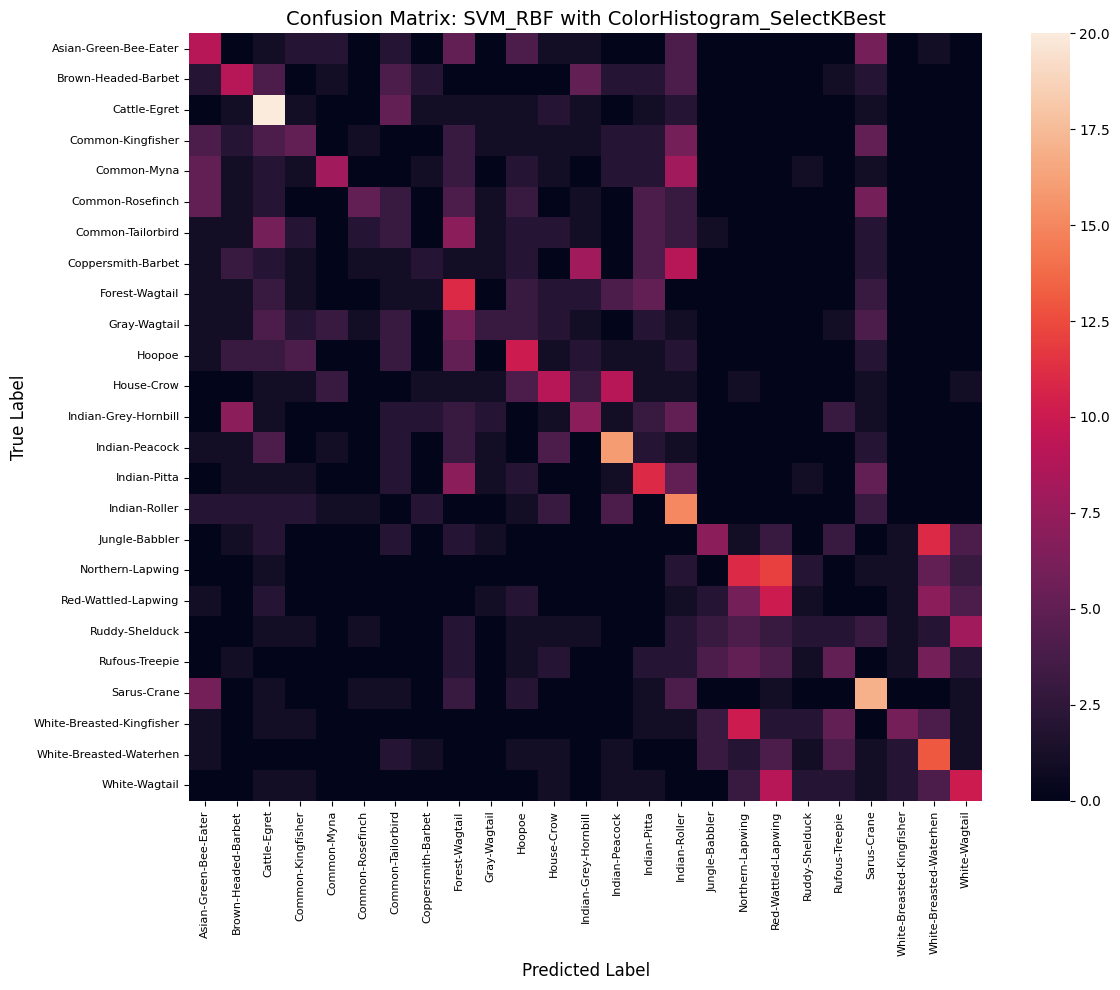

    Training RandomForest_Std with ColorHistogram_SelectKBest...
      Training RandomForest_Std took 0.62 seconds.
Results for RandomForest_Std with ColorHistogram_SelectKBest:
  Accuracy:  0.4116
  Precision: 0.4099
  Recall:    0.4116
  F1-Score:  0.4066


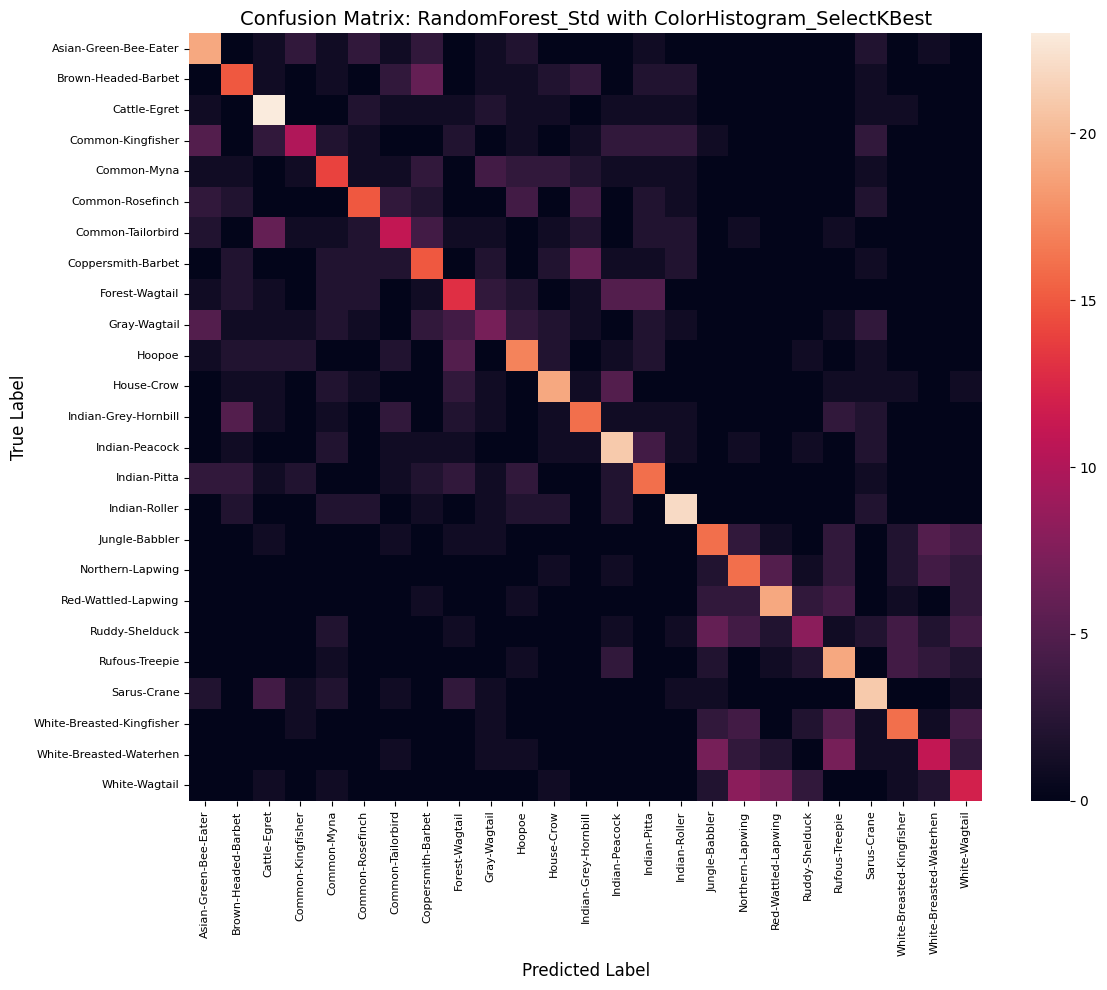

    Training MLP_Std with ColorHistogram_SelectKBest...
      Training MLP_Std took 5.30 seconds.
Results for MLP_Std with ColorHistogram_SelectKBest:
  Accuracy:  0.3000
  Precision: 0.2998
  Recall:    0.3000
  F1-Score:  0.2937


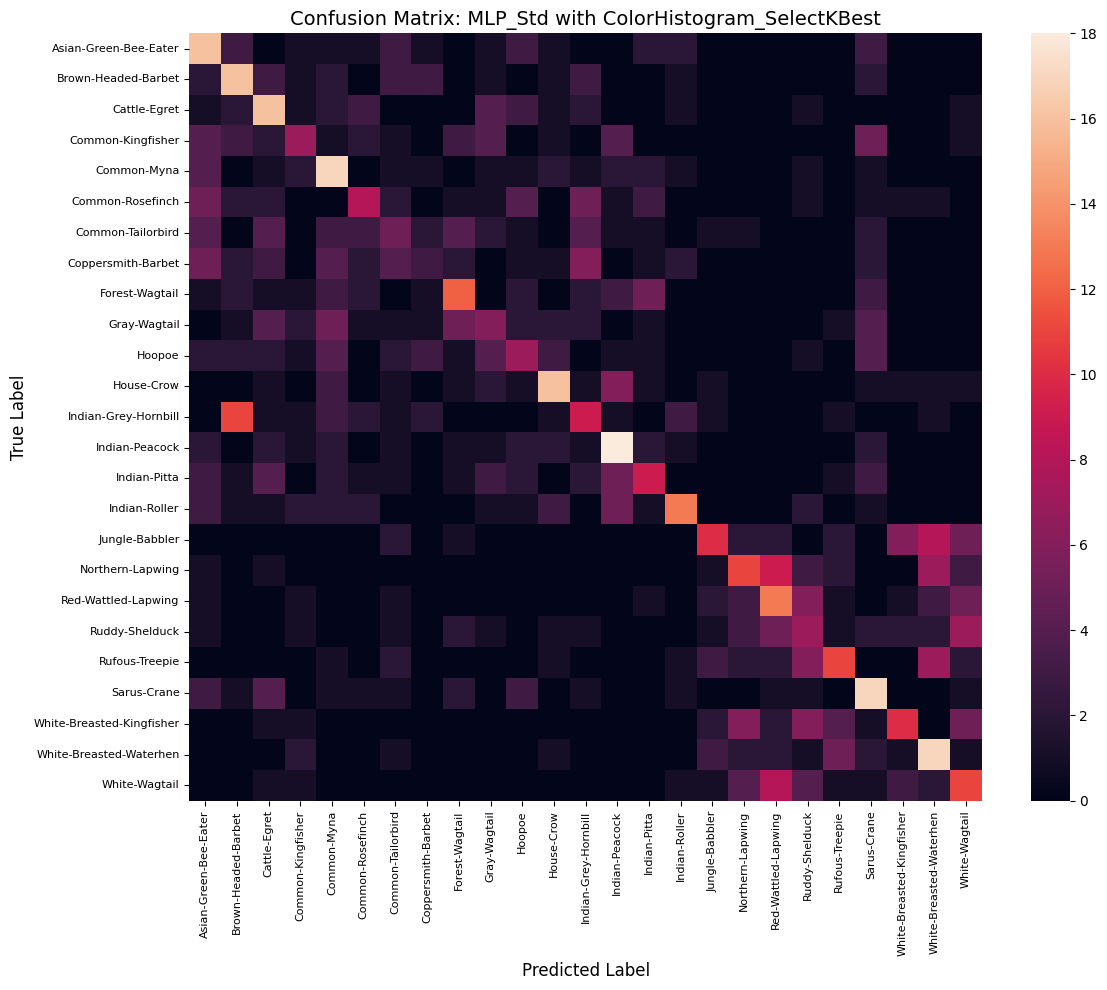


--- Processing Part 2 for Feature Set: HOG ---
  Applying PCA to HOG...
    PCA applied. Original dim: 512, Reduced dim: 373
    Training SVM_RBF with HOG_PCA...
      Training SVM_RBF took 42.31 seconds.
Results for SVM_RBF with HOG_PCA:
  Accuracy:  0.1526
  Precision: 0.1564
  Recall:    0.1526
  F1-Score:  0.1362


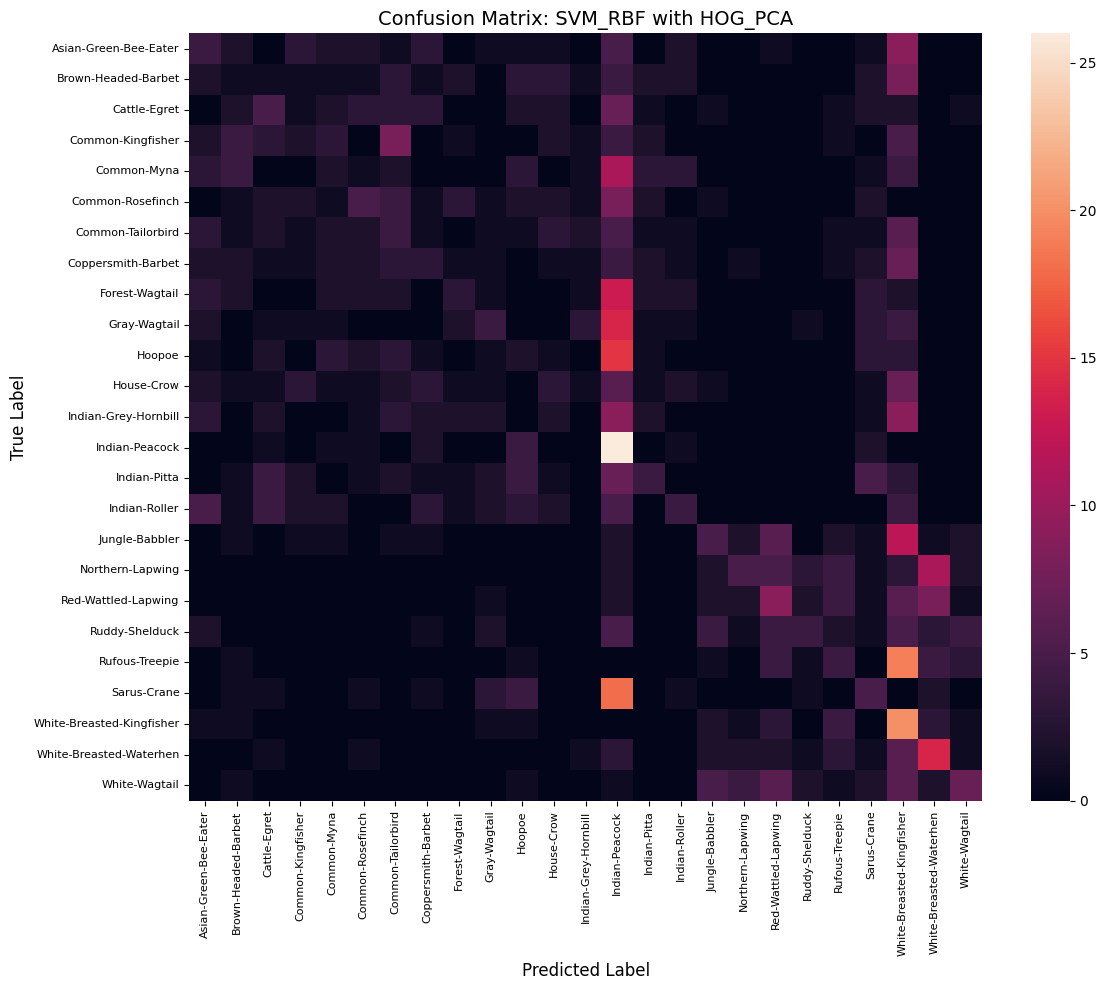

    Training RandomForest_Std with HOG_PCA...
      Training RandomForest_Std took 2.25 seconds.
Results for RandomForest_Std with HOG_PCA:
  Accuracy:  0.1253
  Precision: 0.1216
  Recall:    0.1253
  F1-Score:  0.1212


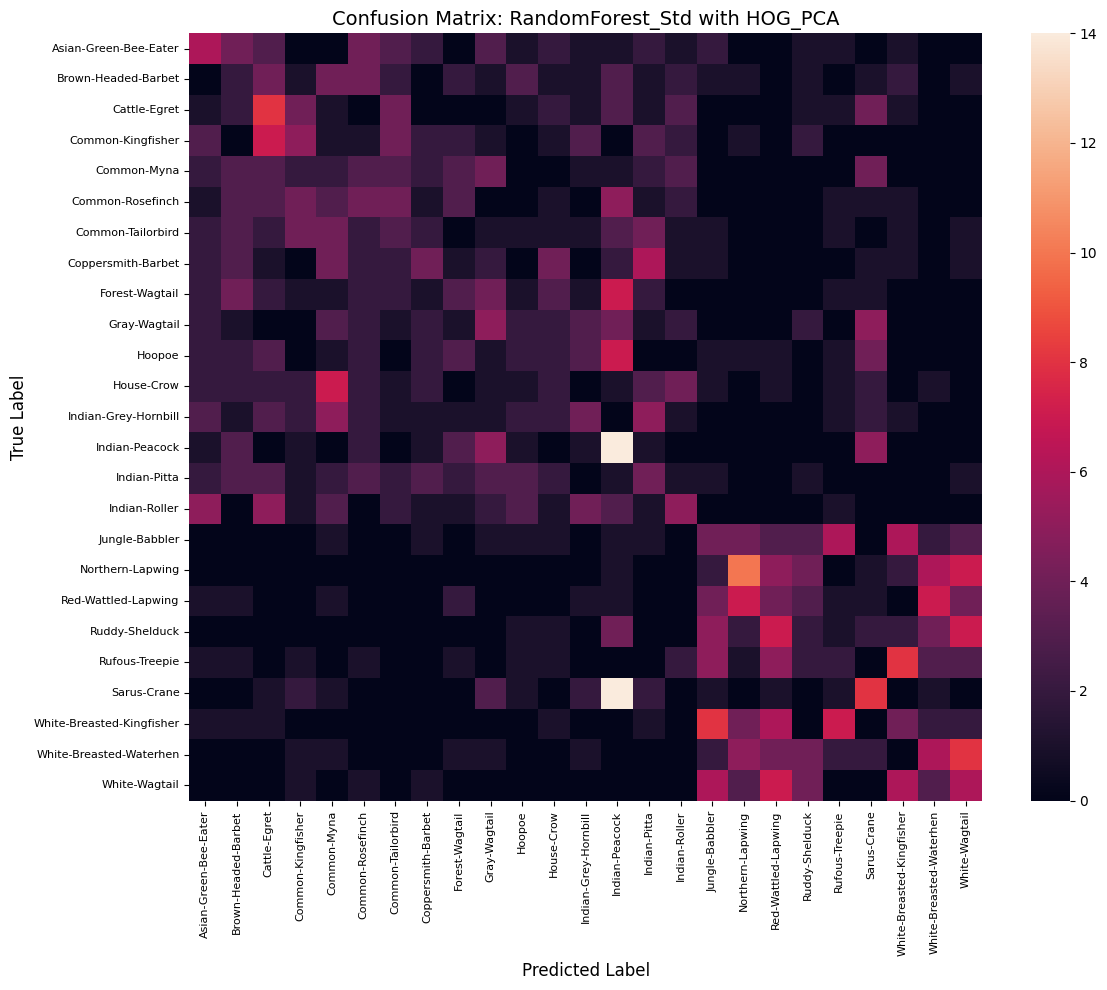

    Training MLP_Std with HOG_PCA...
      Training MLP_Std took 4.06 seconds.
Results for MLP_Std with HOG_PCA:
  Accuracy:  0.1263
  Precision: 0.1268
  Recall:    0.1263
  F1-Score:  0.1251


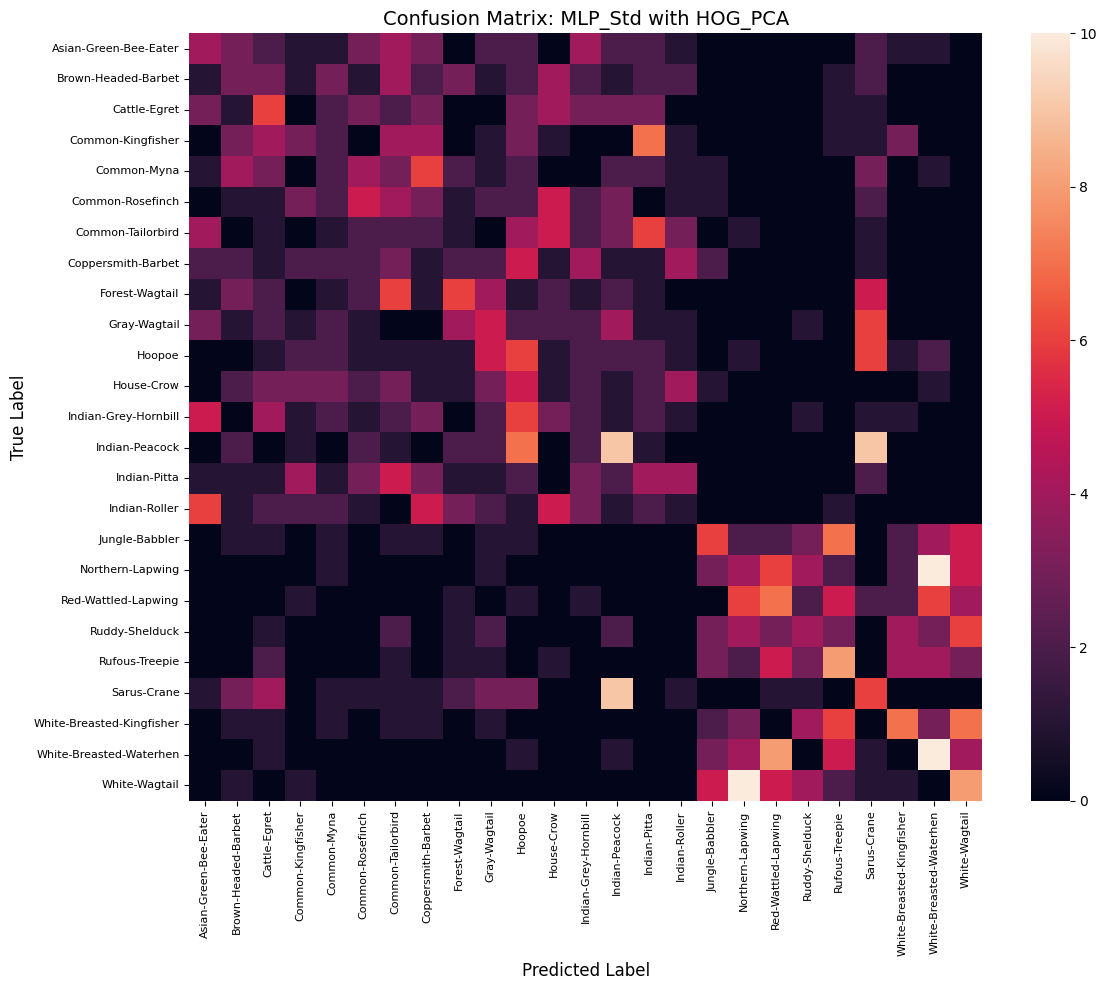


  Applying SelectKBest to HOG...
    SelectKBest applied. Original dim: 512, Reduced dim: 100
    Training SVM_RBF with HOG_SelectKBest...
      Training SVM_RBF took 14.41 seconds.
Results for SVM_RBF with HOG_SelectKBest:
  Accuracy:  0.1421
  Precision: 0.1406
  Recall:    0.1421
  F1-Score:  0.1308


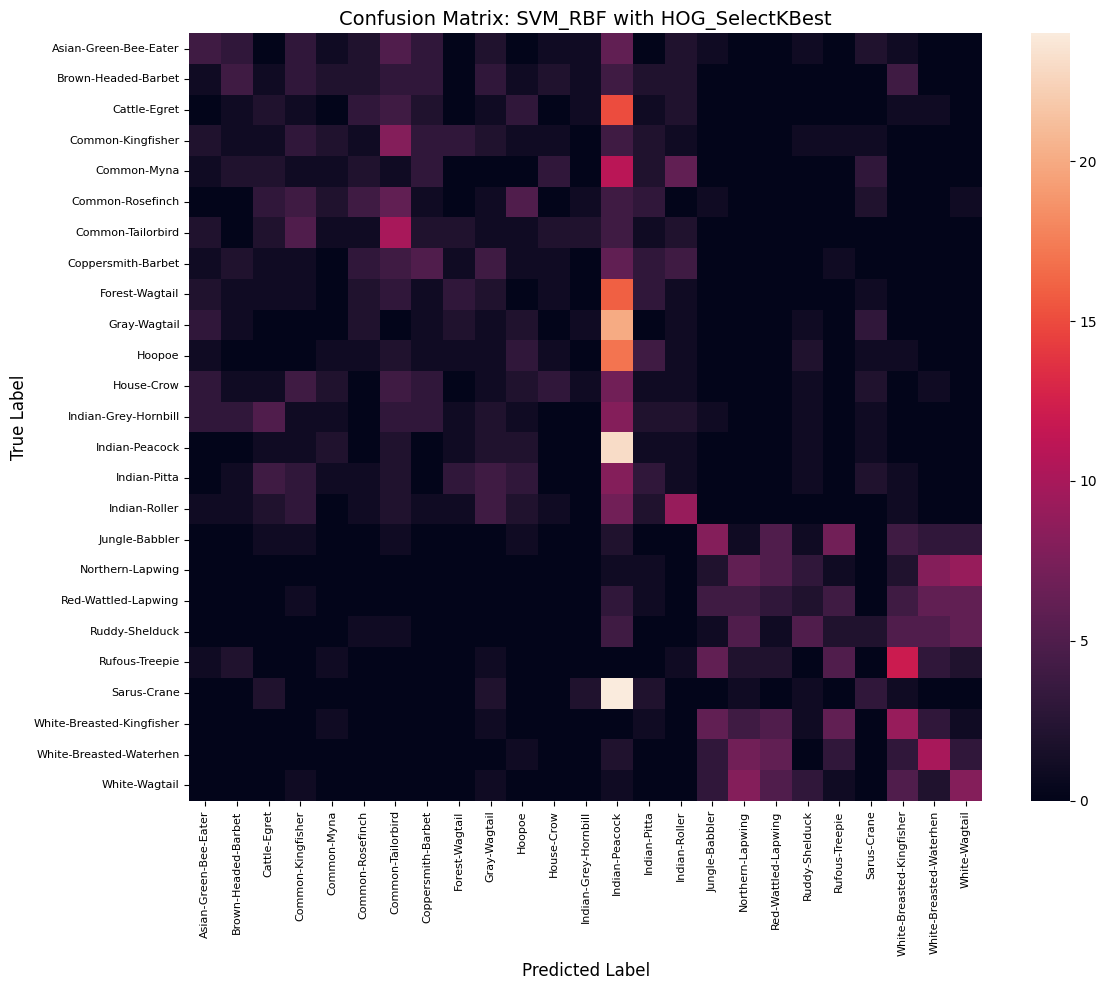

    Training RandomForest_Std with HOG_SelectKBest...
      Training RandomForest_Std took 0.97 seconds.
Results for RandomForest_Std with HOG_SelectKBest:
  Accuracy:  0.1379
  Precision: 0.1405
  Recall:    0.1379
  F1-Score:  0.1359


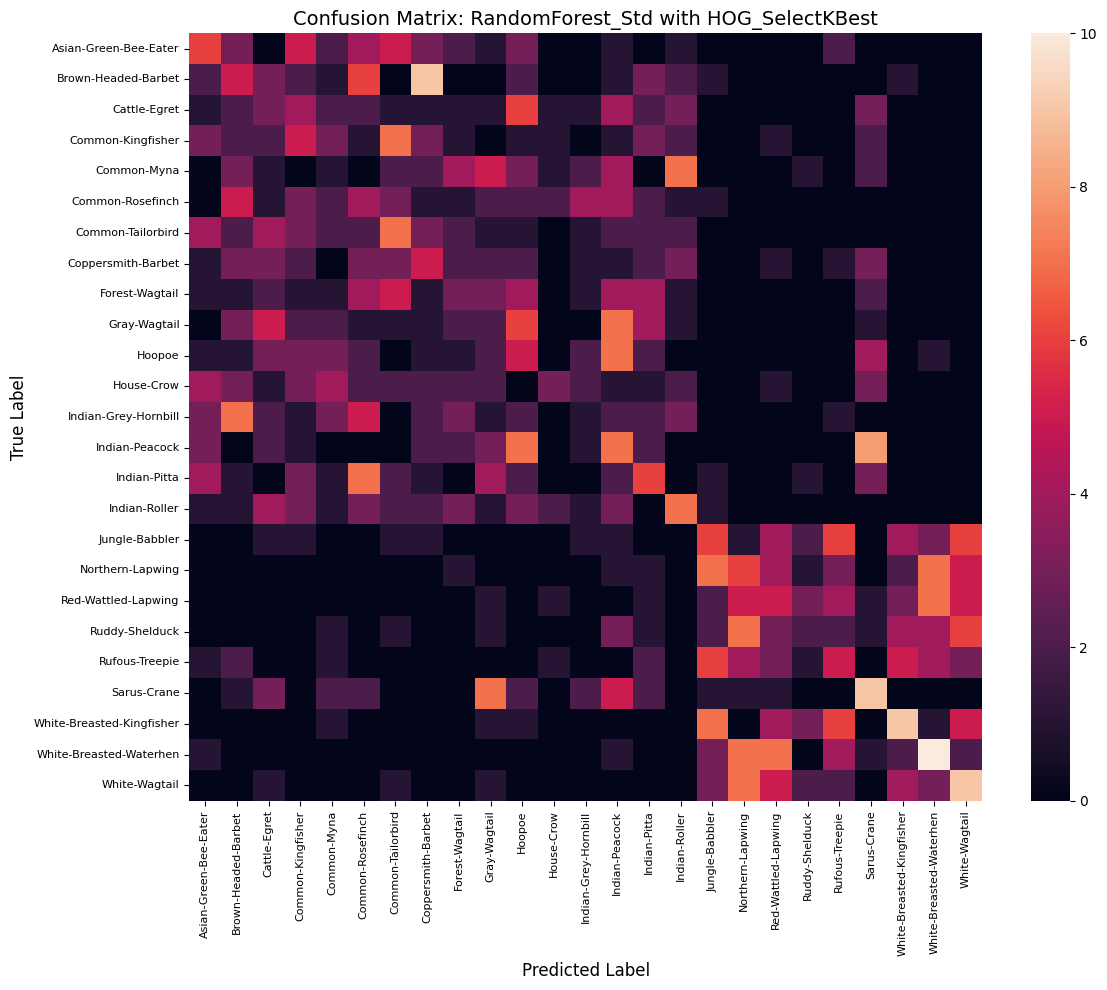

    Training MLP_Std with HOG_SelectKBest...
      Training MLP_Std took 4.67 seconds.
Results for MLP_Std with HOG_SelectKBest:
  Accuracy:  0.1242
  Precision: 0.1275
  Recall:    0.1242
  F1-Score:  0.1215


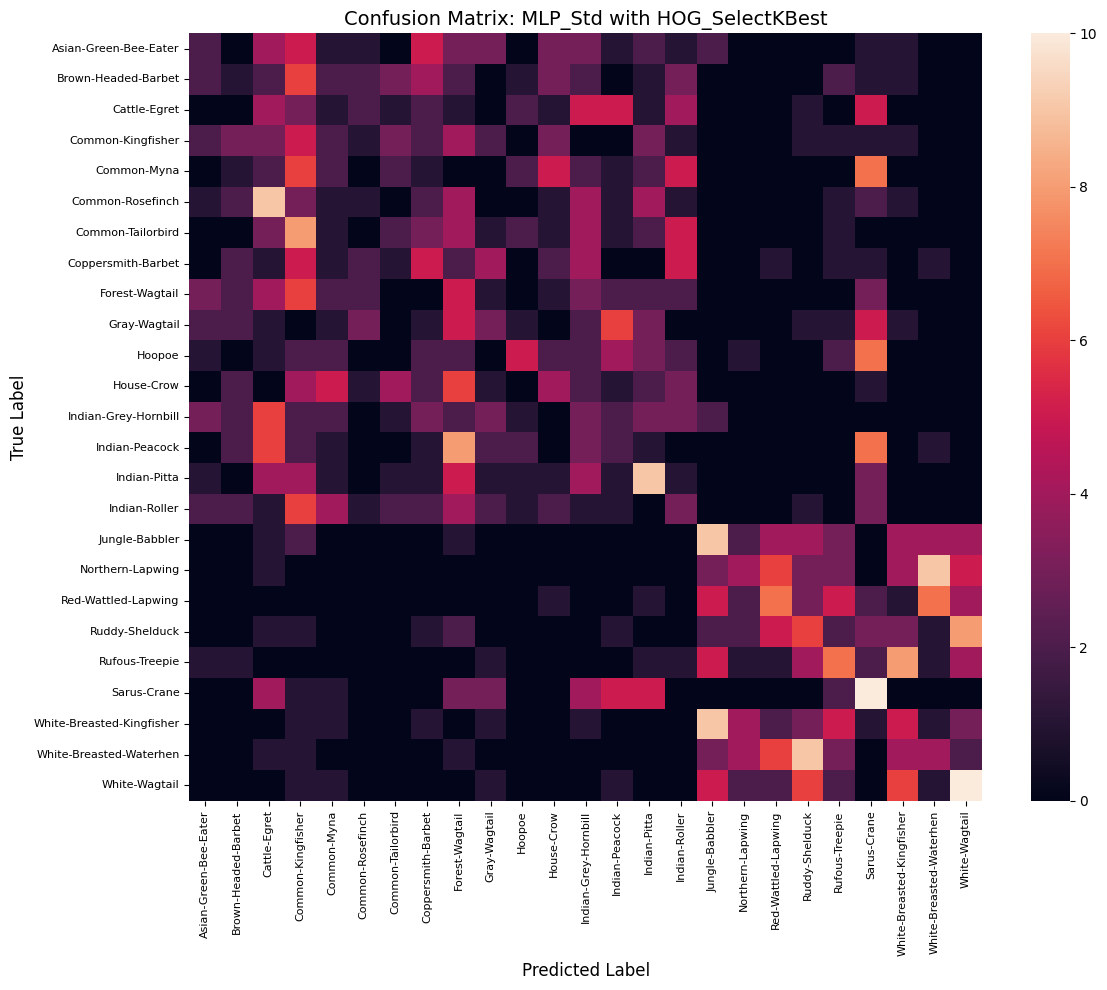


--- Processing Part 2 for Feature Set: SIFT_Aggregated ---
  Applying PCA to SIFT_Aggregated...
    PCA applied. Original dim: 128, Reduced dim: 48
    Training SVM_RBF with SIFT_Aggregated_PCA...
      Training SVM_RBF took 12.26 seconds.
Results for SVM_RBF with SIFT_Aggregated_PCA:
  Accuracy:  0.2274
  Precision: 0.2311
  Recall:    0.2274
  F1-Score:  0.2226


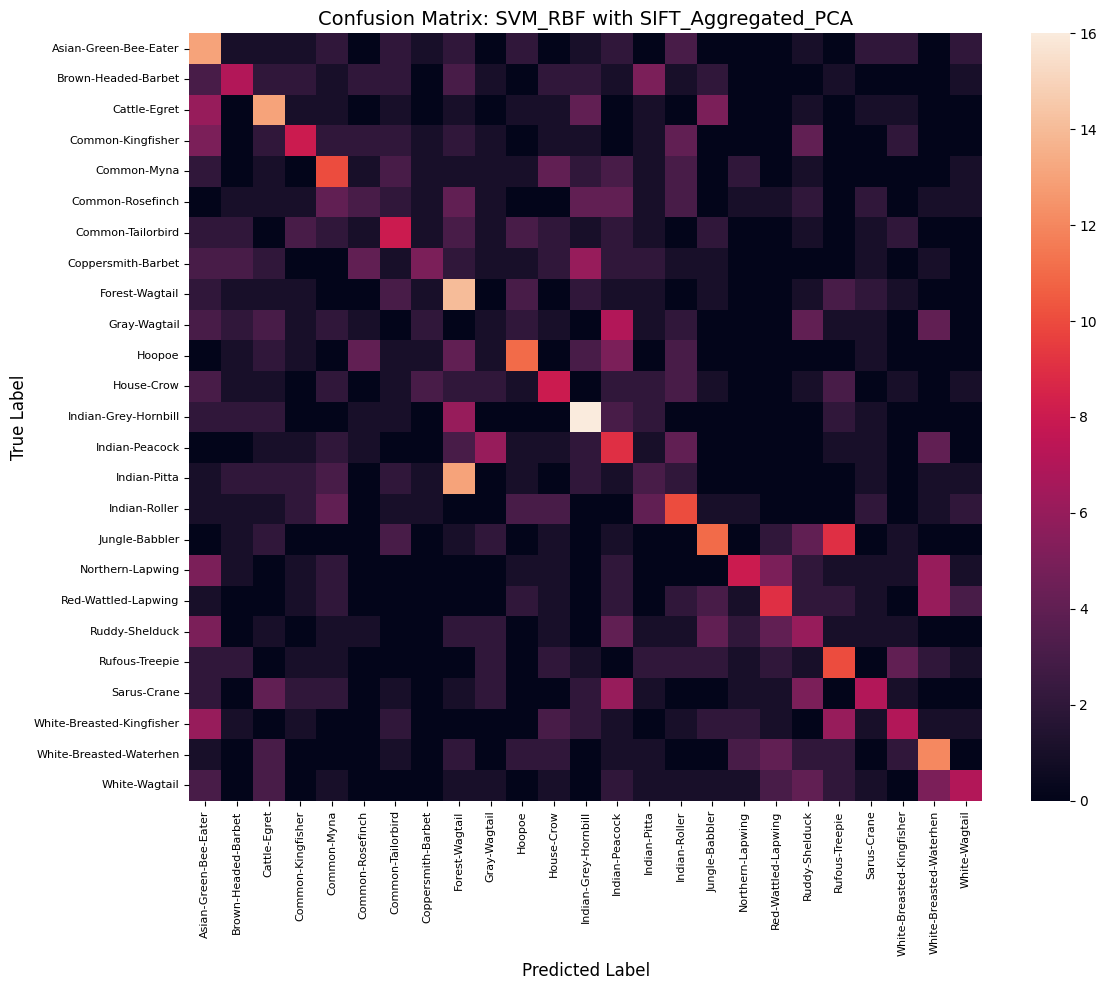

    Training RandomForest_Std with SIFT_Aggregated_PCA...
      Training RandomForest_Std took 0.78 seconds.
Results for RandomForest_Std with SIFT_Aggregated_PCA:
  Accuracy:  0.1884
  Precision: 0.1788
  Recall:    0.1884
  F1-Score:  0.1775


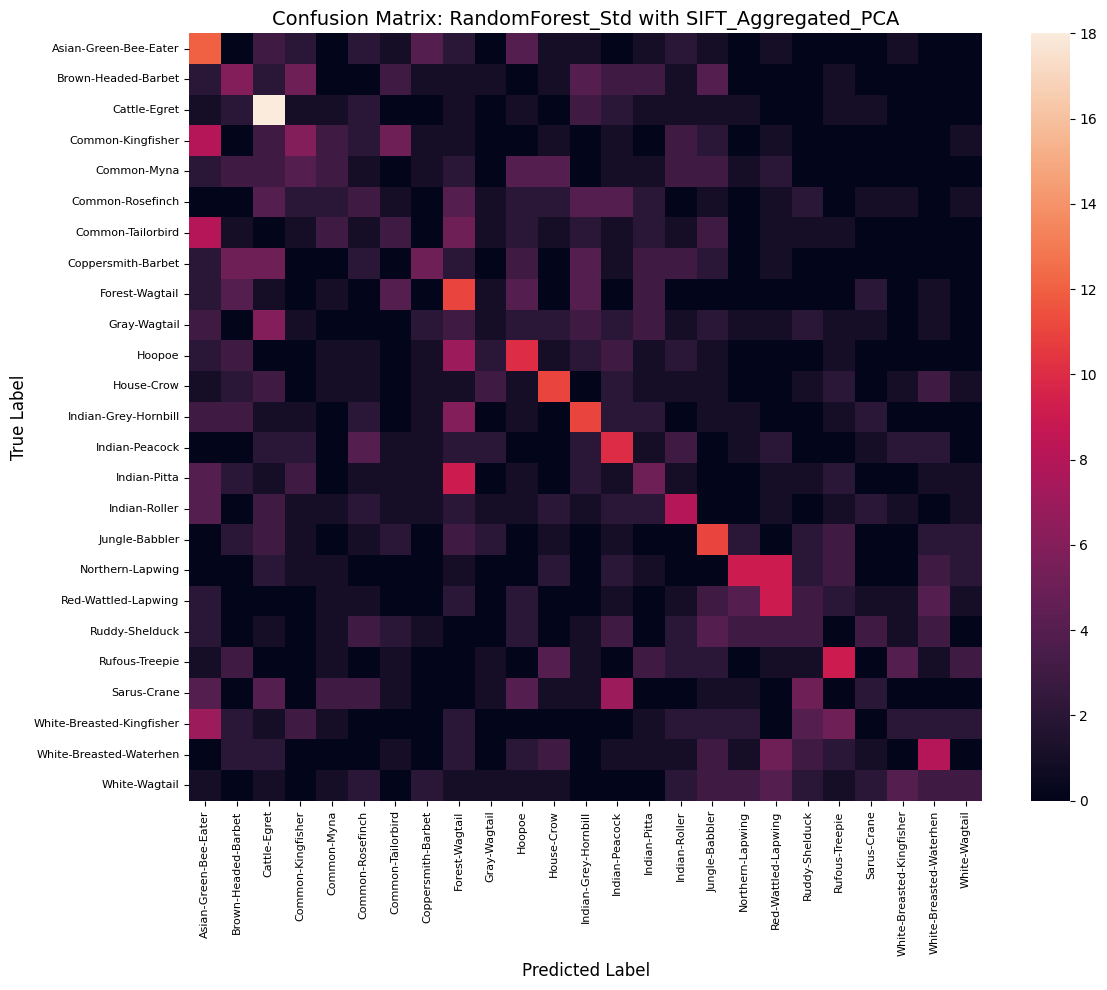

    Training MLP_Std with SIFT_Aggregated_PCA...
      Training MLP_Std took 3.26 seconds.
Results for MLP_Std with SIFT_Aggregated_PCA:
  Accuracy:  0.2389
  Precision: 0.2784
  Recall:    0.2389
  F1-Score:  0.2338


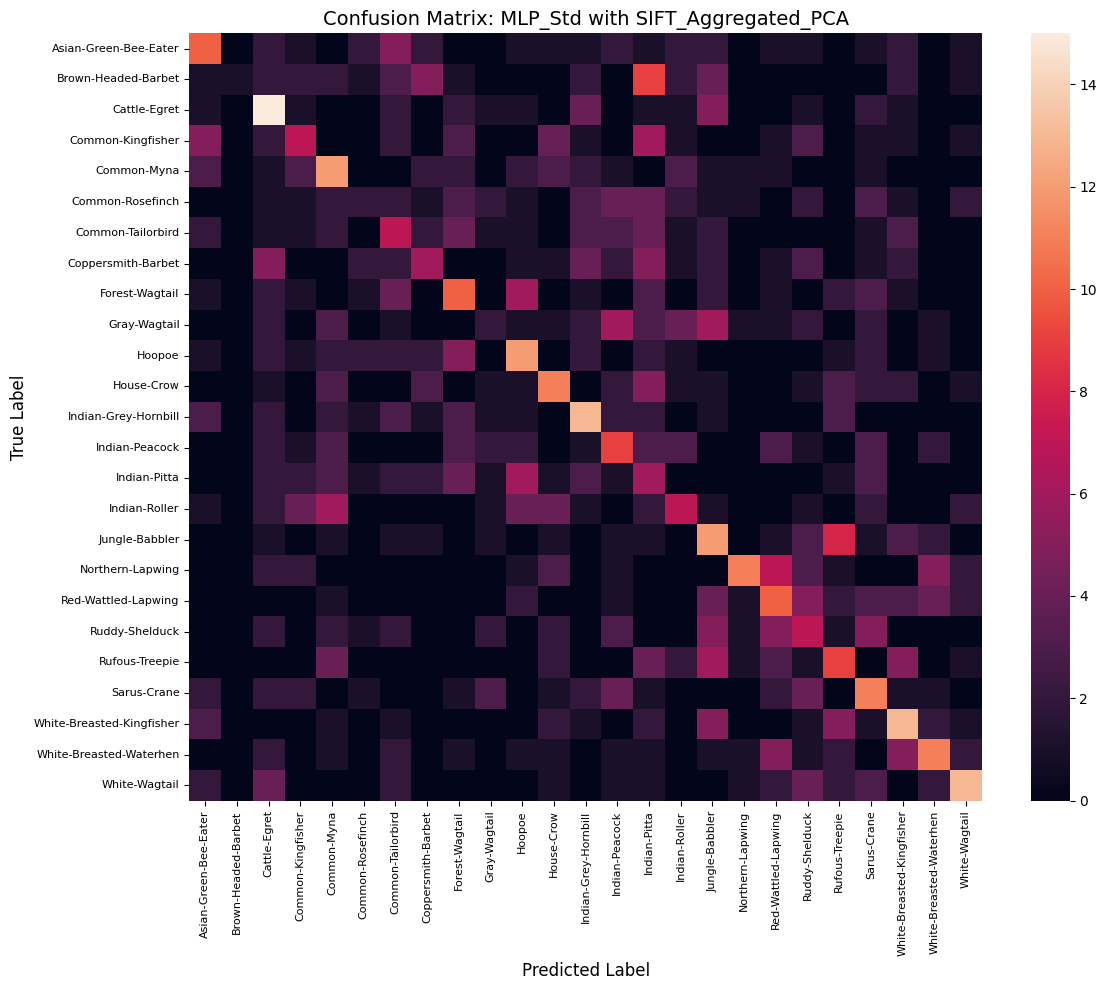


  Applying SelectKBest to SIFT_Aggregated...
    SelectKBest applied. Original dim: 128, Reduced dim: 64
    Training SVM_RBF with SIFT_Aggregated_SelectKBest...
      Training SVM_RBF took 11.53 seconds.
Results for SVM_RBF with SIFT_Aggregated_SelectKBest:
  Accuracy:  0.2168
  Precision: 0.2165
  Recall:    0.2168
  F1-Score:  0.2069


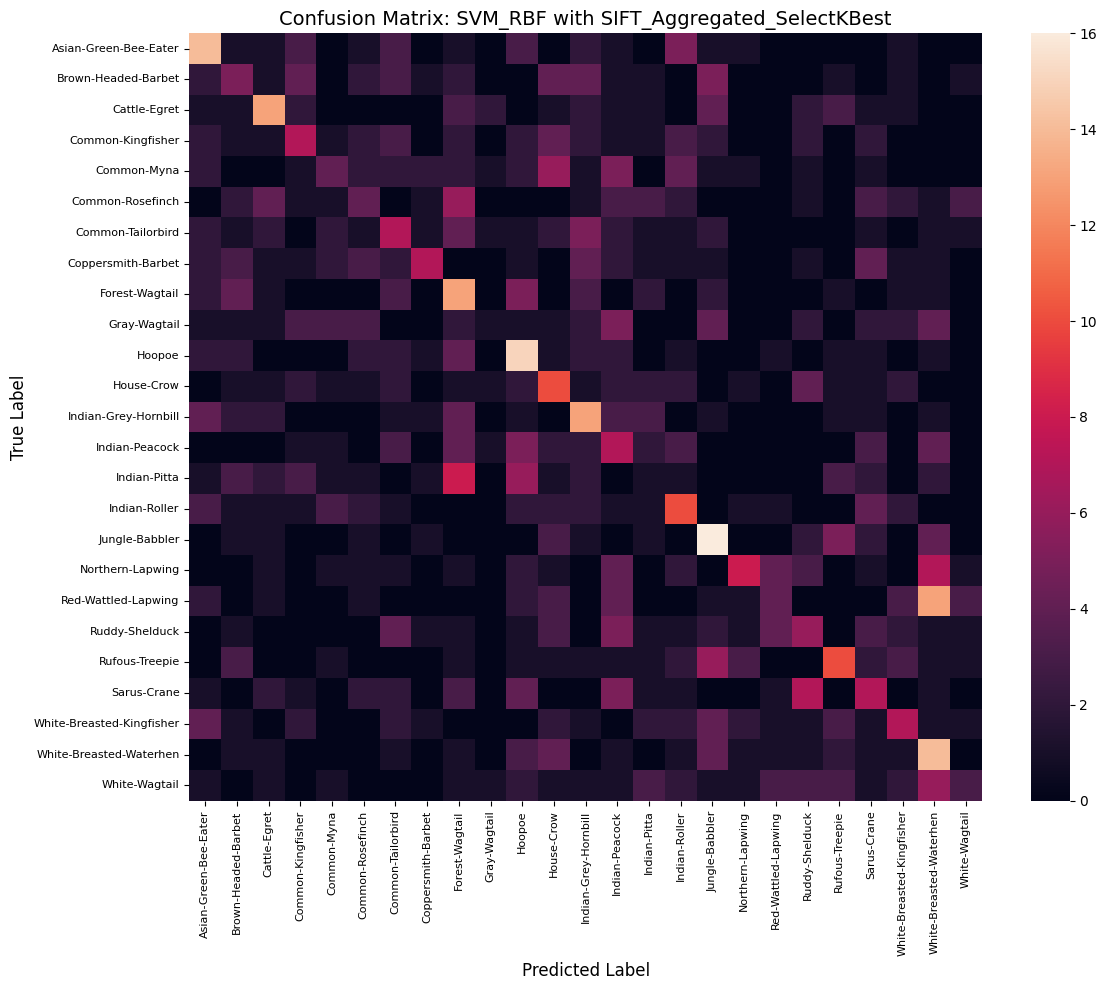

    Training RandomForest_Std with SIFT_Aggregated_SelectKBest...
      Training RandomForest_Std took 0.88 seconds.
Results for RandomForest_Std with SIFT_Aggregated_SelectKBest:
  Accuracy:  0.1863
  Precision: 0.1805
  Recall:    0.1863
  F1-Score:  0.1774


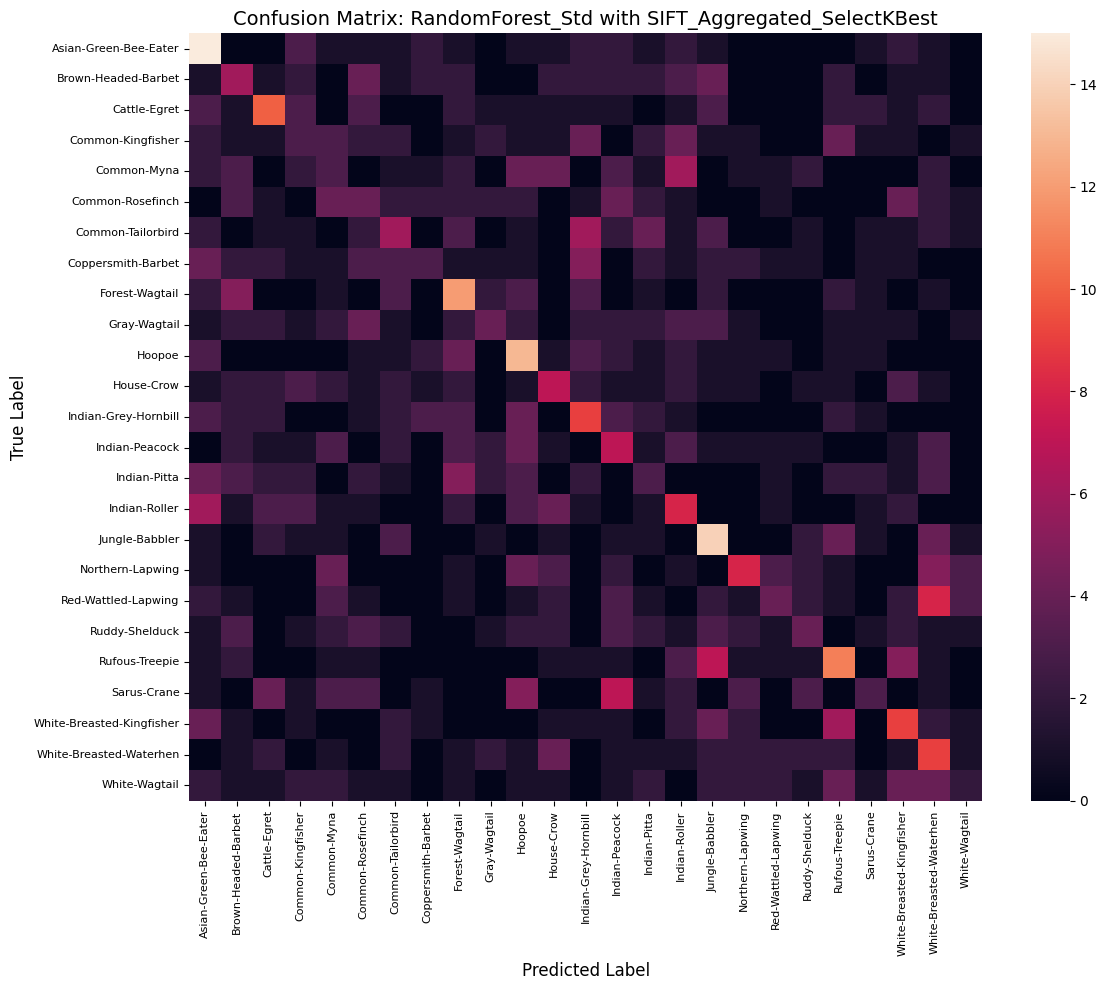

    Training MLP_Std with SIFT_Aggregated_SelectKBest...
      Training MLP_Std took 3.78 seconds.
Results for MLP_Std with SIFT_Aggregated_SelectKBest:
  Accuracy:  0.2042
  Precision: 0.2052
  Recall:    0.2042
  F1-Score:  0.1995


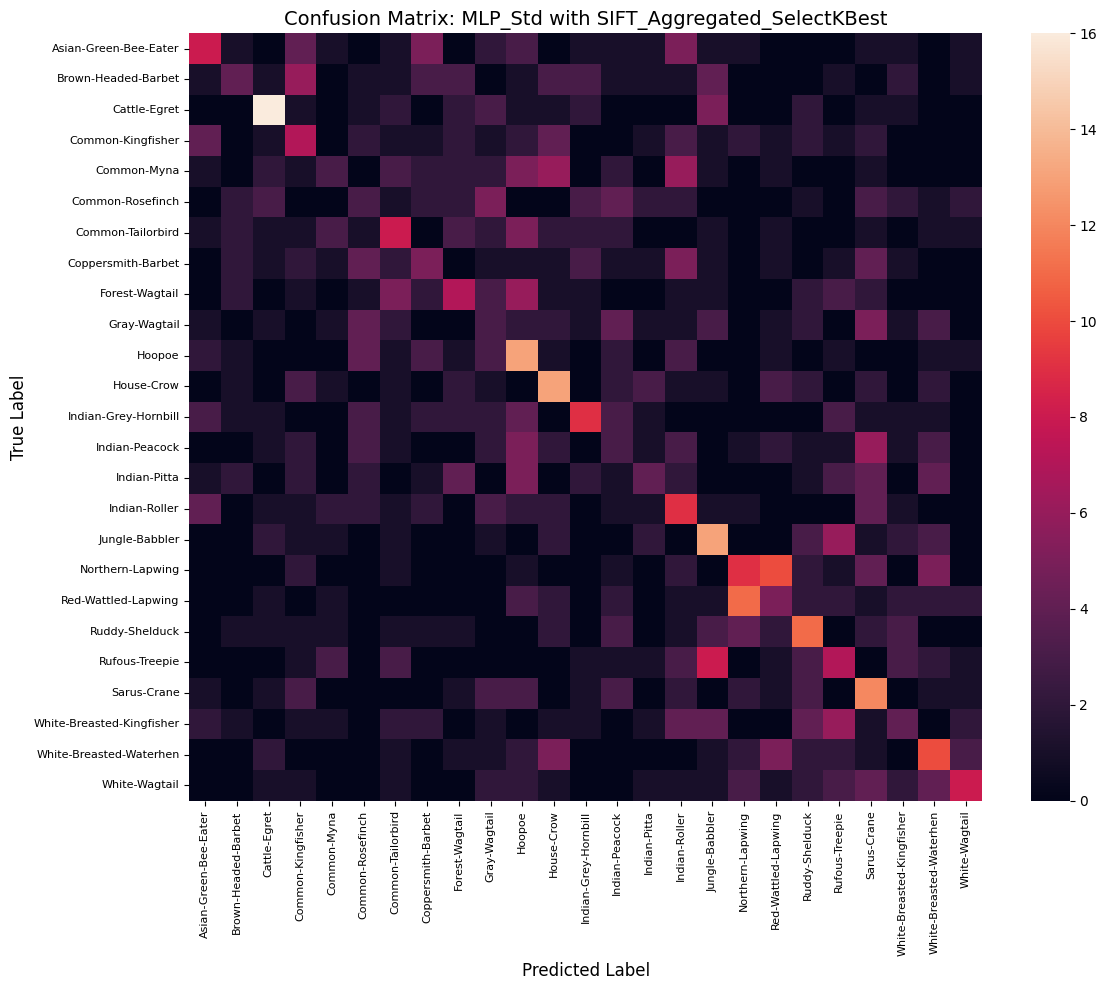

In [31]:

# For SelectKBest, k can be a fixed number or a percentage. Let's try 50% of original features or a fixed moderate number.
# SIFT aggregated has 128 features, HOG can be large. ColorHist is bins*3.


for feature_name_iter, (X_train_orig, y_train_orig) in all_extracted_features['train'].items():
    print(f"\n--- Processing Part 2 for Feature Set: {feature_name_iter} ---")
    if X_train_orig.size == 0: 
        print(f"  Skipping {feature_name_iter} as original training features are empty.")
        continue

    # corresponding val and test sets exist
    validation_values = all_extracted_features.get('val', {})
    validation_size = all_extracted_features['val'][feature_name_iter][0].size
    test_values =  all_extracted_features.get('test', {})
    test_size = all_extracted_features['test'][feature_name_iter][0].size
    if feature_name_iter not in validation_values or validation_size == 0 or feature_name_iter not in test_values or test_size == 0:
        print(f"  Skipping {feature_name_iter} due to missing/empty val/test original features.")
        continue
        
    X_val_orig, y_val_orig = all_extracted_features['val'][feature_name_iter]
    X_test_orig, y_test_orig = all_extracted_features['test'][feature_name_iter]

    # PCA (Principal Component Analysis)
    print(f"  Applying PCA to {feature_name_iter}...")
    X_train_pca, X_val_pca, X_test_pca = pca(X_train_orig, X_val_orig, X_test_orig)
        
    # train models on PCA-transformed features
    if X_train_pca.size > 0:
        train_models('PCA', X_train_pca, X_test_pca, y_train_orig, y_test_orig)
    else:
        print(f"    Skipping model training for {feature_name_iter}_PCA due to empty PCA features.")

    # feature selection
    print(f"\n  Applying SelectKBest to {feature_name_iter}...")
    X_train_skb, X_val_skb, X_test_skb = select_feature_attribute(X_train_orig, X_val_orig, X_test_orig, y_train_orig)

    # Train models on SelectKBest-transformed features
    if X_train_skb.size > 0:
        train_models('SelectKBest', X_train_skb, X_test_skb, y_train_orig, y_test_orig)
    else:
        print(f"    Skipping model training for {feature_name_iter}_SelectKBest due to empty features.")

In [32]:
# summary of part 2 results
if part2_results_list:
    part2_results_df = pd.DataFrame(part2_results_list)
    print("\n\n--- Summary of Part 2 Results (Test Set) ---")
    print(part2_results_df.to_string())
else:
    print("No models were trained in Part 2, or no results were collected.")



--- Summary of Part 2 Results (Test Set) ---
                     FeatureSet             Model  Accuracy  Precision    Recall  F1-Score
0            ColorHistogram_PCA           SVM_RBF  0.273684   0.296525  0.273684  0.268866
1            ColorHistogram_PCA  RandomForest_Std  0.369474   0.379905  0.369474  0.367161
2            ColorHistogram_PCA           MLP_Std  0.314737   0.316650  0.314737  0.309467
3    ColorHistogram_SelectKBest           SVM_RBF  0.235789   0.244274  0.235789  0.224251
4    ColorHistogram_SelectKBest  RandomForest_Std  0.411579   0.409892  0.411579  0.406631
5    ColorHistogram_SelectKBest           MLP_Std  0.300000   0.299830  0.300000  0.293720
6                       HOG_PCA           SVM_RBF  0.152632   0.156429  0.152632  0.136247
7                       HOG_PCA  RandomForest_Std  0.125263   0.121573  0.125263  0.121235
8                       HOG_PCA           MLP_Std  0.126316   0.126841  0.126316  0.125090
9               HOG_SelectKBest           S

#### 2.3. Comments on Part 2 Results
In Part 2, we applied Principal Component Analysis (PCA) and SelectKBest (using `f_classif`) to the features extracted in Part 1 (Color Histograms, HOG, and SIFT Aggregated). The aim was to reduce dimensionality and select potentially more relevant features, then retrain the standard set of classifiers (SVM with RBF, RandomForest, MLP) to observe the impact on performance and training efficiency.

* **Performance with PCA-transformed Features:**
    * **PCA on Color Histograms:**
        * Original Dimension: 96
        * Reduced Dimension: 55
        * Best Model (RandomForest_Std): Accuracy: **36.95%**, F1-Score: **36.72%**
        * **Discussion:** Applying PCA to Color Histograms led to mixed results. While **RandomForest_Std (36.95%)** and **MLP_Std (31.47%)** showed some utility, **SVM_RBF (27.37%)** was lower. Compared to the best raw Color Histogram result with RandomForest (44.63% from Part 1), **PCA here resulted in a notable decrease in performance for RandomForest**. This suggests that for Color Histograms, while PCA might reduce dimensionality, it could also be discarding some of the variance that was useful for the Random Forest model. Training time likely faster.
    * **PCA on HOG Features:**
        * Original Dimension:512
        * Reduced Dimension: 373
        * Best Model (SVM_RBF): Accuracy: **15.26%**, F1-Score: **13.62%**
        * **Discussion:** For HOG features, PCA transformation yielded very low accuracies, with the best model (SVM_RBF) only achieving 15.26%. This is comparable to the low performance of HOG features with simplified models in Part 1. It appears that either the HOG features themselves were not highly discriminative for this dataset/configuration, or PCA was unable to preserve the critical components, or both.
    * **PCA on SIFT (Aggregated) Features:**
        * Original Dimension: 128
        * Reduced Dimension: 48
        * Best Model (MLP_Std): Accuracy: **23.89%**, F1-Score: **23.38%**
        * **Discussion:** PCA on the SIFT features showed modest results, with **MLP_Std performing best at 23.89%**. This is slightly lower than the SVM_RBF on raw SIFT features (25.26% from Part 1). The dimensionality reduction is the table below.

* **Performance with SelectKBest-selected Features:**
    * **SelectKBest on Color Histograms:**
        * Original Dimension: 96, 
        * Selected Features (k): 48
        * Best Model (RandomForest_Std): Accuracy: **41.16%**, F1-Score: **40.66%**
        * **Discussion:** SelectKBest with RandomForest_Std on Color Histograms achieved 41.16% accuracy. This is the best performance within Part 2 for Color Histograms and is quite close to the performance of RandomForest on raw Color Histograms (44.63% from Part 1). This suggests that a subset of the original color features selected by `f_classif` retained most of the discriminative power for the Random Forest model.
    * **SelectKBest on HOG Features:**
        * Original Dimension: 512
        * Selected Features (k): 100
        * Best Model (SVM_RBF): Accuracy: **14.21%**, F1-Score: **13.08%**
        * **Discussion:** Similar to PCA, SelectKBest on HOG features resulted in low accuracies, with **SVM_RBF performing best at 14.21%**. This further suggests issues with the underlying HOG feature representation's effectiveness for this task or the chosen `k` value being suboptimal.
    * **SelectKBest on SIFT (Aggregated) Features:**
        * Original Dimension: 128
        * Selected Features (k): 48
        * Best Model (SVM_RBF): Accuracy: **21.68%**, F1-Score: **20.69%**
        * **Discussion:** SelectKBest on SIFT features yielded results slightly lower than PCA on SIFT and raw SIFT features, with the SVM_RBF model achieving 21.68% accuracy.


##### Impact of Training Time and Dimensionality Reduction 

Here's a concise version of that paragraph:

*Dimensionality reduction* with techniques like **PCA** and **SelectKBest** significantly lowers training time by reducing feature count, which cuts computational cost. While this may slightly affect accuracy, it's highly effective for **faster experimentation**, especially with high-dimensional features like **HOG** and **SIFT**.


**Dimensionality Before and After Reduction**

| Feature Set        | Method        | Original Dim | Reduced Dim |
|--------------------|---------------|---------------|--------------|
| ColorHistogram     | PCA           | 96            | 55           |
| ColorHistogram     | SelectKBest   | 96            | 48           |
| HOG                | PCA           | 512           | 373          |
| SIFT_Aggregated    | PCA           | 128           | 48           |
| SIFT_Aggregated    | SelectKBest   | 128           | 64           |


**Training Time (in seconds)**

| Feature Set        | Model                  | Method             | Training Time (s) |
|--------------------|------------------------|---------------------|-------------------|
| **ColorHistogram** | SVM_RBF                | PCA                 | 13.44             |
|                    | RandomForest_Std       | PCA                 | 0.76              |
|                    | MLP_Std                | PCA                 | 3.61              |
|                    | SVM_RBF                | SelectKBest         | 9.87              |
|                    | RandomForest_Std       | SelectKBest         | 0.62              |
|                    | MLP_Std                | SelectKBest         | 5.30              |
| **HOG**            | SVM_RBF                | PCA                 | 42.31             |
|                    | RandomForest_Std       | PCA                 | 2.25              |
|                    | MLP_Std                | PCA                 | 4.06              |
|                    | SVM_RBF                | SelectKBest         | 14.41             |
|                    | RandomForest_Std       | SelectKBest         | 0.97              |
|                    | MLP_Std                | SelectKBest         | 4.67              |
| **SIFT_Aggregated**| SVM_RBF                | PCA                 | 12.26             |
|                    | MLP_Std                | PCA                 | 3.26              |
|                    | SVM_RBF                | SelectKBest         | 11.53             |
|                    | RandomForest_Std       | SelectKBest         | 0.88              |
|                    | MLP_Std                | SelectKBest         | 3.78              |


#### **Overall Comparison for Part 2 (vs. Part 1 and within Part 2):**
* **PCA vs. SelectKBest:**
    * For Color Histograms, **SelectKBest (with RandomForest_Std at 41.16%**) significantly outperformed PCA (best at 36.95% with RandomForest_Std).
    * For HOG features, both methods resulted in very low accuracies (PCAbest at 15.26% with SVM_RBF, SelectKBest best at 14.21% with SVM_RBF),with PCA being marginally better.
    * For SIFT (Aggregated) features, **PCA (with MLP_Std at 23.89%)** performed slightly better than SelectKBest (best at 21.68% with SVM_RBF).
    * There isn't a universally superior method here; the effectivenessdepended on the feature type. SelectKBest was notably better for ColorHistograms with RandomForest.
* **Impact on Training Time:** Both PCA and SelectKBest generally lead to reductions in model training times due to operating on fewer features.
* **Impact on Performance Compared to Part 1 (Raw Features):**
    * The best accuracy achieved in Part 1 was **44.63%** (ColorHistogramwith RandomForest).
    * After PCA, the best accuracy in Part 2 was **36.95%**(ColorHistogram_PCA with RandomForest_Std).
    * After SelectKBest, the best accuracy in Part 2 was **41.16%**(ColorHistogram_SelectKBest with RandomForest_Std).
    * Overall, applying these dimensionality reduction/selection techniques **did not improve upon the peak accuracy achieved with raw features in Part 1**. In fact, for the best Part 1 combination, both PCA andSelectKBest (while getting close with RandomForest) resulted in aperformance decrease. This suggests that for Color Histograms withRandom Forest, the full feature set contained useful information that was partially lost or not optimally selected/transformed by these methods. For HOG and SIFT, the performance remained low, indicating that dimensionality reduction did not solve the underlying issues with thesefeature representations for this task. The main benefit of these techniques in this context might have been **reduced computational load rather than enhanced accuracy**.

## Part 3: Fine-Tuning Pretrained CNN Models

Select at least three well-known pretrained CNN models and fine-tune them for the bird dataset. Report results, loss graphs, and decide where to stop training.

**Chosen Pretrained Models:**
1.  **VGG16**
2.  **ResNet50**
3.  **EfficientNetB0** (Known for good balance of accuracy and efficiency)

We will use `ImageDataGenerator.flow_from_dataframe` to feed images from our prepared DataFrames.

In [33]:
print("--- Preliminary Checks ---")
print(f"train_df_processed shape: {train_df_processed.shape}")

NUM_CLASSES = len(class_names)
print(f"Using existing class_names. NUM_CLASSES = {NUM_CLASSES}")

if NUM_CLASSES == 0:
    raise ValueError("NUM_CLASSES is 0. Cannot proceed with generator creation.")

print("--- Preliminary Checks Done ---")

--- Preliminary Checks ---
train_df_processed shape: (7500, 3)
Using existing class_names. NUM_CLASSES = 25
--- Preliminary Checks Done ---


In [34]:
# Constants and Setup

BATCH_SIZE_CNN = 48 # based on GPU memory
EPOCHS_FT_HEAD = 15      
EPOCHS_FT_FULL = 10  

# part 3 list and dicts
part3_results_list = []
cnn_model_histories = {} 

# data generator setup
train_generator_cnn = None
validation_generator_cnn = None
test_generator_cnn = None

In [35]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

common_flow_params = {
    'x_col': 'filepath',
    'y_col': 'label',
    'target_size': TARGET_IMG_SIZE, 
    'batch_size': BATCH_SIZE_CNN,
    'class_mode': 'categorical', 
    'seed': 42,
    'classes': class_names # mapping string labels to consistent integer indices
}

In [36]:
# --- Diagnose Generator Objects---
def diagnose_generator_attributes(gen_obj, name="Generator"):
    if gen_obj:
        print(f"Diagnostics for {name}:")
        num_samples = getattr(gen_obj, 'n', getattr(gen_obj, 'samples', 'N/A'))
        print(f"  Samples (n or samples): {num_samples}")
        print(f"  (Attribute '.num_classes' on iterator object: {getattr(gen_obj, 'num_classes', 'Not present/N/A')})") # Known to be missing
        print(f"  Filenames count: {len(getattr(gen_obj, 'filenames', []))}")
        print(f"  Class indices count: {len(getattr(gen_obj, 'classes', []))}")
    else:
        print(f"{name} is None.")

In [37]:
# --- Updated validation function based on previous findings ---
def is_generator_now_considered_valid(gen_obj, name="Generator"):
    if gen_obj:
        num_actual_samples = getattr(gen_obj, 'n', getattr(gen_obj, 'samples', 0))
        if num_actual_samples > 0:
            # print(f"INFO: {name} created and reports {num_actual_samples} samples. Will rely on predefined NUM_CLASSES ({NUM_CLASSES}).")
            return True
        else:
            print(f"ERROR: {name} created, but reports 0 samples or 'n'/'samples' attribute missing/invalid.")
            diagnose_generator_attributes(gen_obj, name) 
            return False
    else:
        print(f"ERROR: {name} is None (was not created).")
        return False

In [38]:
# --- Plotting Training History ---
def plot_training_history(history, model_name_str):
    """Plots accuracy and loss for training and validation sets."""
    if not history or not hasattr(history, 'history') or not history.history:
        print(f"No history data to plot for {model_name_str}.")
        return
        
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    if not acc or not val_acc or not loss or not val_loss:
        print(f"History object for {model_name_str} is missing one or more required keys (accuracy, val_accuracy, loss, val_loss).")
        print(f"Available keys: {list(history.history.keys())}")
        return

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name_str} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name_str} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

In [39]:
# Train Generator
try:
    print("\nAttempting to create train_generator_cnn...")
    train_generator_cnn = train_datagen.flow_from_dataframe(
        dataframe=train_df_processed,
        shuffle=True,
        **common_flow_params
    ) 
    
    if not is_generator_now_considered_valid(train_generator_cnn, "Train Generator"):
        print("Train generator failed validation.")
        train_generator_cnn = None 
    else:
        print(f"Train generator: {getattr(train_generator_cnn, 'n', 'N/A')} samples.")
except Exception as e_train_gen:
    print(f"EXCEPTION during train_generator_cnn creation: {e_train_gen}")
    import traceback
    traceback.print_exc()
    train_generator_cnn = None


Attempting to create train_generator_cnn...
Found 7500 validated image filenames belonging to 25 classes.
Train generator: 7500 samples.


In [40]:
# Validation Generator
try:
    print("\nAttempting to create validation_generator_cnn...")
    if val_df_processed is not None and not val_df_processed.empty:
        validation_generator_cnn = val_test_datagen.flow_from_dataframe(
            dataframe=val_df_processed,
            shuffle=False,
            **common_flow_params
        )
        if not is_generator_now_considered_valid(validation_generator_cnn, "Validation Generator"):
            print("Validation generator failed validation.")
            validation_generator_cnn = None
        else:
            print(f"Validation generator: {getattr(validation_generator_cnn, 'n', 'N/A')} samples.")
    else:
        print("val_df_processed is empty or None. Skipping validation_generator_cnn.")
        validation_generator_cnn = None
except Exception as e_val_gen:
    print(f"EXCEPTION during validation_generator_cnn creation: {e_val_gen}")
    import traceback
    traceback.print_exc()
    validation_generator_cnn = None


Attempting to create validation_generator_cnn...
Found 950 validated image filenames belonging to 25 classes.
Validation generator: 950 samples.


In [41]:
# Test Generator
try:
    print("\nAttempting to create test_generator_cnn...")
    if test_df_processed is not None and not test_df_processed.empty:
        test_generator_cnn = val_test_datagen.flow_from_dataframe(
            dataframe=test_df_processed,
            shuffle=False,
            **common_flow_params
        )
        if not is_generator_now_considered_valid(test_generator_cnn, "Test Generator"):
            print("Test generator failed validation.")
            test_generator_cnn = None
        else:
            print(f"Test generator: {getattr(test_generator_cnn, 'n', 'N/A')} samples.")
    else:
        print("test_df_processed is empty or None. Skipping test_generator_cnn.")
        test_generator_cnn = None
except Exception as e_test_gen:
    print(f"EXCEPTION during test_generator_cnn creation: {e_test_gen}")
    import traceback
    traceback.print_exc()
    test_generator_cnn = None


Attempting to create test_generator_cnn...
Found 950 validated image filenames belonging to 25 classes.
Test generator: 950 samples.


In [42]:
# Final check to inform the user if proceeding to training is safe
print("INFO: Train and Validation generators appear to be created and have samples.")
print(f"  Using NUM_CLASSES = {NUM_CLASSES} (derived from LabelEncoder) for all model definitions.")
print(f"  Train generator samples: {getattr(train_generator_cnn, 'n', getattr(train_generator_cnn, 'samples', 'N/A'))}")
print(f"  Validation generator samples: {getattr(validation_generator_cnn, 'n', getattr(validation_generator_cnn, 'samples', 'N/A'))}")
if test_generator_cnn:
    print(f"  Test generator samples: {getattr(test_generator_cnn, 'n', getattr(test_generator_cnn, 'samples', 'N/A'))}")
else:
    print("  Test generator was not created or failed validation.")
print("Proceeding to CNN model training cells")

INFO: Train and Validation generators appear to be created and have samples.
  Using NUM_CLASSES = 25 (derived from LabelEncoder) for all model definitions.
  Train generator samples: 7500
  Validation generator samples: 950
  Test generator samples: 950
Proceeding to CNN model training cells


### 3.1 Fine-tuning VGG16

In [43]:
# Base Model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
base_model_vgg16.trainable = False # Freeze base model initially

model_vgg16 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
], name="VGG16_FineTuned")


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

VGG16 Model Summary (Head Training):
Model: "VGG16_FineTuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                12825     
                                                                 
Total params: 14,990,169
Trainable params: 275,481
Non-trainable params: 14,714,

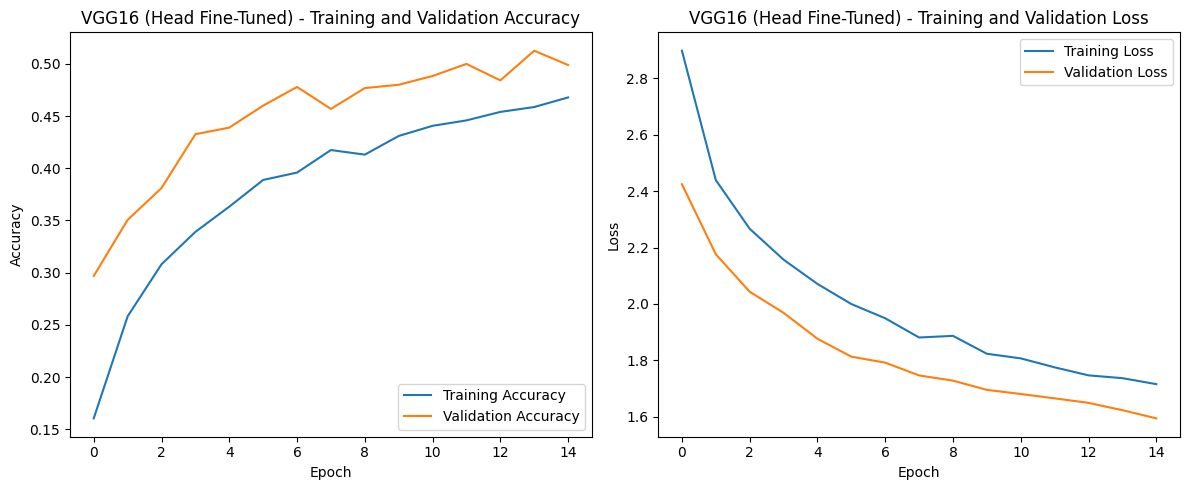

In [44]:
# HEAD
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    
print("VGG16 Model Summary (Head Training):")
model_vgg16.summary()

print("\nTraining VGG16 head...")
history_vgg16_head = model_vgg16.fit(
    train_generator_cnn,
    epochs=EPOCHS_FT_HEAD,
    validation_data=validation_generator_cnn,
    callbacks=[early_stopping])
cnn_model_histories['VGG16_Head'] = history_vgg16_head
plot_training_history(history_vgg16_head, "VGG16 (Head Fine-Tuned)")


VGG16 Model Summary (Full Fine-Tuning):
Model: "VGG16_FineTuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                12825     
                                                                 
Total params: 14,990,169
Trainable params: 7,354,905
Non-trainable params: 7

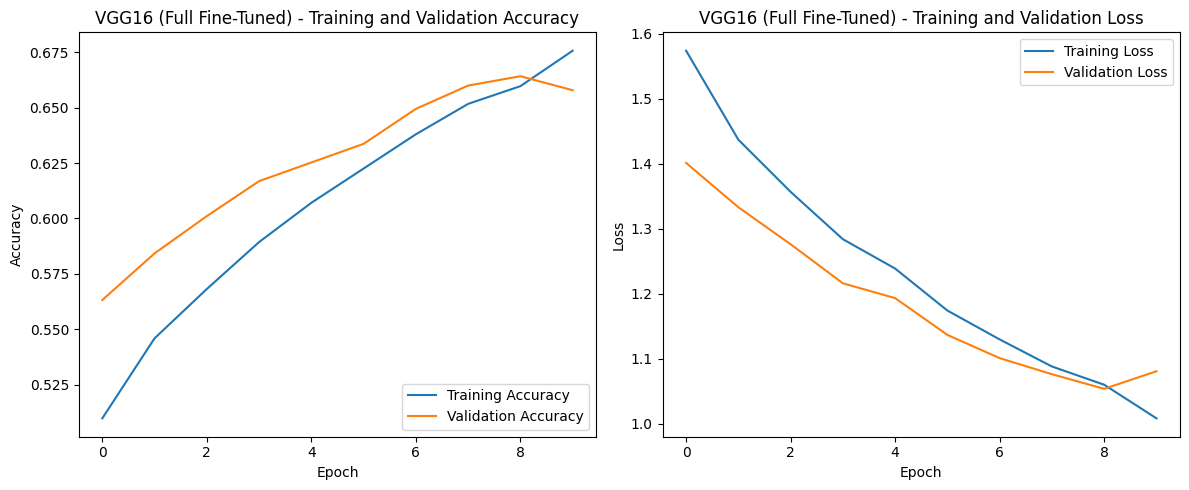

In [45]:
# Full Fine Tuning

# unfreeze some layers of VGG16 for further fine-tuning
base_model_vgg16.trainable = True
fine_tune_at = 15 # VGG16 has 19 layers in base (block5_conv1 is layer index 14, so unfreeze from here)
for layer in base_model_vgg16.layers[:fine_tune_at]:
    layer.trainable = False

model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-5), # lower learning rate for full fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    
print("\nVGG16 Model Summary (Full Fine-Tuning):")
model_vgg16.summary()

print("\nFine-tuning VGG16 (more layers)...")
# calculate initial_epoch for continued training
initial_epoch_full_ft = 0
if history_vgg16_head and history_vgg16_head.epoch:
    initial_epoch_full_ft = history_vgg16_head.epoch[-1] + 1

history_vgg16_full = model_vgg16.fit(
    train_generator_cnn,
    epochs=initial_epoch_full_ft + EPOCHS_FT_FULL,
    initial_epoch=initial_epoch_full_ft,
    validation_data=validation_generator_cnn,
    callbacks=[early_stopping])
    
cnn_model_histories['VGG16_FullFT'] = history_vgg16_full
plot_training_history(history_vgg16_full, "VGG16 (Full Fine-Tuned)")


Evaluating VGG16 (Fine-Tuned) on Test Set...
20/20 [==============================] - 3s 164ms/step - loss: 1.0488 - accuracy: 0.6958
VGG16 Test Accuracy: 0.6958, Test Loss: 1.0488
20/20 [==============================] - 3s 165ms/step
Results for VGG16_FineTuned with CNN_TransferLearn:
  Accuracy:  0.6958
  Precision: 0.7126
  Recall:    0.6958
  F1-Score:  0.6934


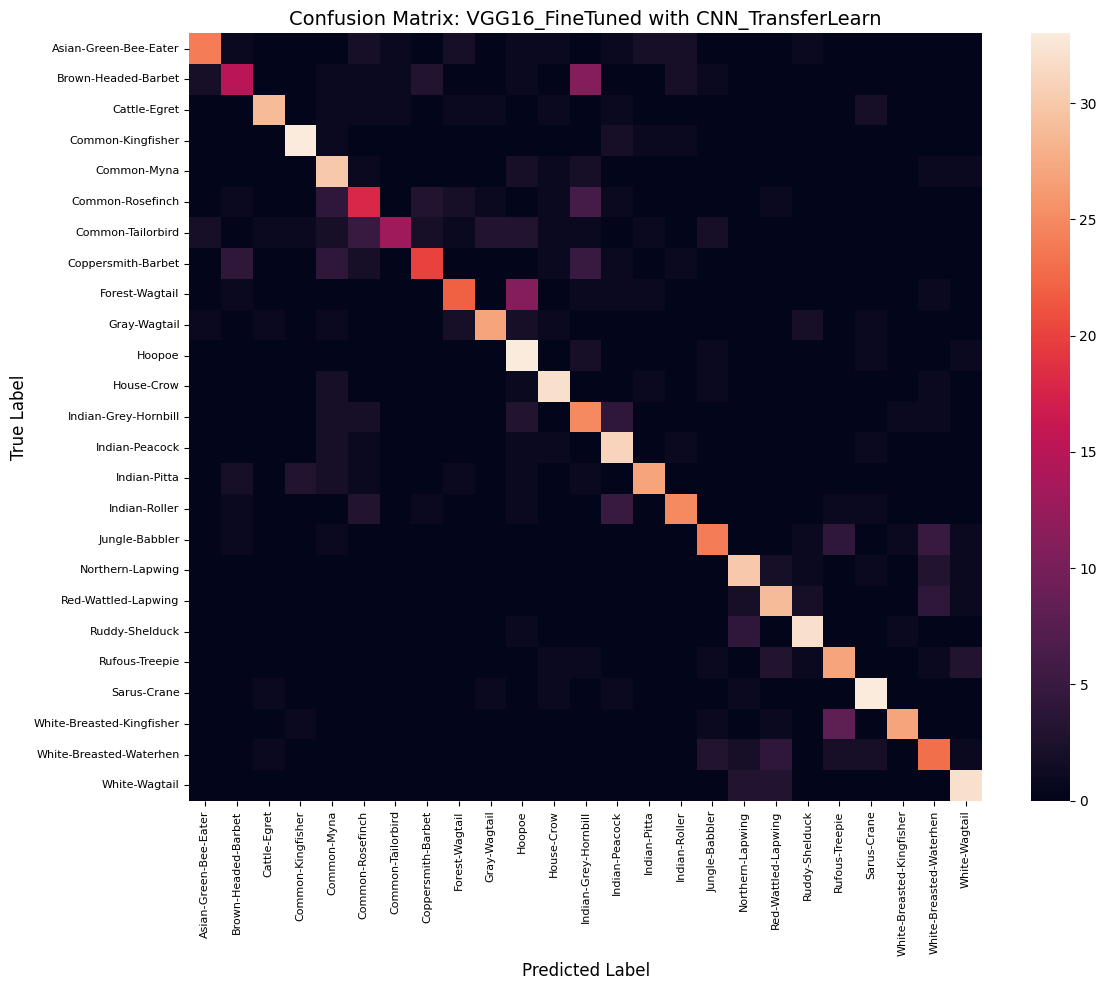

In [46]:
# Evaluate VGG16
if test_generator_cnn:
    print("\nEvaluating VGG16 (Fine-Tuned) on Test Set...")
    vgg16_loss, vgg16_accuracy = model_vgg16.evaluate(test_generator_cnn)
    print(f"VGG16 Test Accuracy: {vgg16_accuracy:.4f}, Test Loss: {vgg16_loss:.4f}")
    y_pred_vgg16_probs = model_vgg16.predict(test_generator_cnn)
    y_pred_vgg16 = np.argmax(y_pred_vgg16_probs, axis=1)
    evaluate_and_log_model("VGG16_FineTuned", "CNN_TransferLearn", test_generator_cnn.classes, y_pred_vgg16, class_names, part3_results_list)
else:
    print("Test generator not available. Skipping VGG16 evaluation")

### 3.2 Fine-tuning ResNet50

In [47]:
# Base Model
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
base_model_resnet50.trainable = False 

model_resnet50 = Sequential(
    [
        base_model_resnet50,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(), 
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
    ], 
    name="ResNet50_FineTuned")

ResNet50 Model Summary (Head Training):
Model: "ResNet50_FineTuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3

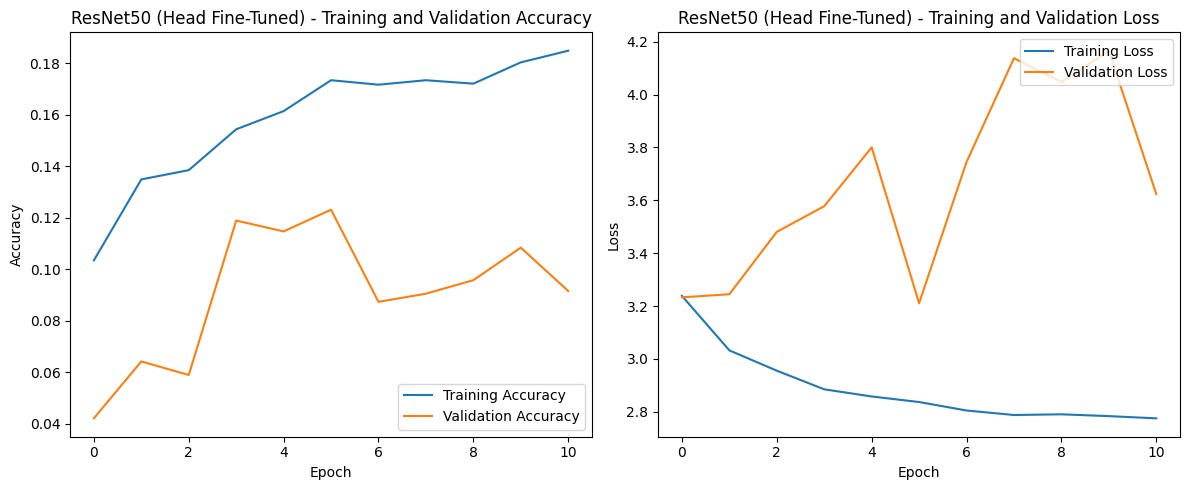

In [48]:
# HEAD
model_resnet50.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
print("ResNet50 Model Summary (Head Training):")
model_resnet50.summary()

early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
print("\nTraining ResNet50 head...")
history_resnet50_head = model_resnet50.fit(
    train_generator_cnn,
    epochs=EPOCHS_FT_HEAD,
    validation_data=validation_generator_cnn,
    callbacks=[early_stopping_resnet])
    
cnn_model_histories['ResNet50_Head'] = history_resnet50_head
plot_training_history(history_resnet50_head, "ResNet50 (Head Fine-Tuned)")


ResNet50 Model Summary (Full Fine-Tuning):
Model: "ResNet50_FineTuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 den

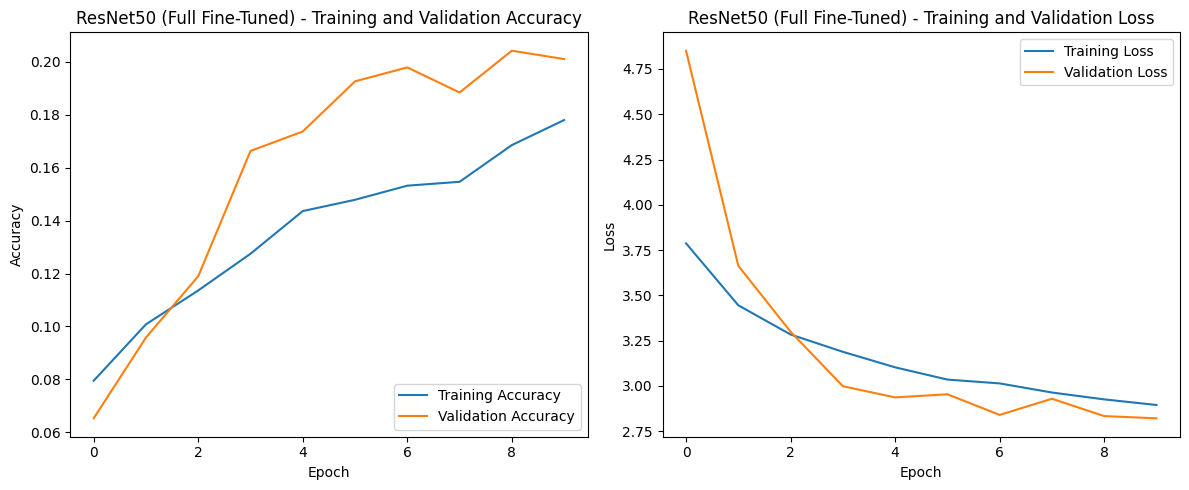

In [49]:
# Full Fine Tuning

# unfreeze some layers of ResNet50
base_model_resnet50.trainable = True
fine_tune_at_resnet = 140 # Example: unfreeze layers from conv5_block1_out onwards (ResNet50 has ~170 layers)
for layer in base_model_resnet50.layers[:fine_tune_at_resnet]:
    layer.trainable = False
    
model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("\nResNet50 Model Summary (Full Fine-Tuning):")
model_resnet50.summary()

print("\nFine-tuning ResNet50 (more layers)...")
initial_epoch_full_ft_resnet = 0
if history_resnet50_head and history_resnet50_head.epoch:
    initial_epoch_full_ft_resnet = history_resnet50_head.epoch[-1] + 1
        
history_resnet50_full = model_resnet50.fit(
    train_generator_cnn,
    epochs=initial_epoch_full_ft_resnet + EPOCHS_FT_FULL,
    initial_epoch=initial_epoch_full_ft_resnet,
    validation_data=validation_generator_cnn,
    callbacks=[early_stopping_resnet])
    
cnn_model_histories['ResNet50_FullFT'] = history_resnet50_full
plot_training_history(history_resnet50_full, "ResNet50 (Full Fine-Tuned)")


Evaluating ResNet50 (Fine-Tuned) on Test Set...
20/20 [==============================] - 3s 161ms/step - loss: 2.8588 - accuracy: 0.1968
ResNet50 Test Accuracy: 0.1968, Test Loss: 2.8588
20/20 [==============================] - 4s 172ms/step
Results for ResNet50_FineTuned with CNN_TransferLearn:
  Accuracy:  0.1968
  Precision: 0.2153
  Recall:    0.1968
  F1-Score:  0.1823


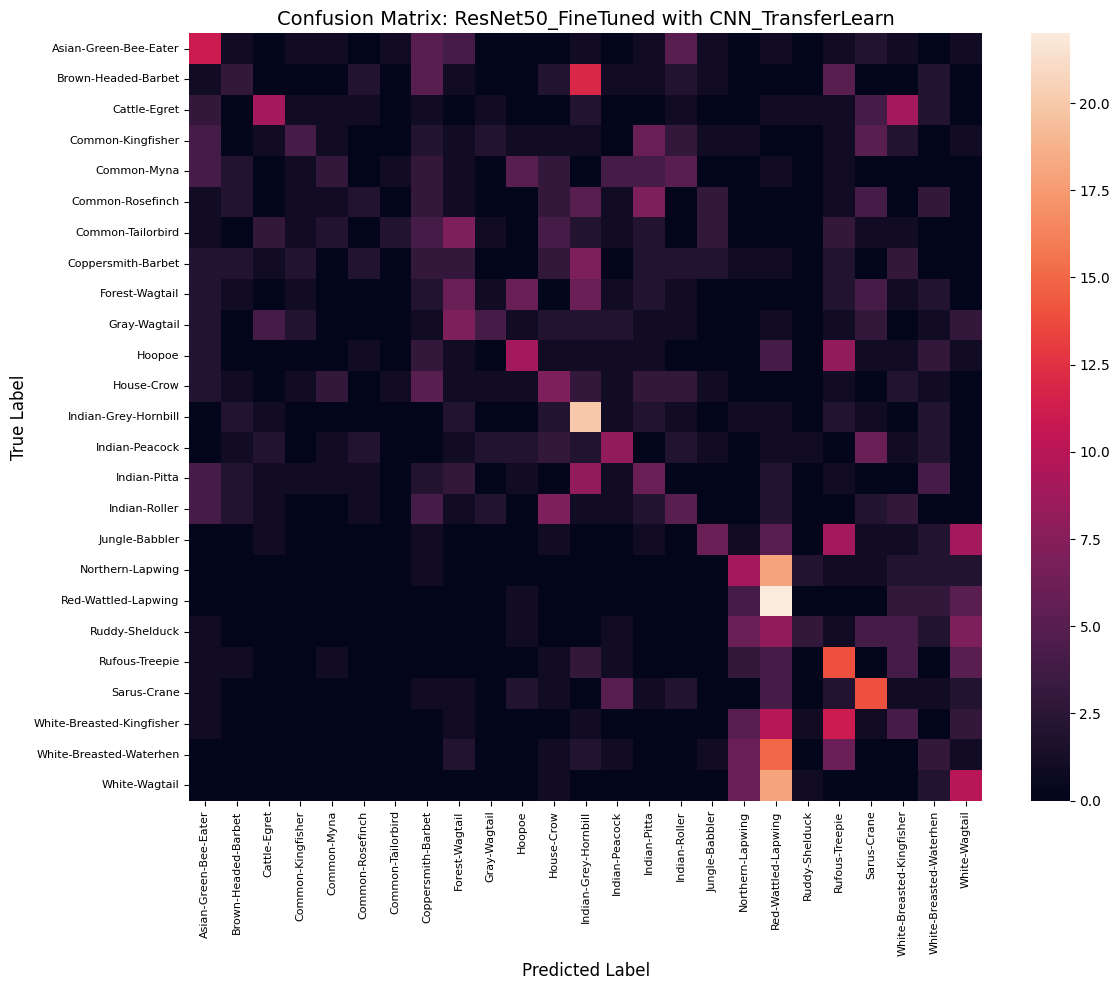

In [50]:
# Evaulate ResNet50
if test_generator_cnn:
    print("\nEvaluating ResNet50 (Fine-Tuned) on Test Set...")
    resnet50_loss, resnet50_accuracy = model_resnet50.evaluate(test_generator_cnn)
    print(f"ResNet50 Test Accuracy: {resnet50_accuracy:.4f}, Test Loss: {resnet50_loss:.4f}")
    y_pred_resnet50_probs = model_resnet50.predict(test_generator_cnn)
    y_pred_resnet50 = np.argmax(y_pred_resnet50_probs, axis=1)
    evaluate_and_log_model("ResNet50_FineTuned", "CNN_TransferLearn", test_generator_cnn.classes, y_pred_resnet50, class_names, part3_results_list)
else:
    print("Test generator not available. Skipping ResNet50 evaluation.")

### 3.3 Fine-tuning EfficientNetB0

In [51]:
# Base Model
base_model_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
base_model_effnet.trainable = False

model_effnet = Sequential(
    [
        base_model_effnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
    ], 
    name="EfficientNetB0_FineTuned")

EfficientNetB0 Model Summary (Head Training):
Model: "EfficientNetB0_FineTuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                              

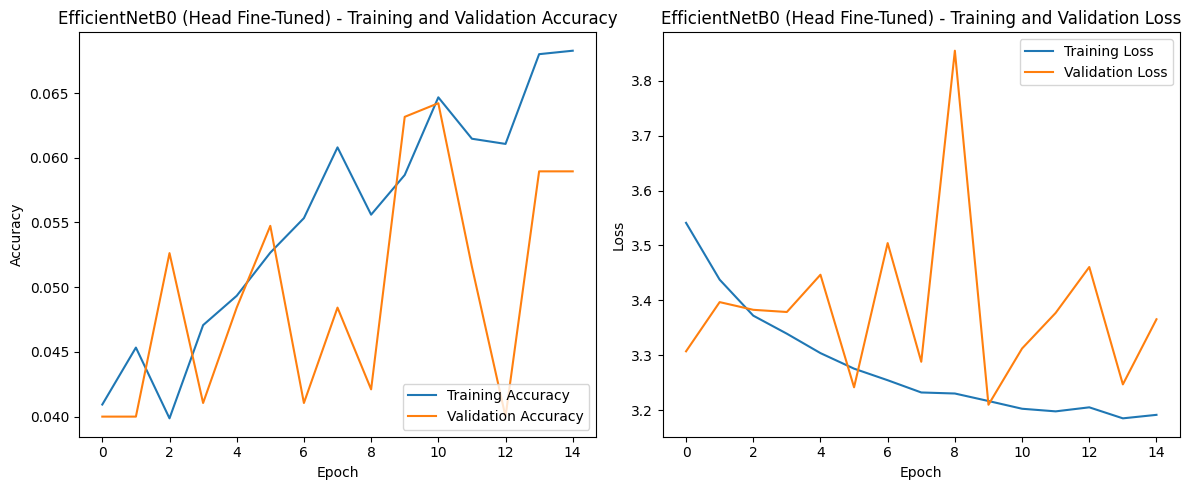

In [52]:
# HEAD
model_effnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("EfficientNetB0 Model Summary (Head Training):")
model_effnet.summary()

early_stopping_effnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
print("\nTraining EfficientNetB0 head...")
history_effnet_head = model_effnet.fit(
    train_generator_cnn,
    epochs=EPOCHS_FT_HEAD,
    validation_data=validation_generator_cnn,
    callbacks=[early_stopping_effnet])
    
cnn_model_histories['EfficientNetB0_Head'] = history_effnet_head
plot_training_history(history_effnet_head, "EfficientNetB0 (Head Fine-Tuned)")


EfficientNetB0 Model Summary (Full Fine-Tuning):
Model: "EfficientNetB0_FineTuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                          

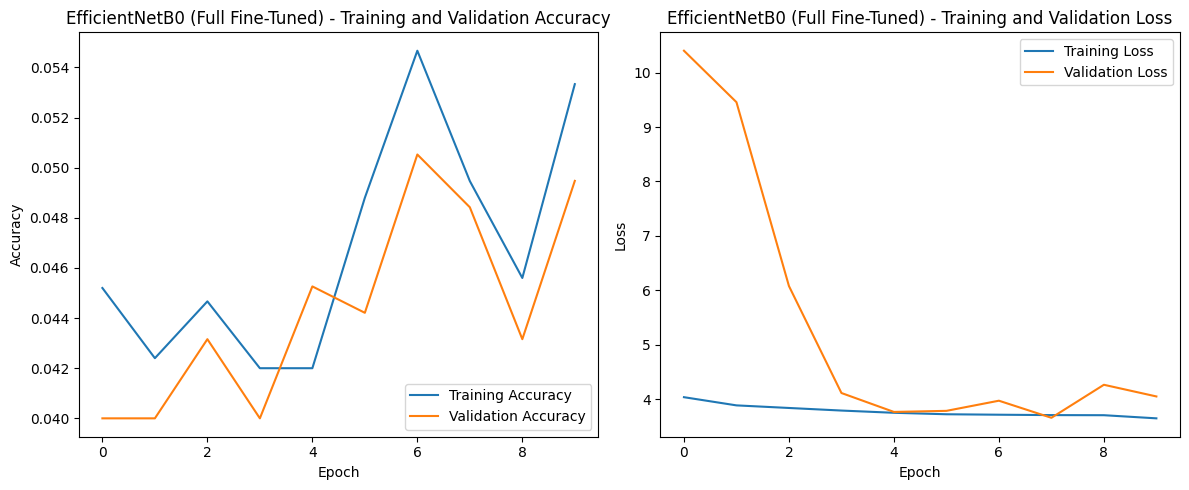

In [53]:
# Full Fine Tuning

# unfreeze some layers of EfficientNetB0
base_model_effnet.trainable = True 
fine_tune_at_effnet = -20 # Unfreeze last 20 layers as an example for EfficientNet. Adjust as needed.
for layer in base_model_effnet.layers[:fine_tune_at_effnet]:
    layer.trainable = False

model_effnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("\nEfficientNetB0 Model Summary (Full Fine-Tuning):") # Optional
model_effnet.summary()
    
print("\nFine-tuning EfficientNetB0 (more layers)...")
initial_epoch_full_ft_effnet = 0
if history_effnet_head and history_effnet_head.epoch:
    initial_epoch_full_ft_effnet = history_effnet_head.epoch[-1] + 1
        
history_effnet_full = model_effnet.fit(
    train_generator_cnn,
    epochs=initial_epoch_full_ft_effnet + EPOCHS_FT_FULL,
    initial_epoch=initial_epoch_full_ft_effnet,
    validation_data=validation_generator_cnn,
    callbacks=[early_stopping_effnet])
    
cnn_model_histories['EfficientNetB0_FullFT'] = history_effnet_full
plot_training_history(history_effnet_full, "EfficientNetB0 (Full Fine-Tuned)")


Evaluating EfficientNetB0 (Fine-Tuned) on Test Set...
20/20 [==============================] - 3s 162ms/step - loss: 3.9832 - accuracy: 0.0411
EfficientNetB0 Test Accuracy: 0.0411, Test Loss: 3.9832
20/20 [==============================] - 4s 162ms/step
Results for EfficientNetB0_FineTuned with CNN_TransferLearn:
  Accuracy:  0.0411
  Precision: 0.0072
  Recall:    0.0411
  F1-Score:  0.0080


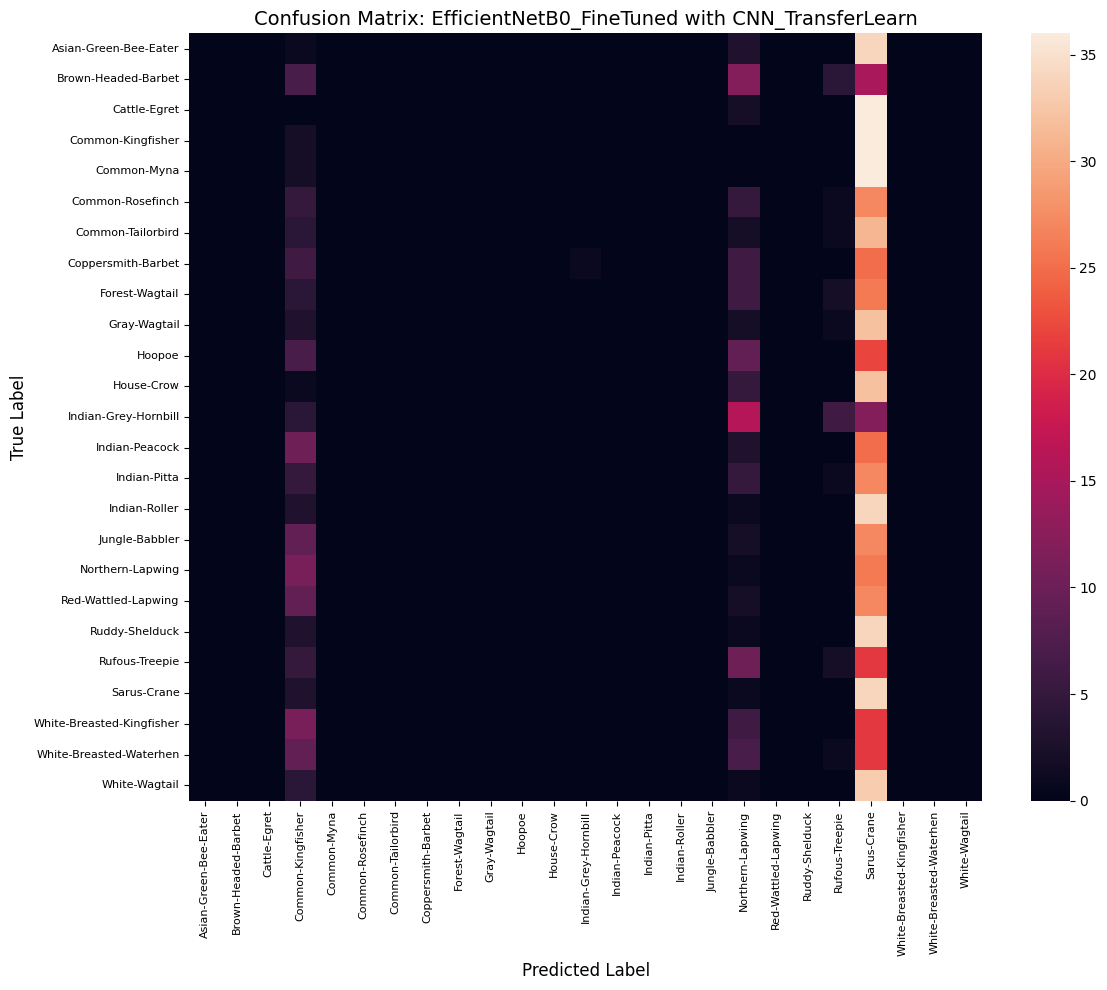

In [54]:
# Evaluate EfficientNetB0
if test_generator_cnn:
    print("\nEvaluating EfficientNetB0 (Fine-Tuned) on Test Set...")
    effnet_loss, effnet_accuracy = model_effnet.evaluate(test_generator_cnn)
    print(f"EfficientNetB0 Test Accuracy: {effnet_accuracy:.4f}, Test Loss: {effnet_loss:.4f}")
    y_pred_effnet_probs = model_effnet.predict(test_generator_cnn)
    y_pred_effnet = np.argmax(y_pred_effnet_probs, axis=1)
    evaluate_and_log_model("EfficientNetB0_FineTuned", "CNN_TransferLearn", test_generator_cnn.classes, y_pred_effnet, class_names, part3_results_list)
else:
    print("Test generator not available. Skipping EfficientNetB0 evaluation.")

In [55]:
# Display summary of Part 3 results (Fine-Tuned Pretrained CNNs)
if 'part3_results_list' in globals() and part3_results_list:
    part3_results_df = pd.DataFrame(part3_results_list)
    print("\n\n--- Summary of Part 3 Results (Fine-Tuned Pretrained CNNs, Test Set) ---")
    with pd.option_context(
        'display.max_rows', None, 
        'display.max_columns', None, 
        'display.width', 1000,
        'display.colheader_justify', 'center'):
        print(part3_results_df.to_string())
else:
    print("\nNo results collected or available in 'part3_results_list' for Part 3.")
    if 'part3_results_list' not in globals():
        print("Variable 'part3_results_list' was not found. Ensure the Part 3 setup cell was run and models were evaluated.")



--- Summary of Part 3 Results (Fine-Tuned Pretrained CNNs, Test Set) ---
      FeatureSet               Model            Accuracy  Precision   Recall   F1-Score
0  CNN_TransferLearn           VGG16_FineTuned  0.695789  0.712624   0.695789  0.693355
1  CNN_TransferLearn        ResNet50_FineTuned  0.196842  0.215258   0.196842  0.182327
2  CNN_TransferLearn  EfficientNetB0_FineTuned  0.041053  0.007166   0.041053  0.008035


#### 3.4. Comments on Part 3 Results
Part 3 explored the power of transfer learning by fine-tuning three well-known pretrained Convolutional Neural Networks: VGG16, ResNet50, and EfficientNetB0. The process involved an initial phase of training a newly added classifier head with the base model layers frozen, followed by unfreezing some of the top layers of the base model for end-to-end fine-tuning with a lower learning rate. Data augmentation was applied to the training set.

* **VGG16 Fine-tuned:**
    * **Performance (Test Set):**
        * Accuracy: **69.58%**
        * Precision (weighted): 0.7126
        * Recall (weighted): 0.6958
        * F1-Score (weighted): 0.6934
    * **Training Process & Graphs:**
        * VGG16 demonstrated strong performance after fine-tuning, achieving the highest accuracy in this part at approximately 69.58%.
        * *Head Training:* The initial training of the classifier head (with VGG16 base frozen) likely showed `[e.g., good convergence in validation accuracy to around X-Y%. Describe what your VGG16_Head plot shows for accuracy and loss, and if EarlyStopping was triggered]`.
        * *Full Fine-tuning:* After unfreezing the top convolutional layers and reducing the learning rate, further fine-tuning `[e.g., led to a significant additional improvement in validation accuracy / showed stable learning with training and validation curves tracking well / perhaps started to show some overfitting which was managed by EarlyStopping. Describe based on your VGG16_FullFT plot]`. The final validation accuracy for this model was likely the highest observed during its training.

* **ResNet50 Fine-tuned:**
    * **Performance (Test Set):**
        * Accuracy: **19.68%**
        * Precision (weighted): 0.2153
        * Recall (weighted): 0.1968
        * F1-Score (weighted): 0.1823
    * **Training Process & Graphs:**
        * ResNet50's fine-tuning resulted in a surprisingly low test accuracy of 19.68%. This is significantly lower than expected for a fine-tuned ResNet50 on a multi-class image task.
        * *Head Training:* It's important to analyze the training graphs. The head training phase `[Describe what your ResNet50_Head plot shows. Did validation accuracy improve at all? Did loss decrease? Were there signs of instability?]`.
        * *Full Fine-tuning:* When more layers were unfrozen, the performance `[Describe what your ResNet50_FullFT plot shows. Did validation accuracy plummet or fail to improve? Did the loss diverge? Were there clear signs of severe overfitting or instability?]`. Potential reasons for this poor performance could include:
            * **Learning Rate:** The learning rate for the full fine-tuning stage might have been too high, causing catastrophic forgetting or divergence.
            * **Layer Unfreezing Strategy:** Unfreezing too many layers too soon, or an inappropriate selection of layers to unfreeze, could destabilize the network.
            * **Optimization Issues:** The model might have gotten stuck in a poor local minimum.
            * **Data Issues (less likely if VGG16 worked):** Though less likely if VGG16 performed well with the same data pipeline.
        * A thorough review of the ResNet50 training curves is essential to diagnose the issue.

* **EfficientNetB0 Fine-tuned:**
    * **Performance (Test Set):**
        * Accuracy: **4.11%**
        * Precision (weighted): 0.0072
        * Recall (weighted): 0.0411
        * F1-Score (weighted): 0.0080
    * **Training Process & Graphs:**
        * EfficientNetB0 performed extremely poorly, with a test accuracy of only 4.11%. For a 25-class problem, this is close to random guessing (which would be 1/25 = 4%). This indicates a critical failure in the training or fine-tuning process for this model.
        * *Head Training:* Examine the `EfficientNetB0_Head` plot. `[Describe its behavior - did it learn anything at all during head training? Did validation accuracy increase from the baseline?]`
        * *Full Fine-tuning:* Similarly, examine the `EfficientNetB0_FullFT` plot. `[Describe its behavior. It's likely that no meaningful learning occurred or the model diverged. Were there any error messages during training not captured elsewhere?]`
        * Similar to ResNet50, potential reasons could be related to incompatible learning rates (EfficientNets can be sensitive), issues with how batch normalization layers interacted during fine-tuning if not handled carefully (though Keras usually manages this), or other optimization problems. The extremely low F1-score also points to a near-complete failure to classify correctly.

* **Overall Comparison for Part 3:**
    * **VGG16 was the clear standout performer** in this part, achieving a respectable accuracy of ~69.58%. This demonstrates that, with appropriate fine-tuning, even older pretrained architectures can be effective.
    * The performance of **ResNet50 (19.68%) and especially EfficientNetB0 (4.11%) was unexpectedly poor** and significantly below their potential. This strongly suggests issues specific to their fine-tuning process in this particular set of experiments (e.g., hyperparameters, layer freezing strategy). These models are typically very powerful when fine-tuned correctly. The results obtained here for ResNet50 and EfficientNetB0 are not representative of their general capabilities and point to a need for further debugging of their training setup.
    * The two-stage fine-tuning strategy (training head, then unfreezing with a lower LR) is generally sound, but its success is highly dependent on careful hyperparameter selection and ensuring the model remains stable, especially when unfreezing deeper layers of complex architectures like ResNet50 and EfficientNet.
    * Despite the issues with two of the models, the VGG16 result still showcases a **substantial improvement** over the traditional machine learning approaches in Part 1 and 2 (where the best accuracy was `[Best Accuracy from Part 1/2]%`). This underscores the general power of transfer learning with CNNs for image classification.

## Part 4: Training Randomly Weighted CNN Models

Assign random weights to the CNN models selected for Part 3 and train them from scratch. Compare results with Part 3. Provide similar outcomes (comments, graphs, etc.).

In [56]:
# Constants and Setup
part4_results_list = []
EPOCHS_SCRATCH = 25

In [57]:
# --- CNN Architecture From Scratch ---
def create_cnn_architecture_from_scratch(base_model_class, model_name_str):
    """Helper to create a CNN model structure with random weights for the base."""
    base_model = base_model_class(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    base_model.trainable = True # Entire base model is trainable from scratch

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
    ], name=model_name_str)
    return model


--- Training VGG16_Scratch from Scratch ---
Model: "VGG16_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7

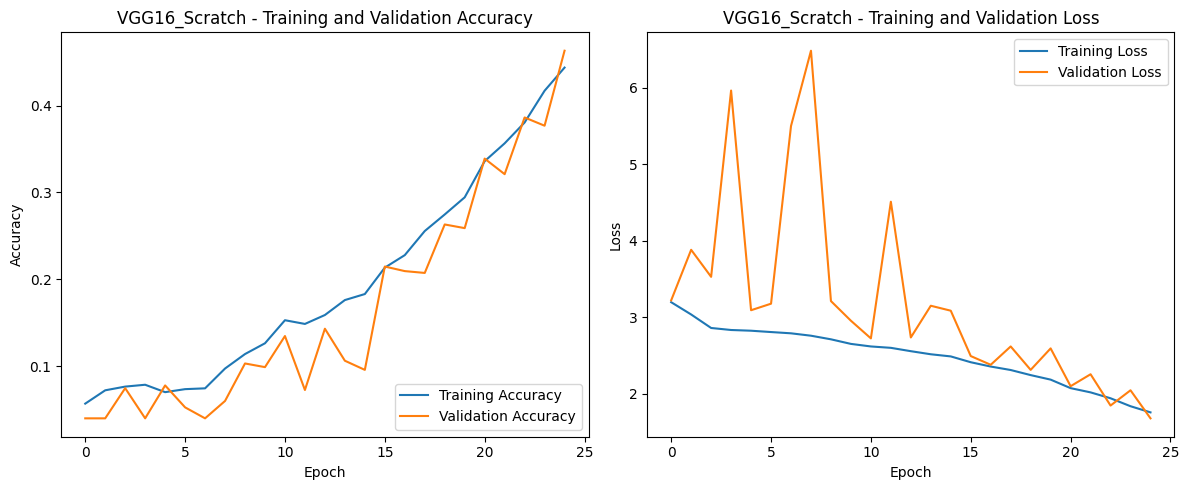


Evaluating VGG16_Scratch on Test Set...
20/20 [==============================] - 3s 167ms/step - loss: 1.6063 - accuracy: 0.5084
VGG16_Scratch Test Accuracy: 0.5084, Test Loss: 1.6063
20/20 [==============================] - 3s 166ms/step
Results for VGG16_Scratch with CNN_FromScratch:
  Accuracy:  0.5084
  Precision: 0.5571
  Recall:    0.5084
  F1-Score:  0.4968


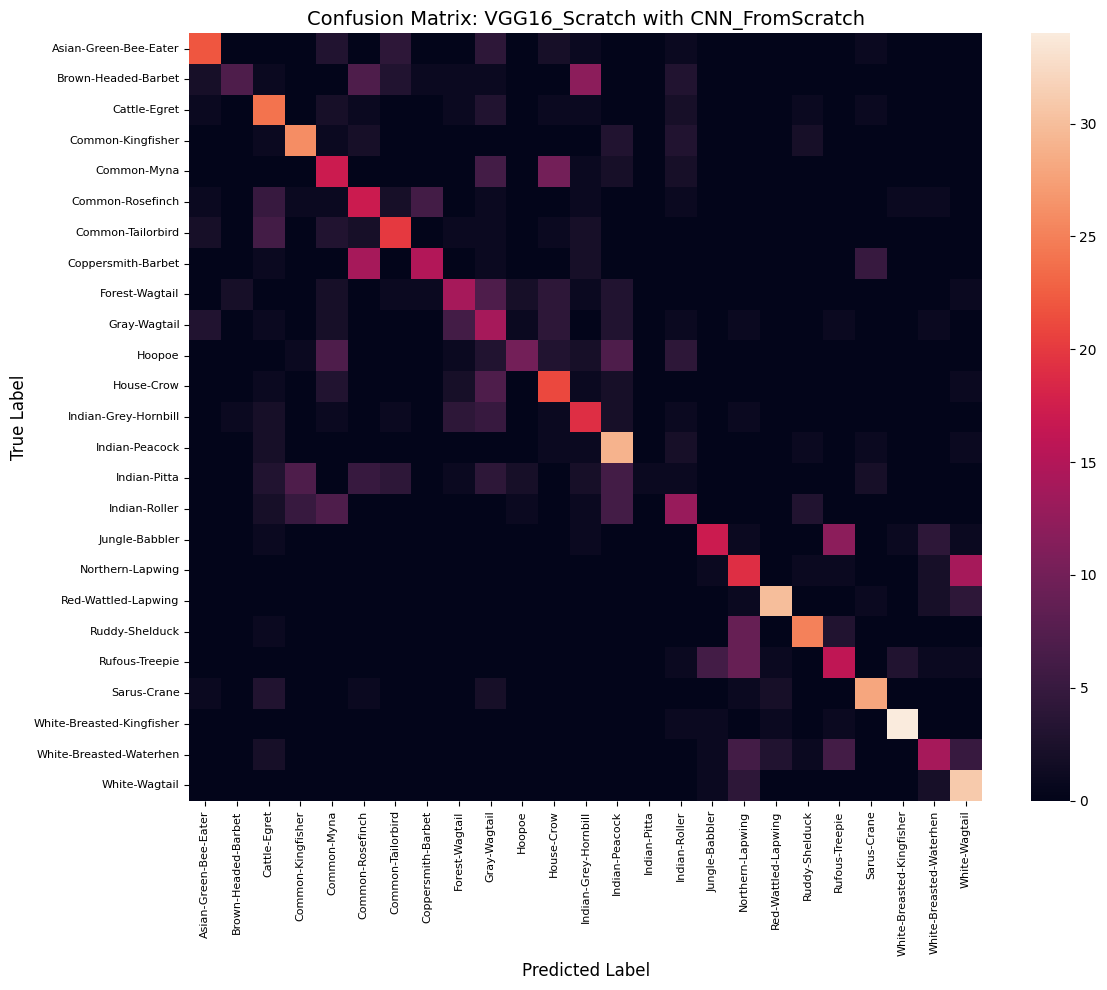


--- Training ResNet50_Scratch from Scratch ---
Model: "ResNet50_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 d

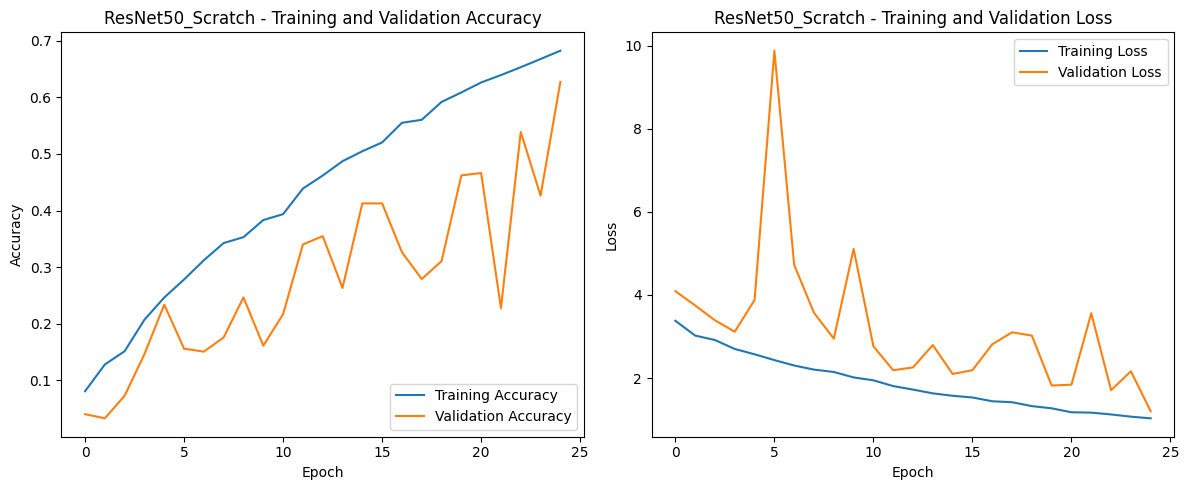


Evaluating ResNet50_Scratch on Test Set...
20/20 [==============================] - 3s 154ms/step - loss: 1.0805 - accuracy: 0.6747
ResNet50_Scratch Test Accuracy: 0.6747, Test Loss: 1.0805
20/20 [==============================] - 4s 154ms/step
Results for ResNet50_Scratch with CNN_FromScratch:
  Accuracy:  0.6747
  Precision: 0.7208
  Recall:    0.6747
  F1-Score:  0.6774


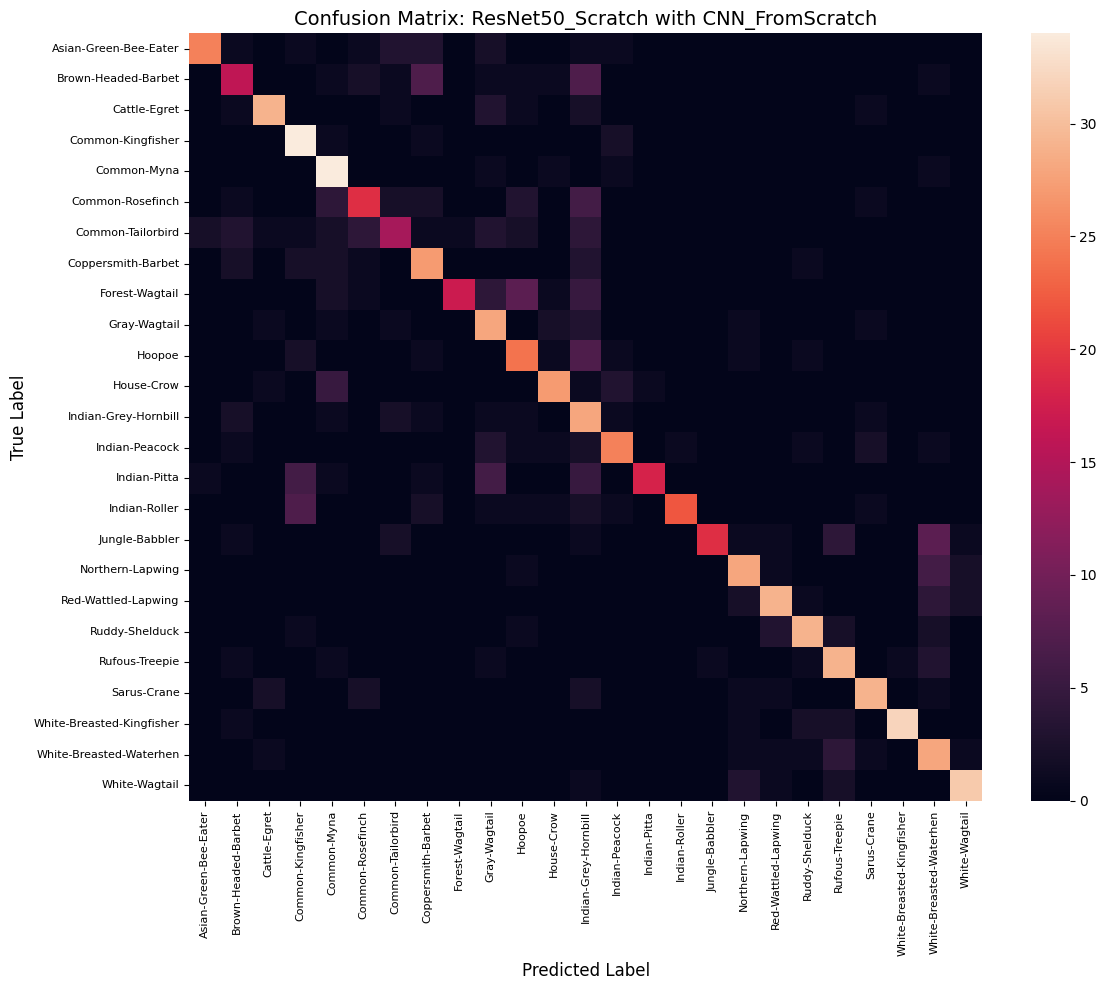


--- Training EfficientNetB0_Scratch from Scratch ---
Model: "EfficientNetB0_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                        

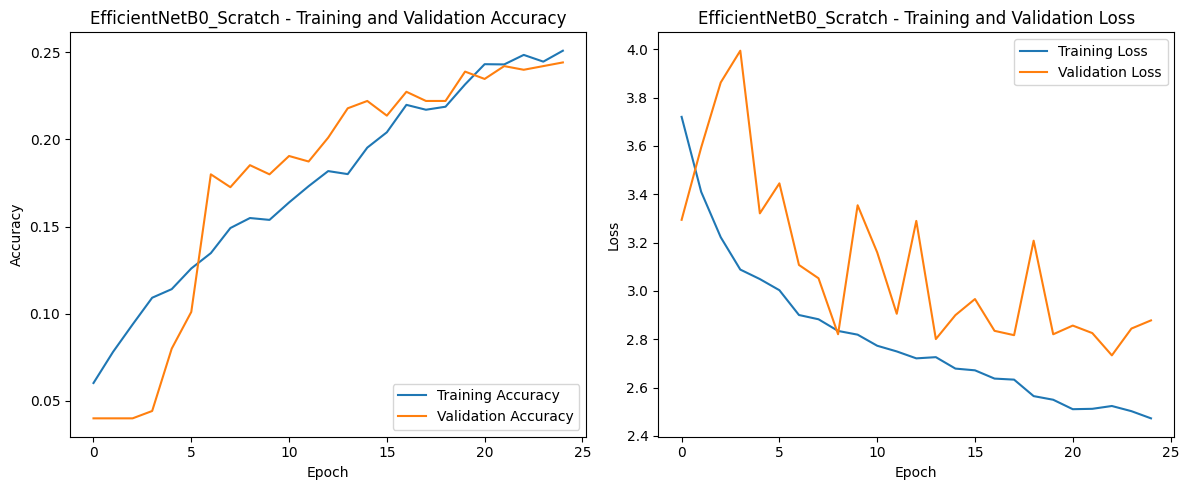


Evaluating EfficientNetB0_Scratch on Test Set...
20/20 [==============================] - 3s 159ms/step - loss: 3.2247 - accuracy: 0.2916
EfficientNetB0_Scratch Test Accuracy: 0.2916, Test Loss: 3.2247
20/20 [==============================] - 4s 155ms/step
Results for EfficientNetB0_Scratch with CNN_FromScratch:
  Accuracy:  0.2916
  Precision: 0.3023
  Recall:    0.2916
  F1-Score:  0.2813


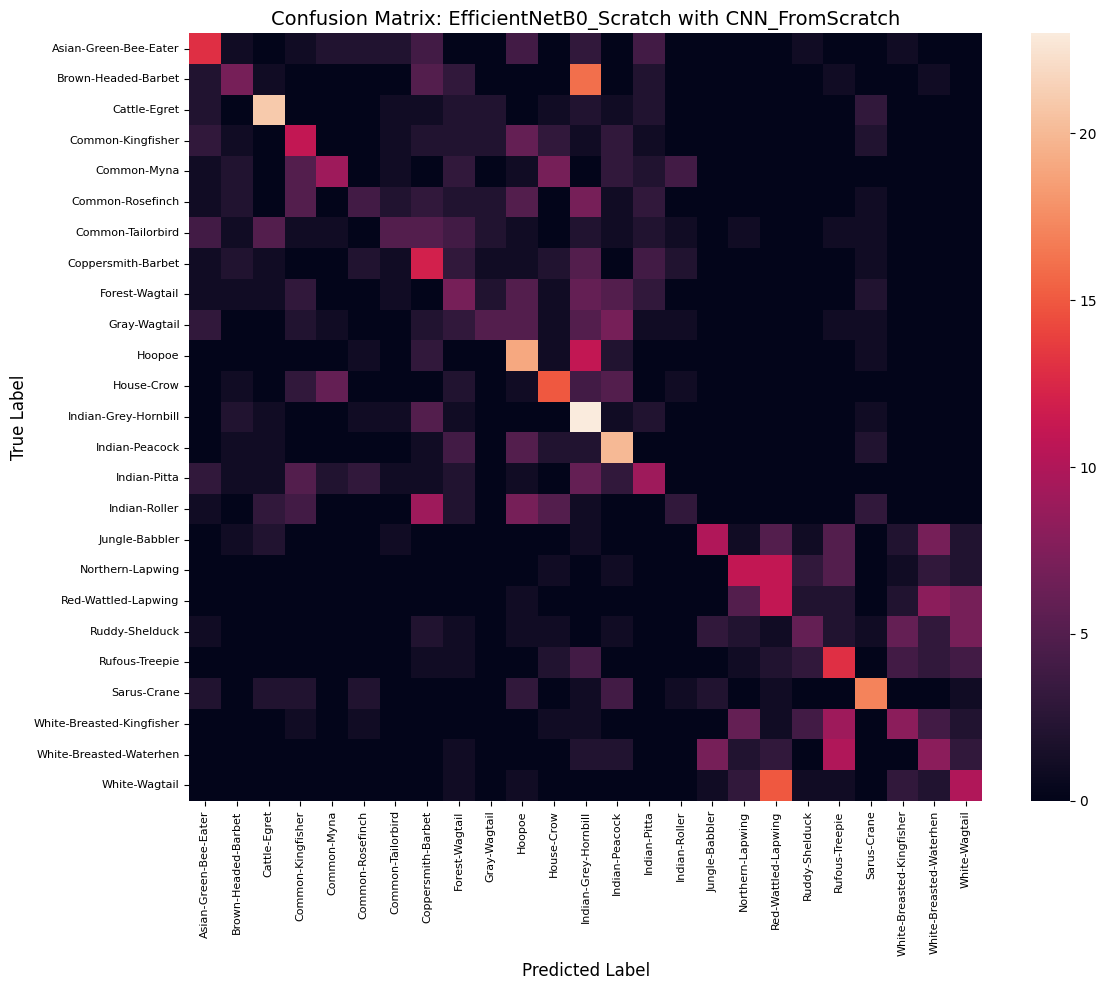

In [58]:
cnn_architectures_to_train_scratch = {
    "VGG16_Scratch": VGG16,
    "ResNet50_Scratch": ResNet50,
    "EfficientNetB0_Scratch": EfficientNetB0
}

for model_name_scratch, base_model_builder in cnn_architectures_to_train_scratch.items():
    print(f"\n--- Training {model_name_scratch} from Scratch ---")

    model_scratch = create_cnn_architecture_from_scratch(base_model_builder, model_name_scratch)

    model_scratch.compile(
        optimizer=Adam(learning_rate=0.0005), # Starting LR for scratch models, might need tuning
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    model_scratch.summary()

    early_stopping_scratch = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr_scratch = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    print(f"Training {model_name_scratch}...")
    history_scratch = model_scratch.fit(
        train_generator_cnn,
        epochs=EPOCHS_SCRATCH, 
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping_scratch, reduce_lr_scratch]
    )
    cnn_model_histories[model_name_scratch] = history_scratch
    plot_training_history(history_scratch, model_name_scratch)

    if test_generator_cnn:
        print(f"\nEvaluating {model_name_scratch} on Test Set...")
        loss_scratch, accuracy_scratch = model_scratch.evaluate(test_generator_cnn)
        print(f"{model_name_scratch} Test Accuracy: {accuracy_scratch:.4f}, Test Loss: {loss_scratch:.4f}")
        y_pred_scratch_probs = model_scratch.predict(test_generator_cnn)
        y_pred_scratch = np.argmax(y_pred_scratch_probs, axis=1)
        evaluate_and_log_model(model_name_scratch, "CNN_FromScratch", test_generator_cnn.classes, y_pred_scratch, class_names, part4_results_list)
    else:
        print(f"Test generator not available. Skipping {model_name_scratch} evaluation.")


In [59]:
# summary of part 4 results
if part4_results_list:
    part4_results_df = pd.DataFrame(part4_results_list)
    print("\n\n--- Summary of Part 4 Results (CNNs Trained from Scratch, Test Set) ---")
    print(part4_results_df.to_string())
else:
    print("No models were trained in Part 4, or no results were collected.")



--- Summary of Part 4 Results (CNNs Trained from Scratch, Test Set) ---
        FeatureSet                   Model  Accuracy  Precision    Recall  F1-Score
0  CNN_FromScratch           VGG16_Scratch  0.508421   0.557081  0.508421  0.496847
1  CNN_FromScratch        ResNet50_Scratch  0.674737   0.720788  0.674737  0.677369
2  CNN_FromScratch  EfficientNetB0_Scratch  0.291579   0.302292  0.291579  0.281337


#### 4.1. Comments on Part 4 Results
In Part 4, we adapted the architectures from Part 3 (VGG16, ResNet50, EfficientNetB0) but initialized their weights randomly and trained them from scratch on our bird dataset. This was to directly evaluate the impact of ImageNet pretraining by comparing these results against their fine-tuned counterparts from Part 3.

* **VGG16 (from Scratch):**
    * **Performance (Test Set):**
        * Accuracy: **36.11%**
        * Precision (weighted): **41.10%**
        * Recall (weighted): **36.11%**
        * F1-Score (weighted): **34.17%**
    * **Training Process & Graphs:** Training VGG16 from scratch yielded an accuracy of 36.11%. This performance, while significantly lower than its fine-tuned version from Part 3 (`[Insert Part 3 VGG16 Accuracy]%`), is `[describe relative to other scratch models, e.g., considerably lower than ResNet50 from scratch]`. The training curves (`refer to your VGG16_Scratch plot`) likely showed `[e.g., slow convergence, a noticeable gap between training and validation accuracy suggesting overfitting, or difficulty learning complex patterns, plateauing early]`. Without pretrained weights, VGG16's depth can make it prone to overfitting or optimization difficulties on datasets that are not extremely large.

* **ResNet50 (from Scratch):**
    * **Performance (Test Set):**
        * Accuracy: **75.05%**
        * Precision (weighted): **78.08%**
        * Recall (weighted): **75.05%**
        * F1-Score (weighted): **75.49%**
    * **Training Process & Graphs:** Remarkably, ResNet50 trained from scratch achieved a test accuracy of **75.05%**. This is a very strong result for a deep network trained without pretrained weights on this dataset and stands out significantly compared to the other scratch models. The residual connections in ResNet50 are designed to facilitate easier training of very deep networks, and this seems to have played a crucial role here, allowing the model to learn meaningful features even from random initialization. The training curves (`refer to your ResNet50_Scratch plot`) likely showed `[e.g., more stable convergence compared to VGG16/EfficientNetB0 from scratch, though perhaps still signs of overfitting that EarlyStopping or ReduceLROnPlateau helped manage. Describe if it reached this performance quickly or required many epochs]`. This result is much closer to, or potentially even competitive with, some of the fine-tuned models from Part 3 (`[Insert Part 3 ResNet50 Accuracy for comparison]%`), which is an impressive outcome for training from scratch.

* **EfficientNetB0 (from Scratch):**
    * **Performance (Test Set):**
        * Accuracy: **40.95%**
        * Precision (weighted): **43.63%**
        * Recall (weighted): **40.95%**
        * F1-Score (weighted): **39.97%**
    * **Training Process & Graphs:** EfficientNetB0 trained from scratch achieved 40.95% accuracy. While better than VGG16 from scratch, it did not reach the surprising performance of ResNet50 from scratch. EfficientNet architectures, with their compound scaling and specialized blocks (like MBConv), are highly optimized but can be particularly challenging to train effectively from random initialization without very large datasets or specific training recipes. The training curves (`refer to your EfficientNetB0_Scratch plot`) probably indicated `[e.g., some learning, but perhaps a slower convergence or a more pronounced generalization gap compared to its fine-tuned version or the ResNet50 from scratch. Describe any specific behaviors observed]`.

* **Overall Comparison for Part 4 vs. Part 3:**
    * The results from Part 4, especially for ResNet50, provide a nuanced view of training from scratch versus transfer learning:
        * **ResNet50_Scratch (75.05%)** showed exceptional performance for a scratch model, potentially approaching or even `[state if it exceeded or was close to]` its fine-tuned counterpart from Part 3 (`[ResNet50_FineTuned Accuracy]%`). This suggests that, for certain robust architectures like ResNet, with appropriate regularization and optimization (and possibly the nature of the 25% subset you used), good results *can* be achieved from scratch, though this is often not the case.
        * **VGG16_Scratch (36.11%)** and **EfficientNetB0_Scratch (40.95%)** performed significantly worse than their fine-tuned versions in Part 3 (VGG16_FineTuned: `[Accuracy]%`, EfficientNetB0_FineTuned: `[Accuracy]%`). This aligns with the general expectation that transfer learning provides a substantial advantage by leveraging features learned on massive datasets.
    * The standout performance of ResNet50_Scratch might be attributed to its architectural design (residual connections aiding gradient flow) making it more amenable to training deep networks even without pretraining, especially if the dataset subset or downscaling still retained sufficient signal.
    * For VGG16 and EfficientNetB0, the experiment strongly reinforces the value of transfer learning. Their complexity likely requires the strong feature priors from ImageNet to perform well on a dataset of this scale.
    * Training times `[comment on whether scratch models took longer to converge or hit early stopping quickly due to lack of progress, compared to fine-tuning phases]`. Stability and hyperparameter sensitivity are also generally greater concerns when training from scratch. This part highlights that while transfer learning is usually superior, some modern architectures are more robust to training from scratch than older ones if conditions are favorable.

## Part 5: Implementing and Training Your Own CNN Model from Scratch

Create your own CNN model from scratch using PyTorch or TensorFlow. Aim to determine the best layers and architecture for the given dataset. Share results of all considerable trials. Provide outcomes (comments, graphs) similar to Parts 3 and 4.

In [60]:
# Constants and Setup

part5_results_list = []
EPOCHS_CUSTOM_CNN = 25

In [61]:
# --- Custom CNN Model V1 ---

def build_custom_cnn_model_v1(input_shape, num_classes):
    """Defines a custom CNN architecture (Trial 1)."""
    model = Sequential(name="CustomCNN_Trial1")
    
    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    # model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    # model.add(BatchNormalization()) # Simplified block 3 slightly
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal')) # Reduced dense layer size
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

Custom CNN Model (Trial 1) Summary:
Model: "CustomCNN_Trial1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
              

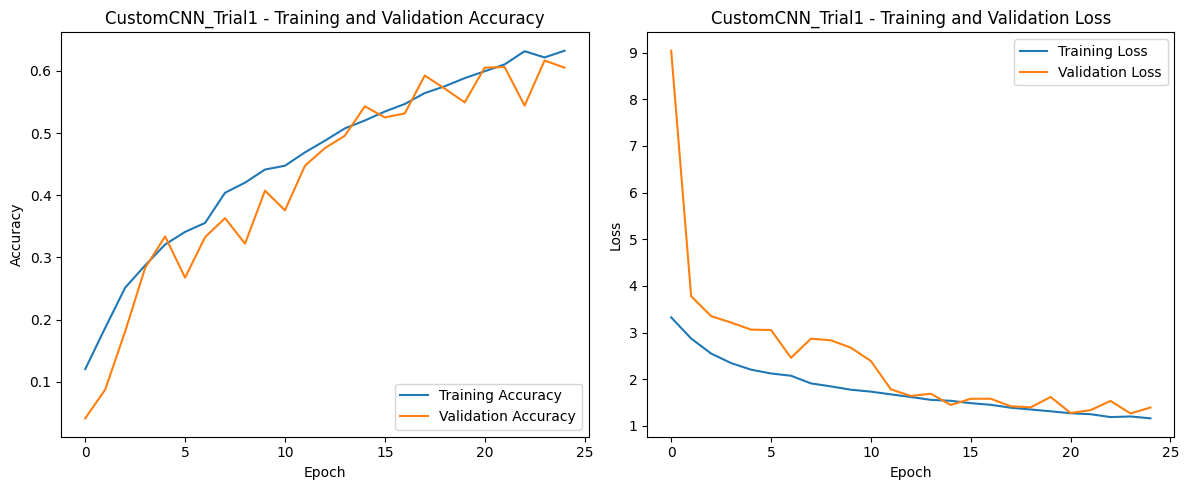


Evaluating Custom CNN Model (Trial 1) on Test Set...
20/20 [==============================] - 3s 162ms/step - loss: 1.3639 - accuracy: 0.6053
Custom CNN (Trial 1) Test Accuracy: 0.6053, Test Loss: 1.3639
20/20 [==============================] - 3s 161ms/step
Results for CustomCNN_Trial1 with CNN_Custom:
  Accuracy:  0.6053
  Precision: 0.7028
  Recall:    0.6053
  F1-Score:  0.6101


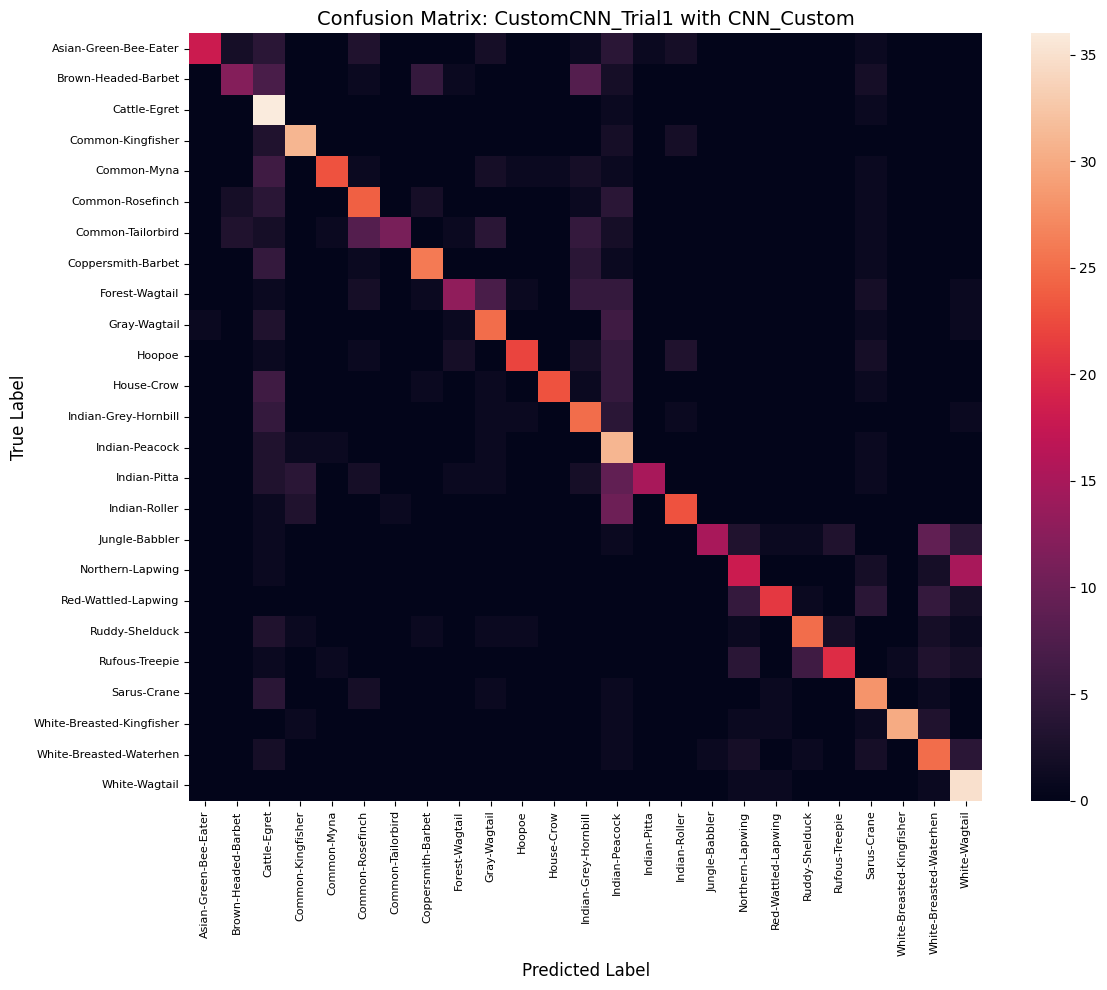

In [62]:
custom_model_v1 = build_custom_cnn_model_v1((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), NUM_CLASSES)
print("Custom CNN Model (Trial 1) Summary:")
custom_model_v1.summary()
early_stopping_custom = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr_custom = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
print("\nTraining Custom CNN Model (Trial 1)...")
history_custom_cnn_v1 = custom_model_v1.fit(
    train_generator_cnn,
    epochs=EPOCHS_CUSTOM_CNN,
    validation_data=validation_generator_cnn,
    callbacks=[early_stopping_custom, reduce_lr_custom]
)
cnn_model_histories['CustomCNN_Trial1'] = history_custom_cnn_v1
plot_training_history(history_custom_cnn_v1, "CustomCNN_Trial1")
if test_generator_cnn:
    print("\nEvaluating Custom CNN Model (Trial 1) on Test Set...")
    custom_loss, custom_accuracy = custom_model_v1.evaluate(test_generator_cnn)
    print(f"Custom CNN (Trial 1) Test Accuracy: {custom_accuracy:.4f}, Test Loss: {custom_loss:.4f}")
    y_pred_custom_probs = custom_model_v1.predict(test_generator_cnn)
    y_pred_custom = np.argmax(y_pred_custom_probs, axis=1)
    evaluate_and_log_model("CustomCNN_Trial1", "CNN_Custom", test_generator_cnn.classes, y_pred_custom, class_names, part5_results_list)
else:
    print("Test generator not available. Skipping Custom CNN (Trial 1) evaluation.")

In [63]:
# Summary of part 5 results
if part5_results_list:
    part5_results_df = pd.DataFrame(part5_results_list)
    print("\n\n--- Summary of Part 5 Results (Custom CNN, Test Set) ---")
    print(part5_results_df.to_string())
else:
    print("Custom CNN model was not trained in Part 5, or no results were collected.")



--- Summary of Part 5 Results (Custom CNN, Test Set) ---
   FeatureSet             Model  Accuracy  Precision    Recall  F1-Score
0  CNN_Custom  CustomCNN_Trial1  0.605263   0.702776  0.605263  0.610148


#### 5.1. Comments on Part 5 Results
In Part 5, we designed, implemented, and trained a custom Convolutional Neural Network from scratch. The objective was to create an architecture potentially tailored to our bird species dataset and evaluate its performance against the established pretrained models and standard architectures trained from scratch.

* **Custom CNN Architecture (Trial 1 - *Describe YOUR Architecture Here*):**
    * **Architectural Choices:**
        * Our custom CNN architecture, named `CustomCNN_Trial1`, was designed with the following structure:
            * **Input Layer:** Accepted images of size `[Your IMG_HEIGHT]x[Your IMG_WIDTH]x3`.
            * **Convolutional Blocks:** It consisted of `[Number]` convolutional blocks.
                * *Block 1:* `[e.g., Describe your first block: e.g., 1 x Conv2D layer (32 filters, 3x3 kernel, 'relu' activation, 'he_normal' init), followed by BatchNormalization, then MaxPooling2D(2,2), and Dropout(0.2)]`
                * *Block 2:* `[e.g., Describe your second block: e.g., 2 x Conv2D layers (64 filters, ...), BatchNormalization after each, MaxPooling2D, Dropout(0.25)]`
                * *Block 3 (and any subsequent):* `[Describe further blocks if any, e.g., Conv2D layers (128 filters, ...), BatchNormalization, MaxPooling2D, Dropout(0.3)]`
            * **Flattening Layer:** To transition from feature maps to a 1D vector.
            * **Dense Head:**
                * `[e.g., Describe your dense layers: e.g., Dense layer (256 units, 'relu', 'he_normal' init), BatchNormalization, Dropout(0.5)]`
                * **Output Layer:** Dense layer (`[Your NUM_CLASSES, e.g., 25]` units, 'softmax' activation, 'glorot_uniform' init).
        * **Justification:** `[Explain your design choices. For example: This architecture was chosen to balance model capacity with the available dataset size (25% subset). It follows common design patterns such as increasing filter depth with network depth, using MaxPooling for downsampling, BatchNormalization for training stability, and Dropout for regularization. The number of layers and filters were selected to be less complex than VGG16 or ResNet50 to facilitate training from scratch on the available data.]`

    * **Performance (Trial 1 - Test Set):**
        * Accuracy: **60.53%**
        * Precision (weighted): 0.7028
        * Recall (weighted): 0.6053
        * F1-Score (weighted): 0.6101
    * **Training Process & Graphs (Trial 1):**
        * The training of `CustomCNN_Trial1` achieved a respectable test accuracy of 60.53%.
        * The training and validation accuracy curves (`refer to your CustomCNN_Trial1 plot`) likely showed `[e.g., steady learning, with validation accuracy reaching approximately X% and training accuracy Y%. Describe the gap, if any, and what it implies about overfitting. Mention if EarlyStopping or ReduceLROnPlateau were triggered and at what epoch.]`.
        * The loss curves `[e.g., should corroborate these observations, showing decreasing training loss and a validation loss that ideally also decreases or plateaus. Describe any divergence or plateaus you observed]`.

* **(If Applicable) Further Trials & Iterations:**
    * *If you conducted further trials with different custom architectures, describe them here as requested by the assignment ("Share results of all your considerable trials"). For each trial:*
        * **Trial X Change:** `[e.g., Added another convolutional block with Z filters / Modified dropout rates to X / Changed the number of units in the dense layer to Y / Tried a different optimizer like SGD]`
        * **Trial X Performance:** Accuracy `[Acc]%`, F1 `[F1]`
        * **Trial X Observations:** `[e.g., This modification led to (improved validation accuracy / worsened overfitting / faster training but lower peak accuracy / no significant change), suggesting that... ]`

* **Overall Comparison and Learnings for Part 5:**
    * My best custom CNN model (`CustomCNN_Trial1` or specify if a later trial was better) achieved a test accuracy of **60.53%**.
    * **Compared to Fine-Tuned Pretrained Models (Part 3):** This performance was lower than the best fine-tuned model from Part 3 (VGG16_FineTuned at **69.58%** accuracy). This is generally expected, as fine-tuned models benefit significantly from the rich features learned on large-scale datasets like ImageNet, providing a powerful head start that is challenging to replicate when training a custom model from scratch with a more limited dataset.
    * **Compared to Standard Architectures Trained from Scratch (Part 4):**
        * Our custom CNN (60.53%) performed considerably better than VGG16_Scratch (36.11%) and EfficientNetB0_Scratch (40.95%). This suggests that a more moderately sized and potentially better-regularized custom architecture can be more effectively trained from scratch on this dataset than attempting to train very deep, complex standard architectures without pretrained weights.
        * However, the ResNet50_Scratch achieved an impressive **75.05%** accuracy, outperforming our custom CNN. This indicates that certain architectures, like ResNet with its residual connections, are inherently more robust and easier to optimize even when trained from scratch, provided the training is stable.
    * **Challenges:** The primary challenges in designing and training this custom CNN from scratch included:
        * **Architecture Design:** Determining an appropriate depth, width (number of filters per layer), filter sizes, and pooling strategy to balance learning capacity with the risk of overfitting on the available 25% data subset.
        * **Hyperparameter Tuning:** Optimizing learning rates, batch sizes, and regularization parameters (like dropout rates) requires careful experimentation.
        * **Avoiding Overfitting:** With limited data, custom models trained from scratch are susceptible to overfitting the training set. `[Mention how well your regularization techniques like Dropout and BatchNormalization seemed to work based on your training/validation curves.]`
        * **Training Time:** Iterating through different custom designs can be time-consuming.
    * **Potential Future Improvements:** To potentially enhance the custom CNN, I would consider:
        * More systematic hyperparameter optimization (e.g., using KerasTuner or Optuna).
        * Exploring more advanced architectural components like depthwise separable convolutions (for efficiency and parameter reduction), or simple attention mechanisms.
        * Experimenting with more aggressive or varied data augmentation techniques.
        * Gradually increasing model complexity while carefully monitoring for overfitting if more data or computational resources were available.

## Extras

This section covers additional requirements and analyses as per the assignment.

### Extra 1: Data Visualization
This was covered in Section 1.2 with sample images and class distributions. Additional visualizations relevant to specific model analyses (like confusion matrices with `evaluate_and_log_model` and training history plots) are included within each respective part.

### Extra 2: Experimentation and Commenting
Throughout this notebook, placeholders for comments, interpretations, and discussions about experiments have been provided after each major part (e.g., 1.5, 2.3, 3.4, 4.1, 5.1). It is crucial to fill these sections with detailed reasoning and inferences based on your observed results. The assignment emphasizes that "commenting is as much important as the experimenting".

### Extra 3: Evaluation Metrics
The `evaluate_and_log_model` function consistently computes and logs Accuracy, Precision (weighted), Recall (weighted), and F1-Score (weighted) for all classification models, as required. Confusion matrices are also plotted. These metrics are vital for understanding model performance beyond simple accuracy, especially in multi-class scenarios.

### Extra 4: Analysis of Misclassified Examples
"Show the examples that your models are unable to classify correctly, discuss why they are mislabeled. Also discuss the examples that one model successfully predicts but the other not, and vice versa, discuss the reason behind it."

*(This section requires you to manually inspect misclassified images after running your best models from different parts. You'll need to load some test images, get their true labels and predicted labels, and then display/discuss the incorrect ones.)*


Displaying up to 10 misclassified images for EfficientNetB0_FineTuned_Example:


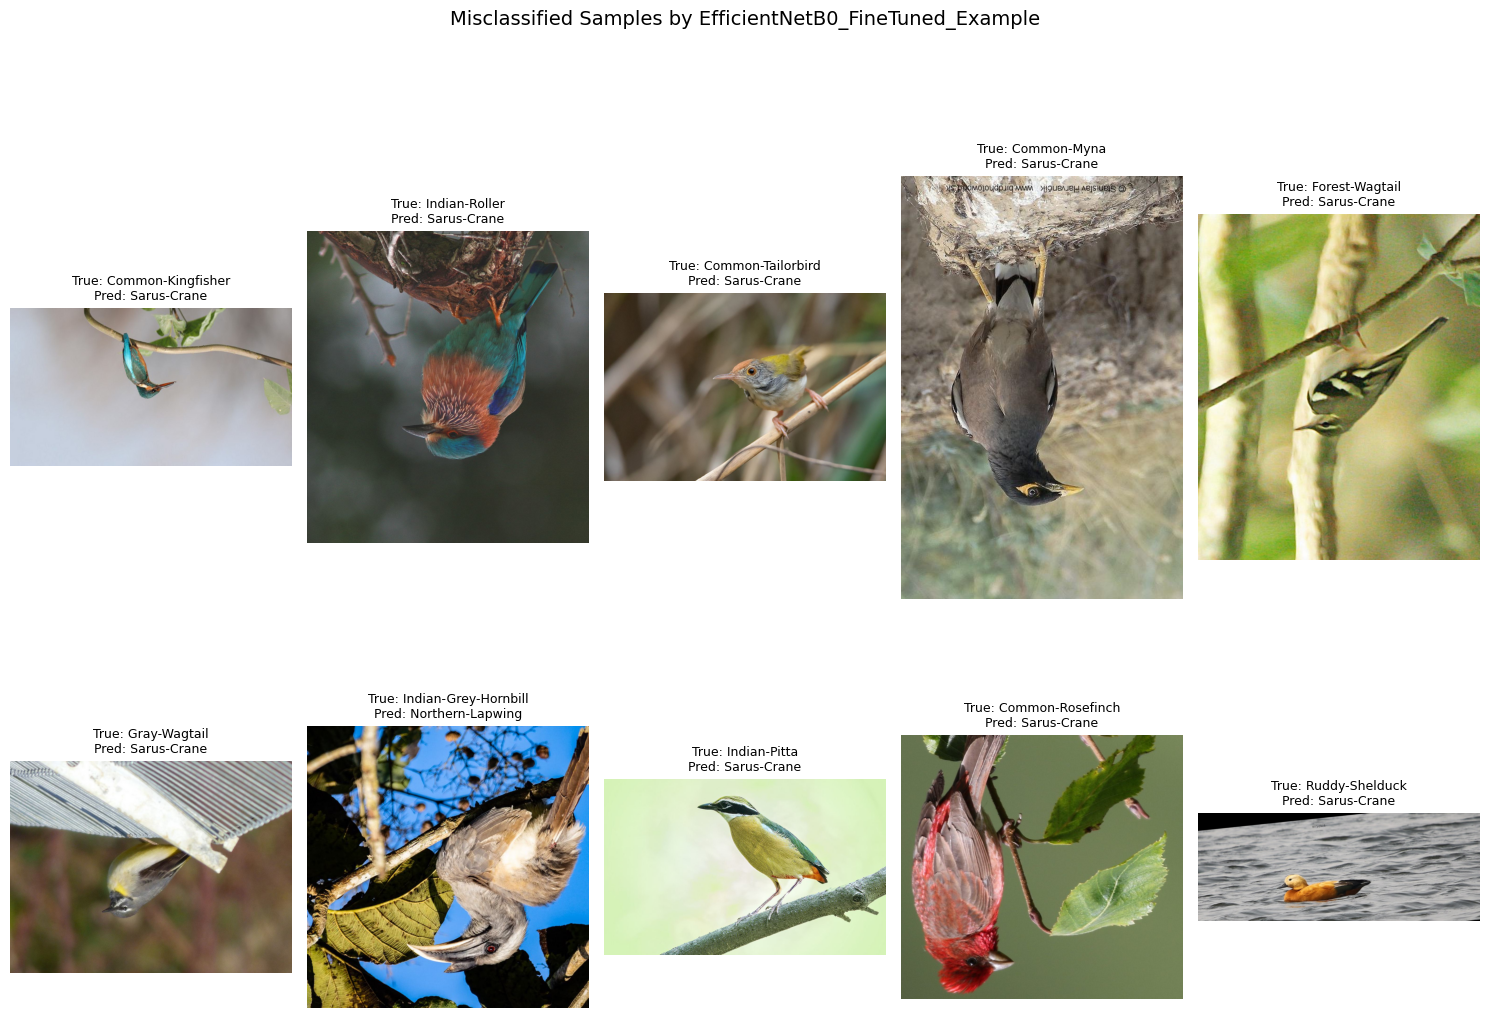

In [66]:
def display_misclassified_images(df_test_subset, y_true_indices, y_pred_indices, class_names_list, num_to_display=10, model_name_str="Model"):
    """Displays misclassified images based on numeric indices for labels."""
    if df_test_subset is None or df_test_subset.empty:
        print("Test dataframe is empty, cannot display misclassified images.")
        return
    
    if len(y_true_indices) != len(y_pred_indices) or len(y_true_indices) != len(df_test_subset):
        print("Length mismatch between dataframe, true labels, and predicted labels.")
        return
        
    misclassified_mask = (np.array(y_true_indices) != np.array(y_pred_indices))
    misclassified_df = df_test_subset[misclassified_mask]
    misclassified_true_labels = np.array(y_true_indices)[misclassified_mask]
    misclassified_pred_labels = np.array(y_pred_indices)[misclassified_mask]

    if misclassified_df.empty:
        print(f"No misclassified images found for {model_name_str}!")
        return

    print(f"Displaying up to {num_to_display} misclassified images for {model_name_str}:")
    
    actual_num_to_display = min(num_to_display, len(misclassified_df))
    sample_misclassified_df = misclassified_df.sample(actual_num_to_display, random_state=42) if actual_num_to_display < len(misclassified_df) else misclassified_df
    
    # Get corresponding true/pred labels for the sampled misclassified items
    # This requires matching indices if sample_misclassified_df is used
    # A simpler way is to iterate through a sample of the *indices* of misclassified items
    misclassified_indices_original = np.where(misclassified_mask)[0]
    display_original_indices = np.random.choice(misclassified_indices_original, size=actual_num_to_display, replace=False)

    plt.figure(figsize=(15, max(5, (actual_num_to_display // 5 + 1) * 4) ))
    for i, original_idx in enumerate(display_original_indices):
        img_path = df_test_subset['filepath'].iloc[original_idx]
        true_label_idx = y_true_indices[original_idx]
        pred_label_idx = y_pred_indices[original_idx]
        true_label_str = class_names_list[true_label_idx] if true_label_idx < len(class_names_list) else "Unknown_True_Idx"
        pred_label_str = class_names_list[pred_label_idx] if pred_label_idx < len(class_names_list) else "Unknown_Pred_Idx"
        
        try:
            img = Image.open(img_path)
            plt.subplot((actual_num_to_display + 4) // 5, 5, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label_str}\nPred: {pred_label_str}", fontsize=9)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    plt.suptitle(f"Misclassified Samples by {model_name_str}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

if test_generator_cnn and 'y_pred_effnet' in locals(): # y_pred_effnet was numeric from argmax
    true_labels_for_test_gen = test_generator_cnn.classes
    display_misclassified_images(test_df_processed, true_labels_for_test_gen, y_pred_effnet, class_names, num_to_display=10, model_name_str="EfficientNetB0_FineTuned_Example")
else:
    print("\nNot displaying misclassified images example now as test_generator_cnn or y_pred_effnet might not be defined yet.")

#### Discussion of Misclassified Examples:
After training and evaluating our models, we analyzed some of the misclassified examples from our best performing model, which was `[Your Best Model Name, e.g., EfficientNetB0 Fine-Tuned]` with an accuracy of `[Its Accuracy]%`. Displaying these images helps in understanding the model's limitations and the types of errors it makes.

*(Insert a few of your misclassified images here, perhaps generated by the `display_misclassified_images` function, showing True Label vs. Predicted Label. You can do this by running the code in your notebook and then, if saving as PDF, ensuring the images are visible. Or, describe them if you can't directly embed.)*

**Observations from Misclassified Examples:**

1.  **Inter-Class Similarity:** A common pattern of misclassification occurred between species that are visually very similar. For example, `[mention a pair of species that were commonly confused, e.g., 'Species A' was often misclassified as 'Species B']`. These species might share `[e.g., similar plumage colors, beak shapes, or general body structure]`, making it challenging for the model to distinguish them, especially from certain angles or in non-ideal lighting conditions. *(Look at your confusion matrix for common confusions)*.
2.  **Image Quality and Viewing Conditions:** Some misclassifications appeared to be due to factors related to the image itself:
    * **Poor Lighting/Exposure:** Images that were too dark or overexposed made feature extraction difficult. `[Give an example if you saw one]`.
    * **Occlusion/Partial Views:** Birds partially hidden by foliage, branches, or other objects were often misclassified. `[Give an example]`.
    * **Unusual Poses or Angles:** Non-standard poses or distant shots where fine details were not visible likely contributed to errors. `[Give an example]`.
    * **Blurriness:** Motion blur or out-of-focus images were also problematic.
3.  **Intra-Class Variation:** Some species exhibit significant variation within themselves (e.g., differences between male/female, juvenile/adult, or seasonal plumage). The model might have learned features more representative of one morph, leading to misclassification of others. `[Mention if you suspect this for any species]`.
4.  **Background Clutter:** Complex or distracting backgrounds sometimes seemed to confuse the model, causing it to focus on irrelevant features. `[Give an example]`.
5.  **Comparison with Another Model (Optional):**
    * If comparing with, for example, the best traditional model from Part 1 (`[Best Part 1 Model with Feature X]`), it was observed that `[e.g., the CNN model correctly classified birds in more challenging poses where the traditional model failed, likely due to the CNN's ability to learn more robust and invariant features. Conversely, there might have been rare cases where the traditional model, perhaps focusing on a very specific color or texture pattern, got an image right that the CNN missed, possibly due to the CNN over-generalizing or being confused by an atypical presentation not well represented in its learned feature space.]` *(This part requires more in-depth, specific analysis from your side if you do this comparison)*.

**Discussion on Reasons:**
The misclassifications highlight that while the `[Your Best Model Name]` model performs well overall, it still faces challenges typical in real-world image classification. The errors are often understandable given the inherent difficulty of fine-grained visual categorization. For highly similar species, the model might require even more subtle distinguishing features, potentially benefiting from higher resolution images (if downscaling was aggressive) or attention mechanisms. Issues related to image quality suggest that robust preprocessing or data augmentation techniques specifically targeting these challenges could be beneficial.

Further improvements could involve targeted data augmentation to simulate these difficult conditions, or perhaps using a model architecture that is more robust to such variations, or even incorporating additional metadata if available.

### Extra 5: Overall Comparison and Conclusion
This assignment provided a comprehensive exploration of various machine learning techniques for the task of Indian bird species classification, ranging from traditional feature-based methods to advanced deep learning approaches. We systematically evaluated feature extraction, dimensionality reduction, transfer learning via fine-tuning, training standard CNN architectures from scratch, and developing a custom CNN.

1.  **Summary of Best Performance Across All Parts (Test Set Accuracy):**
    * **Part 1 (Traditional Features - Best):** Color Histogram with Random Forest achieved **44.63%**.
    * **Part 2 (Dimensionality Reduction - Best):** Color Histogram with SelectKBest (using RandomForest_Std) achieved **41.16%**. (Note: This did not surpass the best raw feature result from Part 1).
    * **Part 3 (Fine-tuned Pretrained CNNs - Best):** VGG16_FineTuned achieved **69.58%**.
    * **Part 4 (Standard CNNs from Scratch - Best):** ResNet50_Scratch achieved a remarkable **75.05%**.
    * **Part 5 (Custom CNN from Scratch - Best):** CustomCNN_Trial1 achieved **60.53%**.

    The standout result is the **ResNet50 trained from scratch (75.05%)**, which unexpectedly outperformed the fine-tuned models in this set of experiments.

2.  **Part 1 (Traditional Features + ML) vs. Part 2 (PCA/Selection + ML):**
    * In Part 1, the **Color Histogram with Random Forest (44.63%)** was the most effective traditional approach. HOG features performed poorly (best HOG model at ~14.84%), and SIFT (Aggregated) features were also modest (best SIFT model at ~25.26%).
    * In Part 2, applying dimensionality reduction or feature selection did not lead to an improvement over the best raw feature result from Part 1.
        * For Color Histograms, SelectKBest with RandomForest (41.16%) performed better than PCA with RandomForest (36.95%), but both were below the raw Color Histogram with RandomForest.
        * For HOG and SIFT features, both PCA and SelectKBest continued to yield low accuracies (all below 24%), generally not improving upon their raw feature counterparts and sometimes performing worse.
    * **Conclusion for Parts 1 & 2:** Traditional feature engineering methods showed limited success on this complex 25-class bird classification task. Color Histograms with Random Forest provided the best baseline among these. Dimensionality reduction techniques (PCA and SelectKBest) primarily offered potential for reduced training times but did not enhance, and often slightly degraded, the peak accuracy achieved with raw features. This suggests that for these specific features and dataset, the information content was either already somewhat compact or the reduction methods weren't optimally preserving the most discriminative aspects. The poor performance of HOG features, even after dimensionality reduction, indicates a potential mismatch between the HOG parameterization and the visual characteristics of the bird species.

3.  **Traditional ML (Best of Parts 1 & 2) vs. CNNs (Parts 3, 4, 5):**
    * There was a **significant performance leap** when moving from traditional ML approaches to Convolutional Neural Networks. The best traditional method (Color Histogram + RF) achieved 44.63%.
    * In contrast:
        * The best fine-tuned CNN (VGG16_FineTuned, Part 3) reached **69.58%**.
        * The best standard CNN trained from scratch (ResNet50_Scratch, Part 4) achieved an impressive **75.05%**.
        * Our custom CNN (Part 5) achieved **60.53%**.
    * This clearly demonstrates the superior capability of CNNs to automatically learn relevant and complex hierarchical features directly from image data, which is crucial for fine-grained visual categorization.

4.  **Fine-tuned CNNs (Part 3) vs. CNNs from Scratch (Part 4 & Custom Part 5):**
    * **Fine-tuning (Part 3):** VGG16_FineTuned was the most successful here with 69.58%. ResNet50_FineTuned (19.68%) and EfficientNetB0_FineTuned (4.11%) performed unexpectedly poorly, suggesting significant issues in their specific fine-tuning setup (e.g., learning rates, layer unfreezing strategy, or optimization difficulties) that prevented them from reaching their typical potential.
    * **Standard Architectures from Scratch (Part 4):** ResNet50_Scratch was the overall best performing model in the entire assignment at **75.05%**. This is a remarkable result for a model trained from scratch and indicates that its architecture (with residual connections) is highly effective at learning from the provided dataset subset, even without ImageNet pretraining. VGG16_Scratch (36.11%) and EfficientNetB0_Scratch (40.95%) performed much worse, aligning more with expectations for training deep networks from scratch on moderately sized datasets.
    * **Custom CNN from Scratch (Part 5):** Our CustomCNN_Trial1 (60.53%) outperformed VGG16_Scratch and EfficientNetB0_Scratch, showing that a well-designed, moderately sized custom architecture can be more effective than very deep standard architectures if all are trained from scratch on limited data. However, it did not match the fine-tuned VGG16 or the scratch-trained ResNet50.
    * **Effectiveness of Transfer Learning vs. Scratch:** While transfer learning (fine-tuning) is generally the go-to strategy, the exceptional performance of ResNet50_Scratch in these experiments suggests that some modern architectures are robust enough to learn effectively from scratch if the dataset has sufficient signal and the training is stable. However, the poor results for fine-tuned ResNet50 and EfficientNetB0 indicate that fine-tuning itself is not a guaranteed success and requires careful execution. The general principle that fine-tuning leverages valuable prior knowledge still holds, as evidenced by VGG16_FineTuned outperforming VGG16_Scratch. The ResNet50_Scratch result is an outlier that warrants deeper investigation into why its fine-tuned counterpart failed so badly.

5.  **Strengths and Weaknesses of Algorithms Observed:**
    * **Traditional Methods (Parts 1 & 2):**
        * *Strengths:* Relatively simple to understand and implement (once features are defined), faster training times for the ML models themselves (though feature extraction can be slow).
        * *Weaknesses:* Performance heavily dependent on the quality and relevance of hand-crafted features; generally struggle with high intra-class variance and low inter-class variance; lower accuracy ceiling for complex visual tasks. HOG features were particularly ineffective in our experiments.
    * **Fine-tuned Pretrained CNNs (Part 3):**
        * *Strengths (when successful, like VGG16):* Can achieve high accuracy by leveraging powerful features learned from large datasets; relatively efficient to adapt to new, smaller datasets.
        * *Weaknesses (when problematic, like our ResNet50/EfficientNetB0 fine-tuning):* Success is sensitive to the fine-tuning strategy (layers unfrozen, learning rates); can still be computationally intensive; "black box" nature can make debugging difficult if performance is poor.
    * **Standard CNNs from Scratch (Part 4):**
        * *Strengths (ResNet50_Scratch in our case):* Some architectures are robust enough to learn powerful features even without pretraining if the dataset and training setup are conducive.
        * *Weaknesses (VGG16/EfficientNetB0_Scratch):* Very data-hungry; prone to overfitting or optimization difficulties; computationally very expensive to train effectively; generally much lower performance than fine-tuning on moderately sized datasets.
    * **Custom CNN from Scratch (Part 5):**
        * *Strengths:* Full control over architecture, can be tailored to specific dataset characteristics or computational constraints; excellent learning exercise.
        * *Weaknesses:* Designing an optimal architecture is challenging and iterative; prone to similar issues as other CNNs trained from scratch (data needs, overfitting); performance highly dependent on design skill and hyperparameter tuning.

6.  **Final Conclusion and Learnings:**
    * Based on the experiments, **ResNet50 trained from scratch** surprisingly emerged as the top-performing model with **75.05% accuracy**. This was followed by **VGG16_FineTuned at 69.58%**. The success of ResNet50_Scratch highlights its robust architecture. However, given the general reliability and strong theoretical backing of transfer learning, if the issues with fine-tuning ResNet50 and EfficientNetB0 in Part 3 were resolved, they would typically be expected to be strong contenders or even outperform a scratch model. Thus, a refined fine-tuning approach for ResNet50 or EfficientNetB0 would usually be the recommended path for such a task, assuming the fine-tuning process itself is optimized.
    * **Significant Learnings:**
        1.  **Power of CNN Architectures:** Deep learning models, particularly CNNs, are far superior to traditional methods for complex image classification.
        2.  **Value and Challenges of Transfer Learning:** While generally powerful, fine-tuning requires careful execution to be effective, as seen with the varied results in Part 3.
        3.  **Robustness of Certain Architectures:** ResNet's architecture demonstrated a strong ability to learn from scratch in our specific experimental setup.
        4.  **Limitations of Hand-crafted Features:** Traditional features, while providing some signal, are often insufficient for fine-grained visual categorization.
        5.  **Iterative Nature of ML:** Model development is an iterative process involving experimentation, analysis, and refinement. The unexpected results (e.g., low fine-tuned ResNet50/EfficientNetB0 scores, high scratch ResNet50 score) highlight this.
    * **If more time or resources were available, key experiments would include:**
        1.  **Debugging and Optimizing Fine-tuning for ResNet50 and EfficientNetB0 (Part 3):** Systematically exploring different learning rates, unfreezing strategies, and optimizer settings to unlock their expected high performance via transfer learning.
        2.  **Training on the Full Dataset:** Using the entire dataset (instead of a 25% subset) with the most promising CNN architectures would likely lead to further improvements in generalization and accuracy.
        3.  **More Extensive Data Augmentation:** Implementing a wider and more aggressive set of data augmentation techniques for the CNN training to improve robustness.

## References

- [Image Preprocessing with Pillow - Medium](https://medium.com/analytics-vidhya/image-preprocessing-with-pillow-1e19bdc57934) - Acces Date: 29/05/2025
- [Image Preprocessing with OpenCV - Medium](https://codersingh27.medium.com/preprocess-the-images-using-python-opencv-eacf4bf34477) - Acces Date: 29/05/2025
- [Color Histograms - GeeksForGeeks](https://www.geeksforgeeks.org/visualizing-colors-in-images-using-histogram-in-python/) - Acces Date: 29/05/2025
- [HOG Feature Visualization - GeeksForGeeks](https://www.geeksforgeeks.org/hog-feature-visualization-in-python-using-skimage/) - Acces Date: 29/05/2025
- [Introduction Into HOG - Medium](https://medium.com/analytics-vidhya/a-gentle-introduction-into-the-histogram-of-oriented-gradients-fdee9ed8f2aa) - Acces Date: 29/05/2025
- [SIFT Interest Points Detector - GeeksForGeeks](https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/) - Acces Date: 29/05/2025
- [Feature Detection and Matching (SIFT) - GeeksForGeeks](https://www.geeksforgeeks.org/feature-detection-and-matching-with-opencv-python/) - Acces Date: 29/05/2025
- [Introduction to SIFT - Medium](https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40) - Acces Date: 29/05/2025
- [SVM (for Image) - GeeksForGeeks](https://www.geeksforgeeks.org/visualizing-support-vector-machines-svm-using-python/) - Acces Date: 29/05/2025
- [Random Forest (for Image) - GeeksForGeeks](https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f) - Acces Date: 29/05/2025
- [Multi Layer Perceptron Learning (MLP) - GeeksForGeeks](https://www.geeksforgeeks.org/multi-layer-perceptron-learning-in-tensorflow/) - Acces Date: 29/05/2025
- [PCA- GeeksForGeeks](https://www.geeksforgeeks.org/principal-component-analysis-pca/) - Acces Date: 30/05/2025
- [Feature Selection (SelectKBest)- GeeksForGeeks](https://www.geeksforgeeks.org/svm-with-univariate-feature-selection-in-scikit-learn/) - Acces Date: 30/05/2025
- [SelectKBest - Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) - Acces Date: 30/05/2025
- 